In [1]:
import os, glob, json
import pickle
import pandas as pd
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import re
import numpy as np
from scipy import stats
from collections import Counter, defaultdict
import random, math
from tqdm import tqdm
import platform

# print machine name
machine_name = platform.node().split(".")[0]
print(machine_name)

# print available scratch directories
print(" ".join(os.listdir(f"/{machine_name}")))
scr_dir = os.listdir(f"/{machine_name}")[0]

DISK_IO_DIR = "/{}/{}/yiweil".format(machine_name,scr_dir)
print(DISK_IO_DIR)
if not os.path.exists(DISK_IO_DIR):
    os.mkdir(DISK_IO_DIR)

john11
scr1
/john11/scr1/yiweil


# Load utils

In [2]:
from cleantext import clean

clean_str = lambda s: clean(s,
                            fix_unicode=True,               # fix various unicode errors
                            to_ascii=True,                  # transliterate to closest ASCII representation
                            lower=True,                     # lowercase text
                            no_line_breaks=True,           # fully strip line breaks as opposed to only normalizing them
                            no_urls=True,                  # replace all URLs with a special token
                            no_emails=True,                # replace all email addresses with a special token
                            no_phone_numbers=True,         # replace all phone numbers with a special token
                            no_numbers=False,               # replace all numbers with a special token
                            no_digits=False,                # replace all digits with a special token
                            no_currency_symbols=True,      # replace all currency symbols with a special token
                            no_punct=False,                 # fully remove punctuation
                            replace_with_url="<URL>",
                            replace_with_email="<EMAIL>",
                            replace_with_phone_number="<PHONE>",
                            replace_with_number="<NUMBER>",
                            replace_with_digit="0",
                            replace_with_currency_symbol="<CUR>",
                            lang="en"
                            )

def remove_special_chars(s):
    return re.sub('[^A-Za-z]+', ' ', s)

def contains_keyword(s,keyword_set,ignore_case=True,remove_special=True):
    if ignore_case:
        s = s.lower()
    if remove_special:
        s = remove_special_chars(s)
    pat = re.compile(r'\b(' + (r'|'.join(keyword_set)) + r')\b')
    #print(set(pat.findall(remove_special_chars(s))).intersection(keyword_set))
    return len(set(pat.findall(s)).intersection(keyword_set)) > 0

In [3]:
STANZA_DIR='/u/scr/yiweil/Green-American-Lexicon/2_data_exploration/combined_stanza_output_with_ner'

# Loads stanza-processed json object if utterance text is non-empty and not a single '/' or '-'
def get_stanza_json(utt,
    stanza_dir='/u/scr/yiweil/Green-American-Lexicon/2_data_exploration/combined_stanza_output_with_ner'):
    if len(utt.text) > 0 and utt.text != '-' and utt.text != '/':
        return json.load(open(os.path.join(stanza_dir,f'{utt.id}.json'),'r'))

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

def get_lemmas_with_heads(stanza_json_parse, exclude_punc=True):
    if exclude_punc:
        return [f"{w['lemma']}_{stanza_json_parse[ix_sent][int(w['head'])-1]['lemma']}"
                if w['lemma'] is not None 
                else f"{w['text']}_{stanza_json_parse[ix_sent][int(w['head'])-1]['text']}"
                for ix_sent,sent in enumerate(stanza_json_parse)
                for w in sent if w['upos'] != 'PUNCT']
    else:
        return [f"{w['lemma']}_{stanza_json_parse[ix_sent][int(w['head'])-1]['lemma']}"
                if w['lemma'] is not None 
                else f"{w['text']}_{stanza_json_parse[ix_sent][int(w['head'])-1]['text']}"
                for ix_sent,sent in enumerate(stanza_json_parse)
                for w in sent]

def get_counts_for_lor(corpus, sample1_ids, priors, save_prefix, 
                       stanza_dir='/u/scr/yiweil/Green-American-Lexicon/2_data_exploration/combined_stanza_output_with_ner_embed_removed',
                       verbose=False, cache=True, background_only=False, skip_background=False,
                       ngram_range=(1,2), min_df=5, do_lowercase=True, 
                       upos=False, xpos=False, depparse=True, heads=False):
    
    if not cache:
        counts_dict = {}
        if not background_only:
            print(f"Creating count matrix for +/- samples with ngram range {ngram_range}, min_df = {min_df}, lowercasing = {do_lowercase}, upos = {upos}, xpos = {xpos}, depparse = {depparse}, and heads = {heads}...")

            # create text arrays
            corpus1_texts, corpus2_texts = [], []
            for utt in tqdm(corpus.iter_utterances()):
                json_obj = get_stanza_json(utt,stanza_dir=stanza_dir)
                if json_obj is not None:
                    if utt.id in sample1_ids:
                        if upos:
                            corpus1_texts.append(' '.join([f"{x['lemma']}_{x['upos']}" 
                                                           if x['lemma'] is not None 
                                                           else f"{x['text']}_{x['upos']}"
                                                           for sent in json_obj['parse']
                                                           for x in sent if x['upos'] != 'PUNCT']))
                        elif xpos:
                            corpus1_texts.append(' '.join([f"{x['lemma']}_{x['xpos']}" 
                                                           if x['lemma'] is not None 
                                                           else f"{x['text']}_{x['xpos']}"
                                                           for sent in json_obj['parse']
                                                           for x in sent if x['upos'] != 'PUNCT']))
                        elif depparse:
                            corpus1_texts.append(' '.join([f"{x['lemma']}_{x['deprel']}" 
                                                           if x['lemma'] is not None 
                                                           else f"{x['text']}_{x['deprel']}"
                                                           for sent in json_obj['parse']
                                                           for x in sent if x['upos'] != 'PUNCT']))
                        elif heads:
                            corpus1_texts.append(' '.join(get_lemmas_with_heads(json_obj['parse'])))
                        else:
                            corpus1_texts.append(' '.join([x['lemma'] 
                                                           if x['lemma'] is not None 
                                                           else x['text']
                                                           for sent in json_obj['parse']
                                                           for x in sent if x['upos'] != 'PUNCT']))
                    else:
                        if upos:
                            corpus2_texts.append(' '.join([f"{x['lemma']}_{x['upos']}" 
                                                           if x['lemma'] is not None 
                                                           else f"{x['text']}_{x['upos']}"
                                                           for sent in json_obj['parse']
                                                           for x in sent if x['upos'] != 'PUNCT']))
                        elif xpos:
                            corpus2_texts.append(' '.join([f"{x['lemma']}_{x['xpos']}" 
                                                           if x['lemma'] is not None 
                                                           else f"{x['text']}_{x['xpos']}"
                                                           for sent in json_obj['parse']
                                                           for x in sent if x['upos'] != 'PUNCT']))
                        elif depparse:
                            corpus2_texts.append(' '.join([f"{x['lemma']}_{x['deprel']}"
                                                           if x['lemma'] is not None 
                                                           else f"{x['text']}_{x['deprel']}"
                                                           for sent in json_obj['parse']
                                                           for x in sent if x['upos'] != 'PUNCT']))
                        elif heads:
                            corpus2_texts.append(' '.join(get_lemmas_with_heads(json_obj['parse'])))
                        else:
                            corpus2_texts.append(' '.join([x['lemma'] 
                                                           if x['lemma'] is not None 
                                                           else x['text']
                                                           for sent in json_obj['parse']
                                                           for x in sent if x['upos'] != 'PUNCT']))
            del corpus # free up memory
            print(f'\tFound {len(corpus1_texts)} non-empty texts in sample 1; {len(corpus2_texts)} non-empty texts in sample 2.')
            if verbose:
                print('\tExample corpus1 texts:',corpus1_texts[:3])
                print('\tExample corpus2 texts:',corpus2_texts[:3])

            # create; save count dictionaries from CV
            for corp_ in ['corpus1','corpus2']:
                vectorizer = CountVectorizer(analyzer='word', ngram_range=ngram_range, 
                                             min_df=min_df, lowercase=do_lowercase)
                X = vectorizer.fit_transform(corpus1_texts) if corp_ == 'corpus1' \
                    else vectorizer.fit_transform(corpus2_texts)
                vocab = vectorizer.get_feature_names()
                counts = np.sum(X,axis=0)
                count_dict = Counter({vocab[i]: counts[0,i] for i in range(len(vocab))
                                  if len(vocab[i]) > 0})
                counts_dict[corp_] = count_dict
                savename = os.path.join('lor_count_mats',
                                     f'{save_prefix}_{corp_}_ngrams={ngram_range}_min_df={min_df}_lowercase={do_lowercase}_upos={upos}_xpos={xpos}_depparse={depparse}_heads={heads}')
    #             if not os.path.exists('lor_count_mats'):
    #                 os.mkdir('lor_count_mats')
                pickle.dump(count_dict,open(savename,'wb'))
                print(f"\tSaved counts of {corp_} (N types = {len(count_dict)}) to {savename}.")
        else:
            print("Skipping directly to creation of background corpus counts matrices.")
        
        if not skip_background:
            # create texts array
            prior_texts = []
            for prior_corp in priors:
                for utt in tqdm(prior_corp.iter_utterances()):
                    json_obj = get_stanza_json(utt)
                    if json_obj is not None:
                        if upos:
                            prior_texts.append(' '.join([f"{x['lemma']}_{x['upos']}" 
                                                         if x['lemma'] is not None 
                                                         else f"{x['text']}_{x['upos']}"
                                                         for sent in json_obj['parse']
                                                         for x in sent if x['upos'] != 'PUNCT']))
                        elif xpos:
                            prior_texts.append(' '.join([f"{x['lemma']}_{x['xpos']}" 
                                                         if x['lemma'] is not None 
                                                        else f"{x['text']}_{x['xpos']}"
                                                         for sent in json_obj['parse']
                                                         for x in sent if x['upos'] != 'PUNCT']))
                        elif depparse:
                            prior_texts.append(' '.join([f"{x['lemma']}_{x['deprel']}" 
                                                         if x['lemma'] is not None 
                                                           else f"{x['text']}_{x['deprel']}"
                                                           for sent in json_obj['parse']
                                                           for x in sent if x['upos'] != 'PUNCT']))
                        elif heads:
                            prior_texts.append(' '.join(get_lemmas_with_heads(json_obj['parse'])))
                        else:
                            prior_texts.append(' '.join([x['lemma'] 
                                                         if x['lemma'] is not None 
                                                           else x['text']
                                                         for sent in json_obj['parse']
                                                         for x in sent if x['upos'] != 'PUNCT']))
                del prior_corp # free up memory when done iterating
            del priors # free up memory when done iterating
            #del corp_to_analyze['switchboard']
            #del corp_to_analyze['gen_reddit']
            if verbose:
                print('Example prior corpus texts:',prior_texts[:3])

            # create; save count dictionary
            if len(prior_texts) > 0:
                vectorizer_prior = CountVectorizer(analyzer='word', ngram_range=ngram_range, min_df=min_df, 
                                                   lowercase=do_lowercase)
                X_prior = vectorizer_prior.fit_transform(prior_texts)
                vocab_prior = vectorizer_prior.get_feature_names()
                print(len(vocab_prior))
                #pickle.dump(X_prior,open('X_prior.pkl','wb'))
                counts_prior = np.sum(X_prior,axis=0)
                count_dict_prior = Counter({vocab_prior[i]: counts_prior[0,i] for i in range(len(vocab_prior))
                                   if len(vocab_prior[i]) > 0})
                counts_dict['prior'] = count_dict_prior

                savename_prior = os.path.join('lor_count_mats',
                                         f'{save_prefix}_prior_ngrams={ngram_range}_min_df={min_df}_lowercase={do_lowercase}_upos={upos}_xpos={xpos}_depparse={depparse}_heads={heads}')
                pickle.dump(count_dict_prior,open(savename_prior,'wb'))
                print(f"\tSaved counts of prior (N types = {len(count_dict_prior)}) to {savename_prior}.")
            else:
                print("\tNo prior corpora passed.")
                counts_dict['prior'] = Counter()
        
        return counts_dict
        
    else:
        print("Loading counters from cache...")
        counts_dict = {}
        for save_infix in ['corpus1','corpus2','prior']:
            savename = os.path.join('lor_count_mats',
                                 f'{save_prefix}_{save_infix}_ngrams={ngram_range}_min_df={min_df}_lowercase={do_lowercase}_upos={upos}_xpos={xpos}_depparse={depparse}_heads={heads}')
            try:
                counts_dict[save_infix] = pickle.load(open(savename,'rb'))
            except FileNotFoundError:
                pass
        return counts_dict        

In [34]:
PRIOR_WEIGHT = 1
COUNTS1_WEIGHT = 1 # use for +delta
COUNTS2_WEIGHT = 1

def do_weighted_lor(counts1, counts2, counts_prior, 
                    prior_weight=PRIOR_WEIGHT, counts1_weight=COUNTS1_WEIGHT, counts2_weight=COUNTS2_WEIGHT, 
                    verbose=False):
    
    counts1,counts2 = counts1.copy(),counts2.copy()
    if type(counts1) != Counter:
        counts1 = Counter(counts1)
        counts2 = Counter(counts2)
    prior = counts_prior + counts1 + counts2

    sigmasquared = defaultdict(float)
    sigma = defaultdict(float)
    delta = defaultdict(float)

    for word in prior.keys():
        prior[word] = int(prior[word]/prior_weight + 0.5)

    for word in counts2.keys():
        counts1[word] = int(counts1[word]/counts1_weight + 0.5)
        if prior[word] == 0:
            prior[word] = 1

    for word in counts1.keys():
        counts2[word] = int(counts2[word]/counts2_weight + 0.5)
        if prior[word] == 0:
            prior[word] = 1

    n1  = sum(counts1.values())
    n2  = sum(counts2.values())
    nprior = sum(prior.values())
    print("Size of class1:",n1)
    print("Size of class2:",n2)
    print("Size of prior:",nprior)

    for word in prior.keys():
        if prior[word] > 0:
            l1 = float(counts1[word] + prior[word]) / (( n1 + nprior ) - (counts1[word] + prior[word]))
            l2 = float(counts2[word] + prior[word]) / (( n2 + nprior ) - (counts2[word] + prior[word]))
            sigmasquared[word] =  1/(float(counts1[word]) + float(prior[word])) + 1/(float(counts2[word]) + float(prior[word]))
            sigma[word] =  math.sqrt(sigmasquared[word])
            delta[word] = ( math.log(l1) - math.log(l2) ) / sigma[word]

    if verbose:
        for word in sorted(delta, key=delta.get):
            print(word)
            print("%.3f" % delta[word])
            
    return delta

In [6]:
# og_dir = '/juice/scr/yiweil/Green-American-Lexicon/2_data_exploration'
# os.chdir('/juice/scr/yiweil/Green-American-Lexicon/1_data_collection/reddit/convokit')
# import customized_fighting_words
# from customized_fighting_words import FightingWords
# os.chdir(og_dir)

In [7]:
# import importlib 
# os.chdir('/juice/scr/yiweil/Green-American-Lexicon/1_data_collection/reddit/convokit')
# importlib.reload(customized_fighting_words)
# from customized_fighting_words import FightingWords
# os.chdir(og_dir)

In [70]:
# Update meta to include whether an utterance was awarded a delta or not

deltalog = pd.read_csv(os.path.join('/u/scr/yiweil/Green-American-Lexicon/1_data_collection/reddit',
                                    'deltalog.tsv'),
                      sep='\t',header=0)
delta_awarded_utt_ids = set(deltalog['awarded_utt_id'].values)
delta_awarding_utt_ids = set(deltalog['awarding_utt_id'].values)
delta_counts = deltalog['awarded_utt_id'].value_counts()
utt_id2num_deltas = {id_: delta_counts[id_] for id_ in delta_counts.index.values}

def is_awarded_delta(utterance_id):
    return utterance_id in delta_awarded_utt_ids

def num_deltas(utterance_id):
    if utterance_id in delta_awarded_utt_ids:
        return utt_id2num_deltas[utterance_id]
    else:
        return 0

## Filter bots/moderators

In [62]:
# bot/moderator-filtering utils
known_bots = pickle.load(open('../1_data_collection/reddit/bots/bots.pkl','rb'))
with open('../1_data_collection/reddit/known_cmv_mods.txt','r') as f:
    known_cmv_mods = f.read().splitlines()
bot_mod_set = known_bots | set(known_cmv_mods)
bot_mod_set.add('TotesMessenger')

def written_by_bot(corp,utt_idx,bot_mod_set):
    return corp.get_utterance(utt_idx).speaker.id in bot_mod_set

def filter_bots_mods_removed(corp,bot_mod_set=bot_mod_set,filter_bot_suffixes=True):
    
    if filter_bot_suffixes:
        print("Filtering speakers with usernames ending in '-bot'...")
        speaker_ids = corp.get_speaker_ids()
        speaker_names = [corp.get_speaker(s_id).id for s_id in speaker_ids]
        potential_bots = [x for x in speaker_names if type(x) == str and x.endswith('bot') 
                          and 'robot' not in x.lower()
                          and 'bottle' not in x.lower() and 'bottom' not in x.lower()]
        bot_mod_set |= set(potential_bots)
        del speaker_ids
        
    for utt in corp.iter_utterances():
        utt.meta['written_by_bot'] = written_by_bot(corp,utt.id,bot_mod_set)
        
    utt_ids_to_keep = set([utt.id for utt in corp.iter_utterances()
                          if not utt.meta['written_by_bot']
                          and not utt.text == '[deleted]'
                          and not utt.text == '[removed]'])
    print("Found {} non-deleted/removed utterances not written by a bot or moderator.".format(
                len(utt_ids_to_keep)))
    
    return corp.filter_utterances_by(lambda utt: utt.id in utt_ids_to_keep or utt.id[:2]=='t3')

## Filter generic comments

In [61]:
with open('generic_comment_regex_patterns.txt','r') as f:
    generic_regex_pats = f.read().splitlines()
GENERIC_REGEX_PATS = [re.compile(pat, re.IGNORECASE) for pat in generic_regex_pats]

def is_generic(utt_text,compiled_pats):
    for pat in compiled_pats:
        res = re.search(pat, utt_text)
        if res:
            return True
    return False

def filter_generic_comments(corp,generic_regex_pats,save=True,
                            fname='non_generic_utt_ids',cache=True):
    
    if cache:
        utt_ids_to_keep = pickle.load(open(fname,'rb'))  
    else:
        with open(os.path.join(DISK_IO_DIR,'generic_utt_ids.txt'),'w') as f:
            for utt in tqdm(corp.iter_utterances()):
                bool_ = is_generic(utt.text,compiled_pats=generic_regex_pats)
                if bool_:
                    f.write(utt.id+'\n')
                utt.meta['is_generic'] = bool_

        utt_ids_to_keep = set([utt.id for utt in corp.iter_utterances()
                                      if not utt.meta['is_generic']])
        if save:
            pickle.dump(utt_ids_to_keep,open('{}.pkl'.format(fname),'wb'))
        
    print("Filtering to {} non-generic comments.".format(
                    len(utt_ids_to_keep)))

    return corp.filter_utterances_by(lambda utt: utt.id in utt_ids_to_keep or utt.id[:2]=='t3')

Do un-cached version to create cache once initially:

In [10]:
# filtered_cc_cmv_corpus = filter_generic_comments(
#     corp_to_analyze['matched_cc_cmv_subsample'], 
#     GENERIC_REGEX_PATS,
#     fname='non_generic_utt_ids_matched_cc_cmv_subsample',cache=False)
# filtered_cc_cmv_corpus.print_summary_stats()

## Remove footnotes; in-line embedded text

In [11]:
def cleanup(utt_text):
    lines = [line for line in utt_text.splitlines()
             if not line.lstrip().startswith("&gt;")
             and not line.lstrip().startswith("____")
             and not line.lstrip().startswith(">")
             and "edit" not in " ".join(line.lower().split()[:2])
            ]
    return "\n".join(lines)

In [12]:
# text = "Please leave the footnote below the following line, but remember to delete this sentence by replacing it with the body of your post. Thank you!\n\n_____\nIn Connecticut, this is one of the warmest February 22nd's I can remember, and yet it is still too damn cold for Margaritas. I suggest that it be switched with National Bourbon day (June 14th), because it is ludicrous to have a day dedicated to Margaritas in the winter when you have a day dedicated to Bourbon in the summer. Tonight I plan on enjoying a glass of bourbon, and on June 14th I will have a margarita - mark my words. Join me if you like, in a revolution against the establishment of booze-days. The 99% deserve warm weather for National Margarita Day!\n\n\n> *Hello, users of CMV! This is a footnote from your moderators. We'd just like to remind you of a couple of things. Firstly, please remember to* ***[read through our rules](http://www.reddit.com/r/changemyview/wiki/rules)***. *If you see a comment that has broken one, it is more effective to report it than downvote it. Speaking of which,* ***[downvotes don't change views](http://www.reddit.com/r/changemyview/wiki/guidelines#wiki_upvoting.2Fdownvoting)****! If you are thinking about submitting a CMV yourself, please have a look through our* ***[popular topics wiki](http://www.reddit.com/r/changemyview/wiki/populartopics)*** *first. Any questions or concerns? Feel free to* ***[message us](http://www.reddit.com/message/compose?to=/r/changemyview)***. *Happy CMVing!*"

# cleanup(text)

# Load/filter ConvoKit corpus

Available corpora to load:
* entirety of r/changemyview from inception to 9/24/2021 (`full_cmv`)
* comments-only subset of r/changemyview where comments w/ and without deltas have been evenly matched for length, depth, elapsed time, etc. (`matched_cmv_subsample`)
* subset of the above, further subsetted to comments attached to climate-change-related posts (`matched_cc_cmv_subsample`)
* random sample of posts & comments from top 100 high-activity subreddits (`gen_reddit`)
* switchboard corpus

In [13]:
from convokit import Corpus#, Speaker, download
AVAILABLE_CORP = ['full_cmv','matched_cmv_subsample','gen_reddit']
corp_name_to_filepath = {
                         'full_cmv': '/u/scr/yiweil/my-cmv-corpus_1-1-2010_to_09-24-2021',
                         'matched_cmv_subsample': '/u/scr/yiweil/subsampled_cmv_corpus',
                         'gen_reddit':'/u/scr/yiweil/datasets/convokit/reddit-corpus-small',
                         'switchboard':'/sailhome/yiweil/.convokit/downloads/switchboard-corpus'
                        }

In [71]:
corp_to_analyze = {'full_cmv': None}#,'gen_reddit': None,'switchboard':None}
#corp_to_analyze.update({'matched_cmv_subsample': None})

for corp_name in corp_to_analyze:
    if corp_to_analyze[corp_name] is None:
        print("Loading corpus: {}...".format(corp_name))
        corp_to_analyze[corp_name] = Corpus(filename=corp_name_to_filepath[corp_name])
        corp_to_analyze[corp_name].print_summary_stats()
        print('\n')
        
        # Update full meta for conversations if corpus is not `matched_cc_cmv_subsample` (contains comments only, by design)
        if corp_name in {'full_cmv','matched_cmv_subsample','matched_cc_cmv_subsample','gen_reddit','switchboard'}:
            for utt in corp_to_analyze[corp_name].iter_utterances():
                if utt.id == utt.conversation_id: # not a comment but a post
                    meta_dict = corp_to_analyze[corp_name].get_utterance(utt.id).meta
                    for key in meta_dict:
                        corp_to_analyze[corp_name].get_conversation(utt.id).add_meta(key, meta_dict[key])
                        
        print("Filtering {}...".format(corp_name))
        corp_to_analyze[corp_name] = filter_bots_mods_removed(corp_to_analyze[corp_name])
        print('\n')
        
        if corp_name in {'matched_cmv_subsample','matched_cc_cmv_subsample'}:
            print("Filtering out generic utterances from {}...".format(corp_name))
            corp_to_analyze[corp_name] = filter_generic_comments(
                corp_to_analyze[corp_name], 
                GENERIC_REGEX_PATS,
                fname=f'non_generic_utt_ids_{corp_name}.pkl')
            corp_to_analyze[corp_name].print_summary_stats()
            print('\n')
            
        print("Removing footnotes and in-line embedded text from {}...".format(corp_name))
        for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
            if utt.id != utt.conversation_id:
                utt.text = cleanup(utt.text)
                
        if corp_name in {'full_cmv', 'matched_cmv_subsample', 'matched_cc_cmv_subsample'}:
            print("Adding delta information...")
            for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
                utt.meta['is_awarded_delta'] = is_awarded_delta(utt.id)
                utt.meta['num_deltas'] = num_deltas(utt.id)

Adding delta information...


2954757it [00:39, 75239.40it/s]


## Sanity checks

In [169]:
# # `matched_cc_cmv_subsample` is subset of `matched _cmv_subsample`
# cc_ids = set(corp_to_analyze['matched_cc_cmv_subsample'].get_utterance_ids())
# all_cmv_ids = set(corp_to_analyze['matched_cmv_subsample'].get_utterance_ids())
# cc_ids.issubset(all_cmv_ids)

# Parsing (w/ Stanza)

Check if any parsing needs to be done:

In [16]:
processed_dirname = f'combined_stanza_output_with_ner_embed_removed'
processed = glob.glob(os.path.join(processed_dirname,'*.json'))
processed_ids = set([x.split('/')[-1].split('.json')[0] for x in processed])
print('Already processed {} utterances.'.format(len(processed)))

corp_to_process = {}
for corp_name in corp_to_analyze:
    if corp_name == 'matched_cmv_subsample':
        print(f"Checking that non-empty utterances in {corp_name} have been processed...")
        missing_ids = set([utt.id for utt in corp_to_analyze[corp_name].iter_utterances()
                      if len(utt.text) > 0]).difference(processed_ids)
        print("\tFound {} missing ids.".format(len(missing_ids)))

        if len(missing_ids) > 0:
            print("Creating separate corpus with utterances not yet processed...")
            corpus_to_process = corp_to_analyze[corp_name].filter_utterances_by(
                lambda utt: utt.id in missing_ids)
            corpus_to_process.print_summary_stats()
            corp_to_process[corp_name] = corpus_to_process

Already processed 756668 utterances.
Checking that non-empty utterances in matched_cmv_subsample have been processed...
	Found 0 missing ids.


In [86]:
[line for utt in corp_to_process[corp_name].iter_utterances() 
 for line in utt.text.splitlines() if line.startswith(">")]

[]

Only continue past this point if missing ids exist:

In [87]:
import stanza
stanza.download('en') # download English model
nlp = stanza.Pipeline('en', use_gpu= True)

2021-11-17 08:17:13 INFO: Downloading default packages for language: en (English)...
2021-11-17 08:17:18 INFO: File exists: /sailhome/yiweil/stanza_resources/en/default.zip.
2021-11-17 08:17:30 INFO: Finished downloading models and saved to /sailhome/yiweil/stanza_resources.
2021-11-17 08:17:30 INFO: Loading these models for language: en (English):
| Processor | Package   |
-------------------------
| tokenize  | combined  |
| pos       | combined  |
| lemma     | combined  |
| depparse  | combined  |
| sentiment | sstplus   |
| ner       | ontonotes |

2021-11-17 08:17:30 INFO: Use device: cpu
2021-11-17 08:17:30 INFO: Loading: tokenize
2021-11-17 08:17:30 INFO: Loading: pos
2021-11-17 08:17:31 INFO: Loading: lemma
2021-11-17 08:17:31 INFO: Loading: depparse
2021-11-17 08:17:32 INFO: Loading: sentiment
2021-11-17 08:17:33 INFO: Loading: ner
2021-11-17 08:17:34 INFO: Done loading processors!


In [88]:
# Perform parsing
if not os.path.exists(processed_dirname):
    os.makedirs(os.path.join(DISK_IO_DIR,processed_dirname))

for corp_name in corp_to_process:
    if corp_name == 'matched_cmv_subsample':
        for utt in tqdm(corp_to_process[corp_name].iter_utterances()):
#             savename = os.path.join(
#                 DISK_IO_DIR,processed_dirname,"{}.json".format(
#                     utt.id))
            savename = os.path.join(processed_dirname,"{}.json".format(
                            utt.id))
            try:
                doc = nlp(utt.text)
                jsonlist = {'parse': [[{
                                            'id': word.id,
                                            'text': word.text,
                                            'lemma': word.lemma,
                                            'upos': word.upos,
                                            'xpos': word.xpos,
                                            'feats': word.feats,
                                            'head': word.head,
                                            'deprel': word.deprel,
                                            'start_char': word.start_char,
                                            'end_char': word.end_char
                                        } 
                            for word in sent.words]
                            for sent in doc.sentences],
                            'ents': [{
                                        "text": ent.text,
                                        "type": ent.type,
                                        "start_char": ent.start_char,
                                        "end_char": ent.end_char
                                    }
                                    for ent in doc.ents]}
                with open(savename,'w') as f:
                    json.dump(jsonlist,f)
            except AssertionError:
                pass
            #break

2it [00:01,  1.89it/s]


In [23]:
json.load(open(savename,'r'))

{'parse': [[{'id': 1,
    'text': 'I',
    'lemma': 'I',
    'upos': 'PRON',
    'xpos': 'PRP',
    'feats': 'Case=Nom|Number=Sing|Person=1|PronType=Prs',
    'head': 5,
    'deprel': 'nsubj',
    'start_char': 0,
    'end_char': 1},
   {'id': 2,
    'text': "'m",
    'lemma': 'be',
    'upos': 'AUX',
    'xpos': 'VBP',
    'feats': 'Mood=Ind|Tense=Pres|VerbForm=Fin',
    'head': 5,
    'deprel': 'cop',
    'start_char': 1,
    'end_char': 3},
   {'id': 3,
    'text': 'a',
    'lemma': 'a',
    'upos': 'DET',
    'xpos': 'DT',
    'feats': 'Definite=Ind|PronType=Art',
    'head': 4,
    'deprel': 'det',
    'start_char': 4,
    'end_char': 5},
   {'id': 4,
    'text': 'little',
    'lemma': 'little',
    'upos': 'ADJ',
    'xpos': 'JJ',
    'feats': 'Degree=Pos',
    'head': 5,
    'deprel': 'obl:npmod',
    'start_char': 6,
    'end_char': 12},
   {'id': 5,
    'text': 'late',
    'lemma': 'late',
    'upos': 'ADV',
    'xpos': 'RB',
    'feats': 'Degree=Pos',
    'head': 0,
    'depr

Perform some file management:

In [ ]:
# zip up within local machine dir
tar -czf stanza_processed_matched_filtered_cc_cmv_corpus.tar.gz stanza_processed_matched_filtered_cc_cmv_corpus

# move to /juice dir
export JUICE_DIR=/u/scr/yiweil/Green-American-Lexicon/2_data_exploration
echo $JUICE_DIR # check
mv stanza_processed_matched_filtered_cc_cmv_corpus.tar.gz $JUICE_DIR

# unzip to /juice dir
tar -xzf $JUICE_DIR/stanza_processed_matched_filtered_cc_cmv_corpus.tar.gz -C $JUICE_DIR

# move contents to central dir
export STANZA_DIR=/u/scr/yiweil/Green-American-Lexicon/2_data_exploration/combined_stanza_output#_with_ner
mv $JUICE_DIR/stanza_processed_matched_filtered_cc_cmv_corpus/* $JUICE_DIR/STANZA_DIR/

In [105]:
# Check for corrupted and/or missing json files in unzipped directory
JUICE_DIR='/u/scr/yiweil/Green-American-Lexicon/2_data_exploration'
STANZA_DIR=os.path.join(JUICE_DIR,'combined_stanza_output_with_ner')
all_fnames = glob.glob(os.path.join(STANZA_DIR,'*.json'))
problematic_fnames = []
for fname in tqdm(all_fnames):
    try:
        json.load(open(fname,'r'))
    except EOFError:
        problematic_fnames.append(fname)
print("Found {} problematic json files among {} total files in unzipped /juice dir.".format(
    len(problematic_fnames), len(all_fnames)))

corpus_to_process = corp_to_analyze['matched_cc_cmv_subsample']
ids_needed = [utt.id for utt in corpus_to_process.iter_utterances() if len(utt.text) > 0]
missing_ids = set(ids_needed).difference(set([x.split('/')[-1].split('.json')[0] for x in all_fnames]))
print("Found {} missing ids from {} utterance ids total in corpus to parse.".format(
    len(missing_ids), len(ids_needed)
))

100%|██████████| 6349/6349 [00:05<00:00, 1115.49it/s]

Found 0 problematic json files among 6349 total files in unzipped /juice dir.
Found 0 missing ids from 6349 utterance ids total in corpus to parse.


# Find climate-change related conversations

In [18]:
Counter([utt.meta['is_cc_related_gold'] for utt in corp_to_analyze[corp_name].iter_utterances()
         if utt.id[:2]=='t1'])

Counter({False: 156180, True: 2552})

In [19]:
Counter([utt.meta['is_awarded_delta'] for utt in corp_to_analyze[corp_name].iter_utterances()
         if utt.id[:2]=='t1' and utt.meta['is_cc_related_gold']])

Counter({False: 2041, True: 511})

In [23]:
def remove_special_chars(s):
    return re.sub('[^A-Za-z]+', ' ', s)

def contains_keyword(s,keyword_set,ignore_case=True):
    if ignore_case:
        s = s.lower()
    pat = re.compile(r'\b(' + (r'|'.join(keyword_set)) + r')\b')
    #print(set(pat.findall(remove_special_chars(s))).intersection(keyword_set))
    return len(set(pat.findall(s)).intersection(keyword_set)) > 0

with open('../1_data_collection/keywords_high_precision.txt','r') as f:
    CLIMATE_KEYWORDS = f.read().splitlines()
#print(CLIMATE_KEYWORDS)

def get_op(corp,convo_idx):
    return corp.get_utterance(convo_idx)

def get_op_title(op):
    return op.meta['title']

def get_op_text(op):
    return op.text

In [27]:
# for corp_name in corp_to_analyze:
#     climate_convo_idxs = []
#     lingering_posts = []
#     for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
#         if utt.id[:2] == 't3':
#             #print('test') # Oh, right, I deleted OPs in the subsamples b/c those automatically can't get deltas
#             lingering_posts.append(utt)
#             op_idx = utt.id
#             op = get_op(corp_to_analyze[corp_name],op_idx)
#             op_title = get_op_title(op)
#             if contains_keyword(op_title, set(CLIMATE_KEYWORDS)):
#                 climate_convo_idxs.append(op_idx)
#     print(f'Found {len(climate_convo_idxs)} climate-related conversations within {corp_name}.')
    
#     # Add meta field for whether utterance belongs to climate change-related conversation
#     for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
#         utt.meta['is_cc_related'] = utt.conversation_id in \
#                                     set(climate_convo_idxs)

2896720it [00:04, 594335.38it/s]


Found 218 climate-related conversations within full_cmv.


2896720it [00:55, 52656.73it/s]


# Stance labeling

In [71]:
# Select random sample to manually classify
sample_convo_ids = np.random.choice(climate_convo_idxs,size=150,replace=False)
len(sample_convo_ids),sample_convo_ids[:3]

(150, array(['t3_an59pr', 't3_563ep2', 't3_2ylc5a'], dtype='<U9'))

In [83]:
# Write to file to manually label
pd.DataFrame({
    'id': sample_convo_ids,
    'title': [corpus.get_utterance(convo_id).meta['title'] 
             if 'title' in corpus.get_utterance(convo_id).meta else -1
             for convo_id in sample_convo_ids],
    'label': [-1]*len(sample_convo_ids)
}).to_csv('cmv_climate_posts_to_manually_stance_label.csv',header=True,index=False)

In [57]:
# Read in labels
sample_with_labels_df = pd.read_csv('/u/scr/yiweil/Green-American-Lexicon/2_data_exploration/\
cmv_climate_posts_with_manual_stance_labels.csv',header=0)
sample_with_labels_df.head()

id  \
0  t3_an59pr   
1  t3_563ep2   
2  t3_2ylc5a   
3  t3_ehwa7r   
4  t3_bg5fnj   

                                                                                            title  \
0  CMV: The most ethical course of action is to take very drastic measures to stop climate change   
1                                                CMV: I will not have kids due to climate change.   
2                                                          CMV:Climate change is a scam by the UN   
3     Politicians who don't believe in climate change should not be allowed to hold public office   
4                CMV: Patanogia donating $10 Million towards climate change sets a bad precedent.   

  label  
0     p  
1    ps  
2     a  
3    ps  
4    an

In [58]:
# Aggregate fine-grained annotations into one of 3 macro categories
sample_with_labels_df['manual_label_macro'] = sample_with_labels_df['label'].apply(lambda x: x[0])
sample_with_labels_df['manual_label_macro'] = sample_with_labels_df['manual_label_macro'].apply(
    lambda x: {'p':'pro',
               'a':'anti',
               'n':'neutral'}[x] if x in {'p','a','n'} else x)
sample_with_labels_df['manual_label_macro'].value_counts()

pro        92
anti       38
neutral    20
Name: manual_label_macro, dtype: int64

In [62]:
sample_with_labels_df['label'].value_counts()/sum(sample_with_labels_df['label'].value_counts())

ps    0.380000
a     0.246667
p     0.126667
n     0.126667
pa    0.106667
an    0.006667
na    0.006667
Name: label, dtype: float64

In [59]:
# Plot distribution over time
# x-axis: time
# y-axis: conversation stance

from datetime import datetime
def get_convo_time(convo_id):
    return corpus.get_utterance(convo_id).meta['created']

sample_with_labels_df['time'] = sample_with_labels_df['id'].apply(lambda x: get_convo_time(x))
sample_with_labels_df['year'] = sample_with_labels_df['time'].apply(lambda x: datetime.utcfromtimestamp(x).year)

sns.displot(data=sample_with_labels_df,x='year',hue='manual_label_macro',ax=ax,multiple='stack')
plt.xlabel('')
plt.ylabel('Number of posts')
plt.title('Stance of post titles over time')
sns.despine()
plt.legend(title='Stance of post title', loc='upper left', labels=['neutral', 'anti', 'pro'])

NameError: name 'ax' is not defined

# Features

## Arousal

### SentiStrength

#### Examine SentiStrength lexicon bugs

In [59]:
with open('/u/scr/yiweil/datasets/SentiStrength/SentiStrength_Data/\
Dictionary.txt','r') as f:
    ss_vocab = set(f.read().splitlines())

In [30]:
len(senti_dict)

2655

In [33]:
with open('/u/scr/yiweil/datasets/SentiStrength/SentiStrength_Data/\
SentimentLookupTable.txt','r') as f:
    lines = f.read().splitlines()
    
senti_dict = {}
for line in lines:
    line_fields = line.split('\t')[:2]
    word, score = line_fields[0], int(line_fields[1])
    senti_dict[word] = score

In [110]:
#senti_dict#['abandon*']

In [56]:
def find_sentistrength_overlap(utts,ss_vocab):
    utts_vocab = [utt.split() for utt in utts]
    utts_vocab = [item.strip() for sublist in utts_vocab for item in sublist]
    return Counter([x for x in utts_vocab if x in ss_vocab])

In [60]:
sentistrength_vocab_overlap_per_cat = {}
for cat in utt_ids_per_senti_cat:
    sentistrength_vocab_overlap_per_cat[cat] = find_sentistrength_overlap(
        [filtered_cmv_subsample.get_utterance(utt_id).text
        for utt_id in utt_ids_per_senti_cat[cat]],ss_vocab)

In [170]:
# deltas_one_cat_vs_rest = {}
# for curr_cat in SENTI_CATS:
#     print("Computing LOR values for SS vocab in {} class vs. the rest.".format(curr_cat))
#     rest = Counter()
#     for cat in SENTI_CATS:
#         if cat != curr_cat:
#             rest += sentistrength_vocab_overlap_per_cat[cat]
#     deltas_one_cat_vs_rest[curr_cat] = \
#         do_weighted_lor(sentistrength_vocab_overlap_per_cat[curr_cat], 
#                                            rest, 
#                     PRIOR_WEIGHT, COUNTS1_WEIGHT, COUNTS2_WEIGHT, verbose=False)

In [93]:
#sorted(deltas_one_cat_vs_rest['hi_neg_hi_pos'].items(),key=lambda x: x[1],reverse=True)

In [94]:
#sorted(deltas_one_cat_vs_rest['hi_neg_lo_pos'].items(),key=lambda x: x[1],reverse=True)

In [95]:
#sorted(deltas_one_cat_vs_rest['hi_pos_lo_neg'].items(),key=lambda x: x[1],reverse=True)
# REALLY NEED TO REMOVE GENERIC COMMENTS

In [96]:
#sorted(deltas_one_cat_vs_rest['hi_neg_neut_pos'].items(),key=lambda x: x[1],reverse=True)

In [97]:
#sorted(deltas_one_cat_vs_rest['lo_neg_neut_pos'].items(),key=lambda x: x[1],reverse=True)

In [98]:
#sorted(deltas_one_cat_vs_rest['lo_pos_neut_neg'].items(),key=lambda x: x[1],reverse=True)

In [99]:
#sorted(deltas_one_cat_vs_rest['hi_pos_neut_neg'].items(),key=lambda x: x[1],reverse=True)

In [100]:
#sorted(deltas_one_cat_vs_rest['neut_neg_neut_pos'].items(),key=lambda x: x[1],reverse=True)

In [79]:
len(senti_dict)

2655

In [86]:
# BUGS TO REMOVE FROM LOOKUP TABLE!

# cool, coolest, coolness, erode, erosion, exhaust, fume, fumes, leakage, leaking, 
# pollut, power, powerless, spill, sunnier, sunniest, sunny, sunshin*, warm*

# ?: desert, progressive, drought, undemocratic

bugs_to_remove = ['cool','coolest', 'coolness', 'erode', 'erosion', 'exhaust', 'fume', 
                  'fumes', 'leakage', 'leaking', 'pollut', 'power', 'powerless', 'spill', 
                  'sunnier', 'sunniest', 'sunny', 'sunshin*', 'warm*','desert','drought']

In [85]:
pd.DataFrame(senti_dict,index=[0]).T.to_csv('senti_dict.tsv',sep='\t',header=True,
                                            index=True)

In [171]:
# with open('/u/scr/yiweil/datasets/SentiStrength/SentiStrength_Data_debug/\
# SentimentLookupTable.txt','r') as f:
#     old_lines = f.read().splitlines()

# for i,line in enumerate(old_lines):
#     for n,bug in enumerate(bugs_to_remove):
#         if line.startswith(bug):
#             print(n,line)

# with open('/u/scr/yiweil/datasets/SentiStrength/SentiStrength_Data_debug/\
# SentimentLookupTable_debugged.txt','w') as f:
#     for line in old_lines:
#         has_bug = False
#         for bug in bugs_to_remove:
#             if line.startswith(bug):
#                 has_bug = True
#                 break
#         if not has_bug:
#             f.write(line+'\n')

In [101]:
with open('/u/scr/yiweil/datasets/SentiStrength/SentiStrength_Data_debug/\
SentimentLookupTable_debugged.txt','r') as f:
    for line in f:
        for bug in bugs_to_remove:
            if line.startswith(bug):
                print(line)

In [104]:
with open('/u/scr/yiweil/datasets/SentiStrength/SentiStrength_Data_debug/\
SentimentLookupTable_debugged.txt','r') as f:
    print(len(f.read().splitlines()))

2634


In [105]:
len(old_lines),len(bugs_to_remove)

(2657, 21)

In [106]:
os.rename('/u/scr/yiweil/datasets/SentiStrength/SentiStrength_Data_debug/\
SentimentLookupTable_debugged.txt',
         '/u/scr/yiweil/datasets/SentiStrength/SentiStrength_Data_debug/\
SentimentLookupTable.txt')

#### Measure SentiStrength

In [16]:
from sentistrength import PySentiStr
senti = PySentiStr()
senti.setSentiStrengthPath('/u/scr/yiweil/datasets/SentiStrength/SentiStrength.jar') 
senti.setSentiStrengthLanguageFolderPath('/u/scr/yiweil/datasets/SentiStrength/SentiStrength_Data/') 
print(senti.getSentiment('What exhaust, what fumes there is too much drought!',score='dual'))
print(senti.getSentiment('Energy efficiency is great.',score='dual'))

senti_debugged = PySentiStr()
senti_debugged.setSentiStrengthPath('/u/scr/yiweil/datasets/SentiStrength/SentiStrength.jar') 
senti_debugged.setSentiStrengthLanguageFolderPath('/u/scr/yiweil/datasets/SentiStrength/SentiStrength_Data_debug/') 
print(senti_debugged.getSentiment('What exhaust, what fumes there is too much drought!', 
                         score='dual'))
print(senti_debugged.getSentiment('Energy efficiency is great.',score='dual'))

senti_ads = PySentiStr()
senti_ads.setSentiStrengthPath('/u/scr/yiweil/datasets/SentiStrength/SentiStrength.jar') 
senti_ads.setSentiStrengthLanguageFolderPath('/u/scr/yiweil/datasets/SentiStrength/SentiStrength_Data_adjs_advs/') 
print(senti_ads.getSentiment('What a journey! What wrath! What Uneasiness!', 
                         score='dual'))
print(senti.getSentiment('What a journey! What wrath! What Uneasiness!', 
                         score='dual'))

def get_senti_scores(utts, senti_model=senti_debugged, score='dual'):
    """
    param s: str to label for arousal
    param senti_model: instance of a PySentiStr() object
    param score: 'unary', 'dual' (default), 'binary', or 'ternary'
    """
    res = senti_model.getSentiment(utts, score=score)
    return res

[(1, -3)]
[(3, -1)]
[(2, -1)]
[(3, -1)]
[(2, -1)]
[(2, -3)]


Skip directly to scoring from cache if caches exist:

In [48]:
# Check that text; title information available for all ids
for corp_name in corp_to_analyze:
    for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
        if utt.id != utt.conversation_id: # is a comment, rather than post
            text = utt.text
        else:
            text = corp_to_analyze[corp_name].get_conversation(utt.id).meta['title']

756789it [00:02, 317573.64it/s]
6349it [00:00, 211855.78it/s]


In [88]:
# # Score in batches
# BATCH_SIZE=5000

# for corp_name in corp_to_analyze:
#     if corp_name in {'matched_cmv_subsample','gen_reddit'}:
#         print("Scoring comment texts/post titles within {} in batches of {}..."\
#              .format(corp_name, BATCH_SIZE))
#         utt_ids = corp_to_analyze[corp_name].get_utterance_ids()
#         print("\tFound {} items to score.".format(len(utt_ids)))

#         all_senti_scores = defaultdict(list)

#         for ix in range(0,len(utt_ids),BATCH_SIZE):
#             utt_ids_batch = utt_ids[ix:min(ix+BATCH_SIZE,len(utt_ids))]
#             utts_batch_texts = [corp_to_analyze[corp_name].get_utterance(utt_id).text 
#                     if utt_id != corp_to_analyze[corp_name].get_utterance(utt_id).conversation_id
#                     else corp_to_analyze[corp_name].get_conversation(utt_id).meta['title']
#                     for utt_id in utt_ids_batch]
#             ids_texts_zip = list(zip(utt_ids_batch,utts_batch_texts))
#             ids_texts_zip = [item for item in ids_texts_zip if len(item[1]) > 0]
#             for senti_model in {senti_debugged, senti_ads}:
#                 utts_batch_texts = [x[1] for x in ids_texts_zip]
#                 utts_batch_senti_scores = get_senti_scores(utts_batch_texts,
#                                                            senti_model=senti_model)
#                 if len(utts_batch_senti_scores) != len(utts_batch_texts):
#                     break
#                 senti_model_name = 'all' if senti_model == senti_debugged else 'adxs_only'
#                 all_senti_scores[senti_model_name].extend(
#                     list(zip([x[0] for x in ids_texts_zip],utts_batch_senti_scores)))
#             if ix % 5000 == 0:
#                 print(ix)

#         pickle.dump(all_senti_scores,
#                     open('filtered_{}_senti_scores.pkl'.format(corp_name),'wb'))
#         print('\tSaved SentiStrength output to {}.\n'.format(
#                 'filtered_{}_senti_scores.pkl'.format(corp_name)))

In [79]:
diff = []
for i in tqdm(range(len(all_senti_scores['adxs_only']))):
    if all_senti_scores['adxs_only'][i] != all_senti_scores['all'][i]:
        diff.append(all_senti_scores['adxs_only'][i][0])
len(diff)

100%|██████████| 756670/756670 [00:00<00:00, 930395.31it/s] 


189988

In [84]:
utt_id2senti_score['adxs_only'][diff[10000]]

(3, -2)

In [85]:
utt_id2senti_score['all'][diff[10000]]

(3, -3)

In [86]:
corp_to_analyze['matched_cmv_subsample'].get_utterance(diff[10000]).text

'What makes you think the troops believe in intervening in these countries?  \n\nA line from "The Charge of the Light Brigade:"  \n\n*Ours is not to question why, ours is not to make reply. Ours is but to do and die.*  \n\nThe "support our troops" is not for what the government has them do, but for what they are willing to do for you as a US citizen. They are willing to guard your freedoms, with their life if need be. They are willing to take a bullet so that we can get on here and debate, have sympathy for them, etc... they aren\'t personally asking for it.  \n\nDo I think the idea of supporting the troops has been fetishized? I certainly do. I also think there are individuals who take it way too far, and think you are a bad person if you don\'t respect or support the troops. I don\'t think everyone must, that it is somehow our civic duty to do so. As a veteran, I support our troop without supporting the current policy. I honestly hold no umbrage against anyone that say a veteran or c

In [17]:
# Load scores from cache and initialize look-up dict
cached_senti_scores = glob.glob('filtered_*_senti_scores.pkl')
print('Found {} cached SentiStrength files.'.format(len(cached_senti_scores)))
utt_id2senti_score = defaultdict(dict)
for cache in cached_senti_scores:
    if cache != 'filtered_gen_reddit_senti_scores.pkl':
        scores = pickle.load(open(cache,'rb'))
        for senti_model in scores:
            utt_id2senti_score[senti_model].update(dict(zip(
                [item[0] for item in scores[senti_model]],
                [item[1] for item in scores[senti_model]]
            )))                              
        
def assign_senti_cat(senti_res): 
    res_pos, res_neg = senti_res[0], senti_res[1]
    cats = []
    if res_pos == 2:
        cats.append('lo_pos')
    elif res_pos > 2:
        cats.append('hi_pos')
    else:
        cats.append('neut_pos')
        
    if res_neg == -2:
        cats.append('lo_neg')
    elif res_neg < -2:
        cats.append('hi_neg')
    else:
        cats.append('neut_neg')
    
    return cats

# Assign scores from look-up dict
for corp_name in corp_to_analyze:
    if corp_name in {'matched_cc_cmv_subsample','gen_reddit','matched_cmv_subsample'}:
        for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
            if len(utt.text) > 0:
                for senti_model in {'all','adxs_only'}:
                    cats = assign_senti_cat(utt_id2senti_score[senti_model][utt.id])
                    utt.meta[f'senti_{senti_model}_arousal_cat'] = '_'.join(sorted(cats))
            else:
                for senti_model in {'all','adxs_only'}:
                    utt.meta[f'senti_{senti_model}_arousal_cat'] = None

Found 3 cached SentiStrength files.


756789it [00:13, 54248.93it/s]


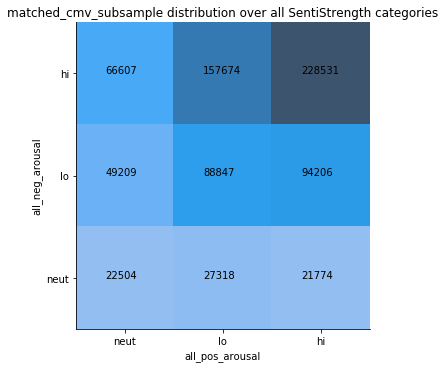

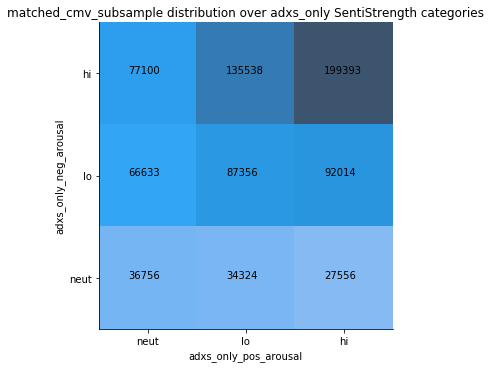

In [21]:
for corp_name in corp_to_analyze:
    if corp_name in {'matched_cc_cmv_subsample','gen_reddit','matched_cmv_subsample'}:
        to_plot_df = pd.DataFrame({
            'id': [utt.id for utt in corp_to_analyze[corp_name].iter_utterances()
                  if utt.meta['senti_all_arousal_cat']],
            'senti_all_arousal_cat':[utt.meta['senti_all_arousal_cat'] 
                                 for utt in corp_to_analyze[corp_name].iter_utterances()
                                 if utt.meta['senti_all_arousal_cat']],
            'senti_adxs_only_arousal_cat':[utt.meta['senti_adxs_only_arousal_cat'] 
                                 for utt in corp_to_analyze[corp_name].iter_utterances()
                                 if utt.meta['senti_all_arousal_cat']]
        })
        for senti_model in {'all','adxs_only'}:
            for i,val in enumerate(['pos','neg']):
                to_plot_df[f'{senti_model}_{val}_arousal'] = \
                to_plot_df[f'senti_{senti_model}_arousal_cat'].apply(
                    lambda x: x.split('_{}'.format(val))[0].split('_')[-1]
                )
                if i%2 == 1:
                    categories=['hi','lo','neut']
                else:
                    categories=['neut','lo','hi']
                to_plot_df[f'{senti_model}_{val}_arousal'] = \
                pd.Categorical(to_plot_df[f'{senti_model}_{val}_arousal'],
                               categories=categories,
                               ordered=True)

            ax = sns.displot(data=to_plot_df, 
                             x=f'{senti_model}_pos_arousal', 
                             y=f'{senti_model}_neg_arousal')
            x_locs, y_locs = ax.axes[0][0].get_xticks(), ax.axes[0][0].get_yticks()
            for p_i,pos_level in enumerate(['neut', 'lo', 'hi']):
                for n_i,neg_level in enumerate(['neut', 'lo', 'hi']):
                    plt.annotate(str(len(to_plot_df.loc[
                        (to_plot_df[f'{senti_model}_pos_arousal']==pos_level) &
                        (to_plot_df[f'{senti_model}_neg_arousal']==neg_level)])),
                        xy=(x_locs[p_i]-0.2,y_locs[2-n_i]))
            plt.title(f'{corp_name} distribution over {senti_model} SentiStrength categories')
            plt.savefig(f'figs/senti_dist_{corp_name}_{senti_model}.png',
                        dpi=150,bbox_inches="tight")

Examine temporal trend:

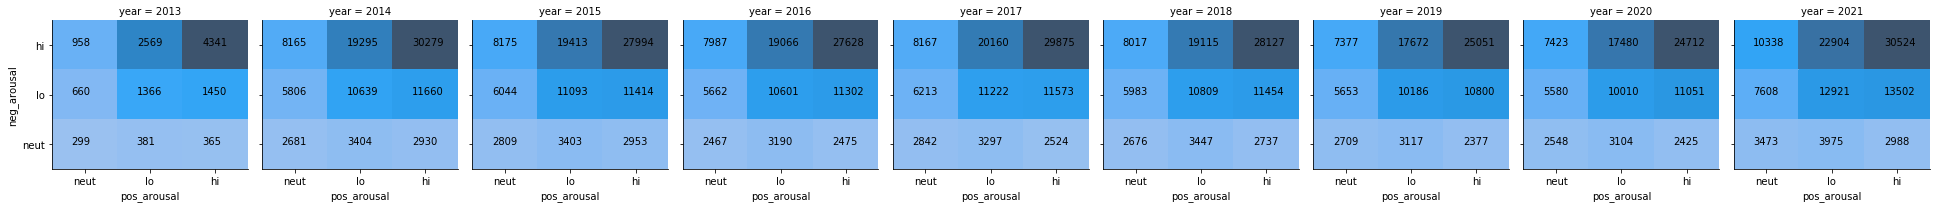

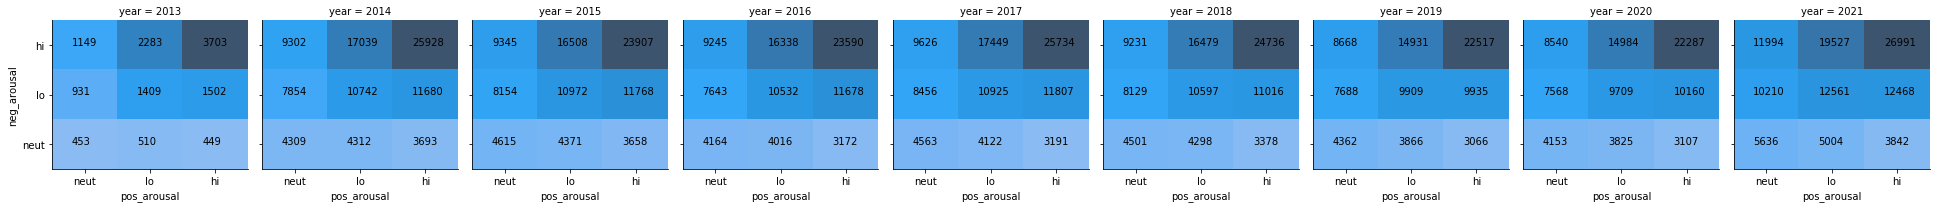

In [22]:
for corp_name in corp_to_analyze:
    if corp_name in {'matched_cc_cmv_subsample','gen_reddit','matched_cmv_subsample'}:

        years = list(range(2013,2022))
        topics = ['climate change','other']
        for senti_model in ['all','adxs_only']:
        #emotions = EMOLEX_EMOS
            df_year, df_topic = [], []
            df_id, df_contro, df_replies, df_score = [], [], [], []
            df_pos_arousal, df_neg_arousal = [], []
            for utt in corp_to_analyze[corp_name].iter_utterances():
                year = datetime.utcfromtimestamp(utt.timestamp).year
                topic = 'climate change' if ('is_cc_related' in utt.meta and utt.meta['is_cc_related']) else 'other'
                df_year.append(year)
                df_topic.append(topic)
                df_id.append(utt.id)
                contro = utt.meta['controversiality'] if 'controversiality' in utt.meta else None
                df_contro.append(contro)
                num_replies = len(utt.meta['reply_ids']) if 'reply_ids' in utt.meta else None
                df_replies.append(num_replies)
                df_score.append(utt.meta['score'])
                senti_cat = utt.meta[f'senti_{senti_model}_arousal_cat'] 
                if senti_cat is not None:
                    df_pos_arousal.append(senti_cat.split('_pos')[0].split('_')[-1])
                    df_neg_arousal.append(senti_cat.split('_neg')[0].split('_')[-1])
                else:
                    df_pos_arousal.append(None)
                    df_neg_arousal.append(None)
            to_plot_df = pd.DataFrame({
                'year':df_year,
                'topic':df_topic,
                'id':df_id,
                'contro':df_contro,
                'num_replies':df_replies,
                'score':df_score,
                'pos_arousal':df_pos_arousal,
                'neg_arousal':df_neg_arousal
            })
            for i,val in enumerate(['pos','neg']):
                if i%2 == 1:
                    categories=['hi','lo','neut']
                else:
                    categories=['neut','lo','hi']
                to_plot_df['{}_arousal'.format(val)] = pd.Categorical(
                                                          to_plot_df['{}_arousal'.format(val)],
                                                          categories=categories,
                                                          ordered=True)

            g = sns.FacetGrid(to_plot_df, col='year', aspect=1)
            g.map(sns.histplot, 'pos_arousal', 'neg_arousal')#, ci='sd')
            sns.despine()
            for i,col in enumerate(g.col_names):
                ax = g.axes.flat[i]
                x_locs, y_locs = ax.get_xticks(), ax.get_yticks()
                for p_i,pos_level in enumerate(['neut', 'lo', 'hi']):
                    for n_i,neg_level in enumerate(['neut', 'lo', 'hi']):
                        ax.annotate(str(len(to_plot_df.loc[(to_plot_df['year']==col) &
                                                           (to_plot_df['pos_arousal']==pos_level) &
                                                           (to_plot_df['neg_arousal']==neg_level)])),
                                    xy=(x_locs[p_i]-0.2,y_locs[2-n_i]))
            plt.savefig(f'figs/senti_dist_over_time_{corp_name}_{senti_model}.png',
                        dpi=150,bbox_inches="tight")

In [23]:
# # Why are there so many neut-neut comments in general Reddit?
# # Examine examples
# [utt.text for utt in corp_to_analyze['gen_reddit'].iter_utterances()
# if utt.meta['senti_arousal_cat'] == 'neut_neg_neut_pos'][:20]

In [24]:
# [utt.text for utt in corp_to_analyze['matched_cmv_subsample'].iter_utterances()
# if utt.meta['senti_arousal_cat'] == 'hi_neg_hi_pos'][:20]

### NRC

In [18]:
VAD = pd.read_csv('/u/scr/yiweil/datasets/NRC-VAD-Lexicon.txt',sep='\t',header=0)
VAD.head()

Word  Valence  Arousal  Dominance
0  aaaaaaah    0.479    0.606      0.291
1     aaaah    0.520    0.636      0.282
2  aardvark    0.427    0.490      0.437
3     aback    0.385    0.407      0.288
4    abacus    0.510    0.276      0.485

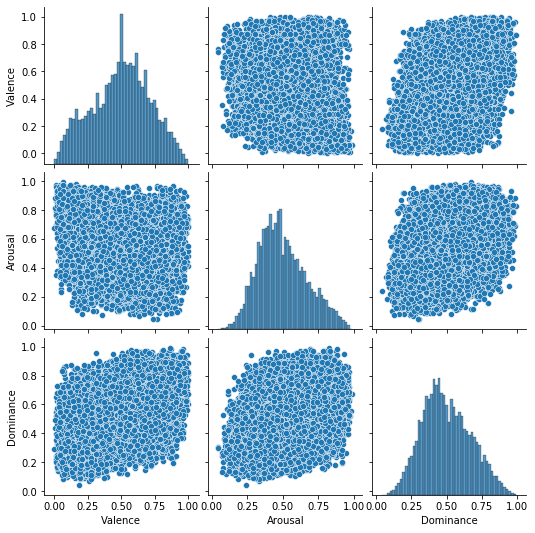

In [20]:
sns.pairplot(data=VAD)

In [19]:
# Create look-up dicts and function for computing NRC arousal

word2nrc_arousal = dict(zip(VAD['Word'],VAD['Arousal']))
word2nrc_valence = dict(zip(VAD['Word'],VAD['Valence']))

NRC_words_per_cat = defaultdict(list)
HI_AROUSAL_THRESH, LO_AROUSAL_THRESH = VAD['Arousal'].quantile(.75), VAD['Valence'].quantile(.25)
for w in tqdm(VAD['Word'].values):
    if word2nrc_arousal[w] >= HI_AROUSAL_THRESH \
    and word2nrc_valence[w] <= VAD['Valence'].quantile(.25):
        NRC_words_per_cat['hi_neg'].append(w)
    elif word2nrc_arousal[w] <= LO_AROUSAL_THRESH \
    and word2nrc_valence[w] <= VAD['Valence'].quantile(.25):
        NRC_words_per_cat['lo_neg'].append(w)
    elif word2nrc_arousal[w] <= LO_AROUSAL_THRESH \
    and word2nrc_valence[w] >= VAD['Valence'].quantile(.75):
        NRC_words_per_cat['lo_pos'].append(w)
    elif word2nrc_arousal[w] >= HI_AROUSAL_THRESH \
    and word2nrc_valence[w] >= VAD['Valence'].quantile(.75):
        NRC_words_per_cat['hi_pos'].append(w)
    else:
        NRC_words_per_cat['neut'].append(w)
        
NRC_words_per_cat = {cat: set(NRC_words_per_cat[cat]) for cat in NRC_words_per_cat}

word2NRC_cat = {}
for cat in NRC_words_per_cat:
    word2NRC_cat.update({w: cat for w in NRC_words_per_cat[cat]})
    
def get_nrc_arousal_cat(utt_lemmas,utt_id,cache_dict=None,verbose=False):
    if not cache_dict:
        val_lemms = [lemm for lemm in utt_lemmas if lemm in word2nrc_valence]
        if len(val_lemms) > 0:
            valence_norm = sum([word2nrc_valence[lemm] 
                            for lemm in val_lemms])/len(val_lemms)
            arousal_lemms = [lemm for lemm in utt_lemmas if lemm in word2nrc_arousal]
            arousal_norm = sum([word2nrc_arousal[lemm] 
                               for lemm in arousal_lemms])/len(arousal_lemms)
            if verbose:
                print(val_lemms)
                print(arousal_lemms)

            if arousal_norm >= VAD['Arousal'].quantile(.50):
                if valence_norm >= VAD['Valence'].quantile(.5):
                    return 'hi_pos'
                else:
                    return 'hi_neg'
            elif arousal_norm < VAD['Arousal'].quantile(.50) \
            and arousal_norm >= VAD['Arousal'].quantile(.25):
                if valence_norm >= VAD['Valence'].quantile(.5):
                    return 'lo_pos'
                else:
                    return 'lo_neg'
            else:
                return 'neut'
        return None
    else:
        return cache_dict[utt_id]

100%|██████████| 20007/20007 [00:18<00:00, 1105.32it/s]


In [ ]:
#NRC_words_per_cat['hi_neg']

In [ ]:
#NRC_words_per_cat['lo_neg']

In [ ]:
#NRC_words_per_cat['hi_pos']

In [ ]:
#NRC_words_per_cat['lo_pos']

In [21]:
# Assign NRC arousal categories 
for corp_name in corp_to_analyze:
    if corp_name in {'matched_cmv_subsample','matched_cc_cmv_subsample'}:
        vad_cache = pickle.load(open(f'VAD_scores_{corp_name}.pkl','rb'))
        for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
            vad_score = get_nrc_arousal_cat(None,utt.id,cache_dict=vad_cache)
            utt.meta['nrc_all_arousal_cat'] = vad_score['all']
            utt.meta['nrc_adxs_only_arousal_cat'] = vad_score['adxs_only']
            #break

756789it [00:07, 99482.51it/s] 


In [30]:
# # One time: create cache 
# vad_cache = defaultdict(dict)
# for corp_name in corp_to_analyze:
#     for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
#         vad_cache[utt.id]['all'] = utt.meta['nrc_all_arousal_cat']
#         vad_cache[utt.id]['adxs_only'] = utt.meta['nrc_adxs_only_arousal_cat']
#     pickle.dump(vad_cache,open(f'VAD_scores_{corp_name}.pkl','wb'))

756789it [00:03, 217946.28it/s]


### Compare SentiStrength categories to VAD categories

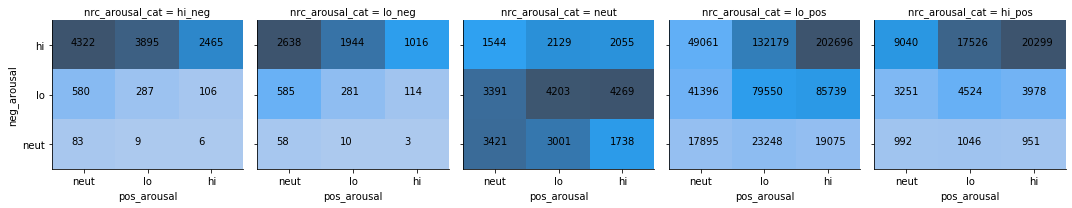

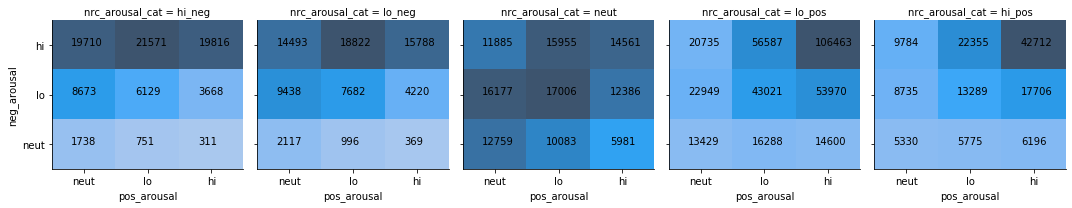

In [37]:
for corp_name in corp_to_analyze:
    if corp_name in {'matched_cmv_subsample','matched_cc_cmv_subsample'}:
        for model_name in ['all','adxs_only']:
            to_plot_df = pd.DataFrame({
                'id': [utt.id for utt in corp_to_analyze[corp_name].iter_utterances()
                      if utt.meta[f'senti_{model_name}_arousal_cat'] 
                      and f'nrc_{model_name}_arousal_cat' in utt.meta 
                      and utt.meta[f'nrc_{model_name}_arousal_cat']],
                'senti_arousal_cat':[utt.meta[f'senti_{model_name}_arousal_cat'] 
                                     for utt in corp_to_analyze[corp_name].iter_utterances()
                                     if utt.meta[f'senti_{model_name}_arousal_cat'] 
                                     and f'nrc_{model_name}_arousal_cat' in utt.meta 
                                     and utt.meta[f'nrc_{model_name}_arousal_cat']],
                'nrc_arousal_cat':[utt.meta[f'nrc_{model_name}_arousal_cat'] 
                                     for utt in corp_to_analyze[corp_name].iter_utterances()
                                     if utt.meta[f'senti_{model_name}_arousal_cat'] 
                                     and f'nrc_{model_name}_arousal_cat' in utt.meta 
                                     and utt.meta[f'nrc_{model_name}_arousal_cat']]})
            for i,val in enumerate(['pos','neg']):
                to_plot_df['{}_arousal'.format(val)] = \
                to_plot_df[f'senti_arousal_cat'].apply(
                    lambda x: x.split('_{}'.format(val))[0].split('_')[-1]
                )
                if i%2 == 1:
                    categories=['hi','lo','neut']
                else:
                    categories=['neut','lo','hi']
                to_plot_df['{}_arousal'.format(val)] = pd.Categorical(
                                                          to_plot_df['{}_arousal'.format(val)],
                                                          categories=categories,
                                                          ordered=True)

            g = sns.FacetGrid(to_plot_df, col='nrc_arousal_cat', 
                              col_order=['hi_neg','lo_neg','neut','lo_pos','hi_pos'])
            g.map(sns.histplot, 'pos_arousal', 'neg_arousal')
            for i,col in enumerate(['hi_neg','lo_neg','neut','lo_pos','hi_pos']):
                ax = g.axes.flat[i]
                x_locs, y_locs = ax.get_xticks(), ax.get_yticks()
                for p_i,pos_level in enumerate(['neut', 'lo', 'hi']):
                    for n_i,neg_level in enumerate(['neut', 'lo', 'hi']):
                        ax.annotate(str(len(to_plot_df.loc[(to_plot_df['nrc_arousal_cat']==col) &
                                                           (to_plot_df['pos_arousal']==pos_level) &
                                                           (to_plot_df['neg_arousal']==neg_level)])),
                                    xy=(x_locs[p_i]-0.2,y_locs[2-n_i]))
        #     plt.title('{} distribution over SentiStrength categories per VAD category'.format(
        #         corp_name))
            plt.savefig(f'figs/senti_dist_and_vad_dist_{corp_name}_{model_name}.png',
                         dpi=150,bbox_inches="tight")

Comments receiving `hi_neg` NRC label but `hi_pos_lo_neg` SentiStrength label:

In [115]:
mismatch_ids = to_plot_df.loc[(to_plot_df['nrc_arousal_cat']=='hi_neg') &
                              (to_plot_df['senti_arousal_cat']=='hi_pos_lo_neg')]\
['id'].values
pd.DataFrame([corp_to_analyze[corp_name].get_utterance(i).text for i in mismatch_ids])

0
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   The existence of Global Warming is considered a political issue in very few countries. Really only the US.\n\nWhy is that?\n\nIn 2006, Al Gore helped to make the movie "An Inconvenient Truth." The opening line of this film is "'Hi, I'm Al Gore, I used to be the next president of the United States of America." By opening the film in this manner, Mr. Gore *immediately* politicized the issue. I don't agree with the fact that it did, but that's the unfortunate truth.\n\n\nIf you're talking about the US and only the US, then there's some truth to this as we've politicized the issue of global warming (even though the IPCC has officially stated that it's happening and caused by humans.) If your talking about other countries, then I don't think this is true simply because global warming isn't a political issue. So, please clarify, is this US specific or not?\n\nSource: Attendance of Multiple Lectures by IPCC memebers
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             Just because a source has not got a good track record does not mean they are permanently doomed to being wrong forever. Second, a prediction is only proved when it comes true. Just because it has not come true yet doesn't mean it never will. What you demand from these organisations is that they knew what they were talking about 5 years ago, when there is every chance they are working on more robust science since then. Regardless of this, your post claims it is unprovable. They are, of course, all provable, they just haven't been proved yet. \n\nInstead I put it to you, that you cannot prove that anthropocentric climate change being catastrophic cannot be proven, and your point of view is therefore redundant. I however, can prove that it is provable. It is instantly proved, when any one of the models that claims it will be catastrophic is proved correct
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                First time commenting on one of these, your opinion actually makes a lot of sense to me. Developing economies need these co2 emitting resources; however, there is no need for developed nations to still be using them. While there are definite pluses for having more CO2 in the air there are still many negatives! Pollution, contamination, CO2 levels in the ocean, acid rain, smog, and

Comments receiving `hi_pos` NRC label but `hi_neg_neut_pos` or `hi_neg_lo_pos` SentiStrength label:

In [28]:
# mismatch_ids = to_plot_df.loc[(to_plot_df['nrc_arousal_cat']=='hi_pos') &
#                               (to_plot_df['senti_arousal_cat'].isin({'hi_neg_neut_pos',
#                                                                      'hi_neg_lo_pos'}))]\
# ['id'].values
# pd.DataFrame([corp_to_analyze[corp_name].get_utterance(i).text for i in mismatch_ids])

## Emotions

### EmoLex

In [22]:
BLACKLIST_WORDS = {'shit','shitty','fuck','crap','crappy','gore','trump','tree','sun','soil','shanghai','john',
                  'desert','turn','earthquake','lightning','hurricane','cyclone','tornado','storm','wildfire',
                  'fire','cool','warm','hot','human','earth','planet','global','climate','change','cold'}

In [23]:
PATH_TO_EMOLEX = "/u/scr/yiweil/datasets/NRC-Emotion-Intensity-Lexicon-v1.txt"
EMOLEX = pd.read_csv(PATH_TO_EMOLEX,sep='\t')
EMOLEX = EMOLEX.loc[~EMOLEX['word'].isin(BLACKLIST_WORDS)]
EMOLEX_EMOS = EMOLEX['emotion'].value_counts().index
print(EMOLEX.head())

print(EMOLEX[
    'emotion'
].value_counts())

        word emotion  emotion-intensity-score
0   outraged   anger                    0.964
1  brutality   anger                    0.959
2     hatred   anger                    0.953
3    hateful   anger                    0.940
4  terrorize   anger                    0.939
fear            1754
trust           1562
anger           1475
sadness         1292
joy             1265
disgust         1085
anticipation     862
surprise         578
Name: emotion, dtype: int64


In [ ]:
# # Why is trust higher than the rest?
# EMOLEX.loc[(EMOLEX['emotion']=='trust') & 
#           (EMOLEX['emotion-intensity-score']>0.5)].word.values

In [25]:
# Create look-up dicts and function for computing Emolex scores

word2emolex_score = defaultdict(dict)
for _,row in EMOLEX.iterrows():
    word, emotion, score = row['word'], row['emotion'], row['emotion-intensity-score']
    word2emolex_score[word][emotion] = score
    
def get_emolex_scores(utt,utt_id,json_dir,cache_dict=None,verbose=False):
    if not cache_dict:
        json_obj = get_stanza_json(utt)
        if json_obj:
            utt_lemmas = [x['lemma'] for sent in json_obj['parse'] for x in sent]
            utt_adxs = [x['lemma'] for sent in json_obj['parse'] for x in sent if x['upos'] in {'ADJ','ADV'}]
            emo_lemms = [lemm for lemm in utt_lemmas if lemm in word2emolex_score]
            emo_adxs = [lemm for lemm in utt_adxs if lemm in word2emolex_score]
            if verbose:
                print(emo_lemms)
                print(emo_adxs)

            emo_norms = defaultdict(dict)
            if len(emo_lemms) > 0:
                for emo in EMOLEX_EMOS:
                    emo_norm = sum([word2emolex_score[lemm][emo]
                                    for lemm in emo_lemms
                                    if emo in word2emolex_score[lemm]])/len(emo_lemms)
                    emo_norms['all'][emo] = emo_norm
            if len(emo_adxs) > 0:
                for emo in EMOLEX_EMOS:
                    emo_norm = sum([word2emolex_score[lemm][emo]
                                    for lemm in emo_adxs
                                    if emo in word2emolex_score[lemm]])/len(emo_adxs)
                    emo_norms['adxs_only'][emo] = emo_norm
            return emo_norms
        return {}
    else:
        return cache_dict[utt_id]

In [42]:
utt.text

'We actually don’t have many Mac apples around me, so I don’t have strong opinions on it.\n\nBut when I saw the Red Delicious is the lowest common denominator of apples, I mean that in terms of its actual place in the market.   It literally was bred to be the generic “apple” that you can find in any free fruit basket, crappy school and hospital cafeteria, etc.   It’s the mass market product of late 20th century American industrial agriculture.\n\nThe original cultivar of the apple was apparently quite good, which is why it became popular.  And I’m sure if you get some good red delicious apples today that they are from sources closer to those original trees.\n\nBut around the ‘40s and ‘50s, as our food supply chains industrialized, farmers started selecting for strains that were more consistently deep red, because those were the easiest to market, that had thick skins, because those could be more easily shipped, and that had high yields, because those grew more cheaply.   Taste and text

In [44]:
get_emolex_scores(utt,utt.id,STANZA_DIR,verbose=True)

['strong', 'free', 'school', 'hospital', 'late', 'good', 'popular', 'good', 'delicious', 'food', 'start', 'ship', 'grow', 'result', 'delicious', 'dominate', 'bad', 'bottom', 'fall', 'delicious', 'government', 'production', 'delicious', 'grow', 'good', 'good', 'reliable', 'delicious']
['strong', 'free', 'late', 'good', 'popular', 'good', 'delicious', 'delicious', 'bad', 'delicious', 'delicious', 'good', 'good', 'reliable', 'delicious']


defaultdict(dict,
            {'all': {'fear': 0.05914285714285714,
              'trust': 0.23260714285714287,
              'anger': 0.03403571428571429,
              'sadness': 0.05971428571428572,
              'joy': 0.22746428571428567,
              'disgust': 0.013964285714285716,
              'anticipation': 0.1727857142857143,
              'surprise': 0.04357142857142856},
             'adxs_only': {'fear': 0.025,
              'trust': 0.27540000000000003,
              'anger': 0.030199999999999998,
              'sadness': 0.03646666666666667,
              'joy': 0.37513333333333326,
              'disgust': 0.02606666666666667,
              'anticipation': 0.10213333333333333,
              'surprise': 0.058399999999999994}})

In [48]:
# # One time: create cache
# for corp_name in corp_to_analyze:
#     if corp_name in {'matched_cmv_subsample','matched_cc_cmv_subsample'}:
#         emolex_cache = defaultdict(dict)
#         for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
#             scores = get_emolex_scores(utt,utt.id,STANZA_DIR)
#             if len(scores) > 0:
#                 for emo in EMOLEX_EMOS:
#                     for model_name in scores:
#                         utt.meta[f'emolex_{model_name}_{emo}'] = scores[model_name][emo]
#                         emolex_cache[utt.id][f'{model_name}_{emo}'] = scores[model_name][emo]
#         pickle.dump(emolex_cache,open(f'emolex_cache_{corp_name}.pkl','wb'))

756789it [28:50, 437.41it/s]


In [26]:
# Get Emolex scores for corpora that are stanza-parsed
for corp_name in corp_to_analyze:
    if corp_name in {'matched_cmv_subsample','matched_cc_cmv_subsample'}:
        emolex_cache = pickle.load(open(f'emolex_cache_{corp_name}.pkl','rb'))
        for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
            scores = get_emolex_scores(utt,utt.id,STANZA_DIR,cache_dict=emolex_cache)
            if len(scores) > 0:
                for emo in EMOLEX_EMOS:
                    for model_name in ['all','adxs_only']:
                        if f'{model_name}_{emo}' in scores:
                            utt.meta[f'emolex_{model_name}_{emo}'] = scores[f'{model_name}_{emo}']

756789it [01:05, 11557.13it/s]


Examine temporal trend:

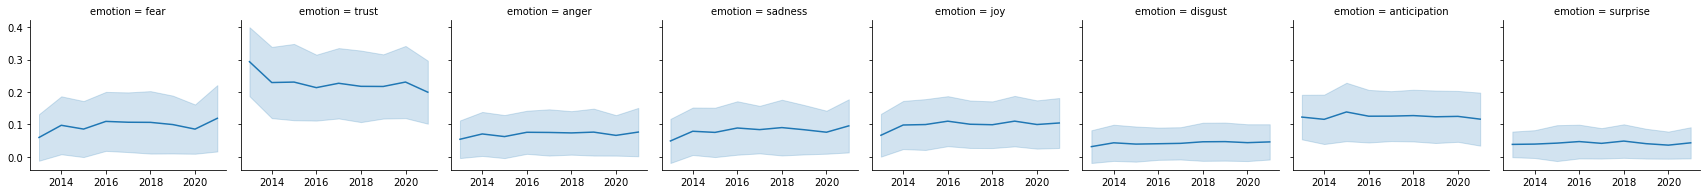

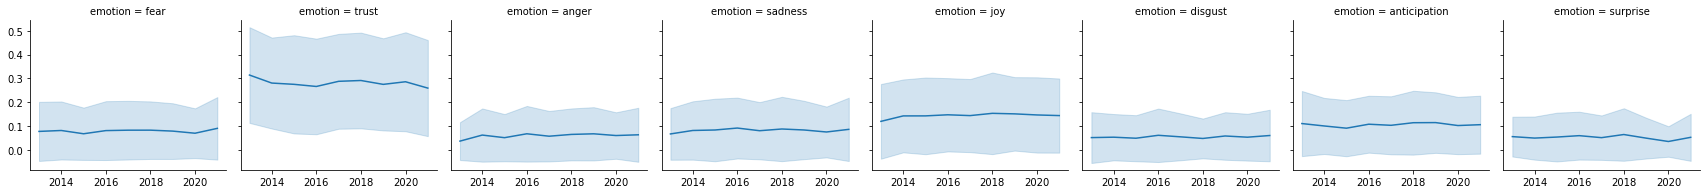

In [133]:
for corp_name in ['matched_cc_cmv_subsample']:#corp_to_analyze:

    years = list(range(2013,2022))
    topics = ['climate change','other']
    emotions = EMOLEX_EMOS
    for model_name in ['all','adxs_only']:
        df_year, df_topic, df_emo, df_emoscore = [], [], [], []
        df_id, df_contro, df_replies, df_score = [], [], [], []
        df_nrc_arousal, df_pos_arousal, df_neg_arousal = [], [], []
        df_delta = []
        for utt in corp_to_analyze[corp_name].iter_utterances():
            year = datetime.utcfromtimestamp(utt.timestamp).year
            topic = 'climate change' if utt.meta['is_cc_related'] else 'other'
            for key in utt.meta.keys():
                if key.startswith(f'emolex_{model_name}'):
                    emo = key.split('_')[-1]
                    score = utt.meta[f'emolex_{model_name}_{emo}']
                    df_year.append(year)
                    df_topic.append(topic)
                    df_emo.append(emo)
                    df_emoscore.append(score)
                    df_id.append(utt.id)
                    df_contro.append(utt.meta['controversiality'])
                    df_replies.append(len(utt.meta['reply_ids']))
                    df_score.append(utt.meta['score'])
                    df_nrc_arousal.append(utt.meta[f'nrc_{model_name}_arousal_cat'])
                    senti_cat = utt.meta[f'senti_{model_name}_arousal_cat']
                    df_pos_arousal.append(senti_cat.split('_pos')[0].split('_')[-1])
                    df_neg_arousal.append(senti_cat.split('_neg')[0].split('_')[-1])
                    df_delta.append(utt.meta['is_awarded_delta'])
        to_plot_df = pd.DataFrame({
            'year':df_year,
            'topic':df_topic,
            'emotion':df_emo,
            'emoscore':df_emoscore,
            'id':df_id,
            'contro':df_contro,
            'num_replies':df_replies,
            'score':df_score,
            'nrc_arousal':df_nrc_arousal,
            'pos_arousal':df_pos_arousal,
            'neg_arousal':df_neg_arousal,
            'is_awarded_delta':df_delta
        })
        for i,val in enumerate(['pos','neg']):
            if i%2 == 1:
                categories=['hi','lo','neut']
            else:
                categories=['neut','lo','hi']
            to_plot_df['{}_arousal'.format(val)] = pd.Categorical(
                                                      to_plot_df['{}_arousal'.format(val)],
                                                      categories=categories,
                                                      ordered=True)
        plt.rcParams['figure.figsize'] = [10, 5]
        g = sns.FacetGrid(to_plot_df, col='emotion', aspect=1)
        g.map(sns.lineplot, 'year', 'emoscore', ci='sd')
        sns.despine()
        for ax in g.axes[0]:
            ax.set_xlabel('')
            ax.set_ylabel('')
        plt.savefig(f'figs/emolex_scores_over_time_{corp_name}_{model_name}.png',
                    dpi=200,bbox_inches="tight")

Examine other correlations:

Engagement-related correlations:

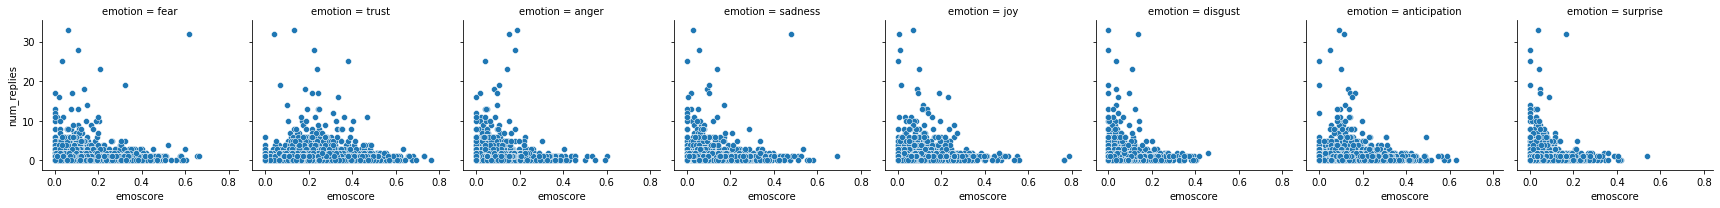

In [209]:
g = sns.FacetGrid(to_plot_df, col='emotion')
g.map(sns.scatterplot,'emoscore','num_replies')
# for ax in g.axes[0]:
#     ax.set_yscale('log')

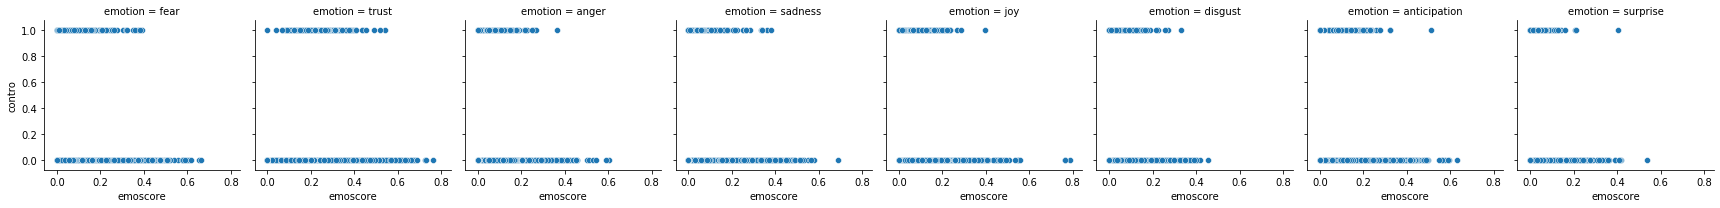

In [210]:
g = sns.FacetGrid(to_plot_df, col='emotion')
g.map(sns.scatterplot,'emoscore','contro')

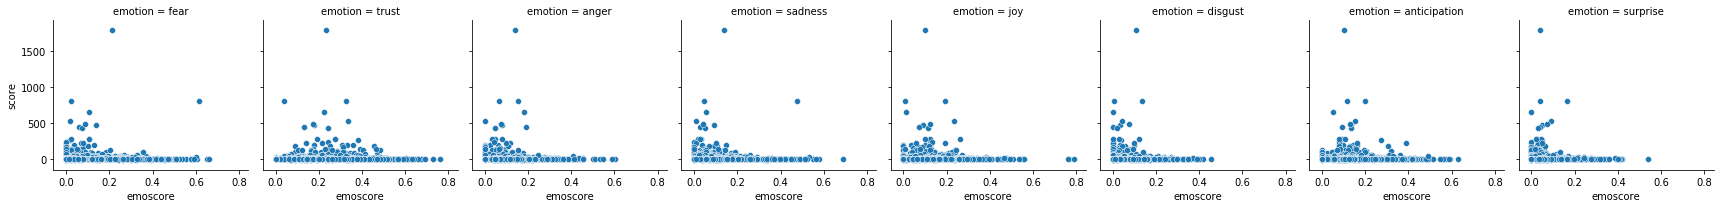

In [211]:
g = sns.FacetGrid(to_plot_df, col='emotion')
g.map(sns.scatterplot,'emoscore','score')

Arousal correlations:

In [38]:
for corp_name in corp_to_analyze:
    for model_name in ['all','adxs_only']:
        df_year, df_topic, df_emo, df_emoscore = [], [], [], []
        df_id, df_contro, df_replies, df_score = [], [], [], []
        df_nrc_arousal, df_pos_arousal, df_neg_arousal = [], [], []
        df_delta = []
        for utt in corp_to_analyze[corp_name].iter_utterances():
            if utt.id[:2] != 't3':
                year = datetime.utcfromtimestamp(utt.timestamp).year
                topic = 'climate change' if utt.meta['is_cc_related'] else 'other'
                for key in utt.meta.keys():
                    if key.startswith(f'emolex_{model_name}'):
                        emo = key.split('_')[-1]
                        score = utt.meta[f'emolex_{model_name}_{emo}']
                        df_year.append(year)
                        df_topic.append(topic)
                        df_emo.append(emo)
                        df_emoscore.append(score)
                        df_id.append(utt.id)
                        df_contro.append(utt.meta['controversiality'])
                        df_replies.append(len(utt.meta['reply_ids']))
                        df_score.append(utt.meta['score'])
                        df_nrc_arousal.append(utt.meta[f'nrc_{model_name}_arousal_cat'])
                        senti_cat = utt.meta[f'senti_{model_name}_arousal_cat']
                        df_pos_arousal.append(senti_cat.split('_pos')[0].split('_')[-1])
                        df_neg_arousal.append(senti_cat.split('_neg')[0].split('_')[-1])
                        df_delta.append(utt.meta['is_awarded_delta'])
        to_plot_df = pd.DataFrame({
            'year':df_year,
            'topic':df_topic,
            'emotion':df_emo,
            'emoscore':df_emoscore,
            'id':df_id,
            'contro':df_contro,
            'num_replies':df_replies,
            'score':df_score,
            'nrc_arousal':df_nrc_arousal,
            'pos_arousal':df_pos_arousal,
            'neg_arousal':df_neg_arousal,
            'is_awarded_delta':df_delta
        })
        for i,val in enumerate(['pos','neg']):
            if i%2 == 1:
                categories=['hi','lo','neut']
            else:
                categories=['neut','lo','hi']
            to_plot_df['{}_arousal'.format(val)] = pd.Categorical(
                                                      to_plot_df['{}_arousal'.format(val)],
                                                      categories=categories,
                                                      ordered=True)
    
        g = sns.FacetGrid(to_plot_df, col=f'nrc_arousal', 
                          col_order=['hi_neg','lo_neg','neut','lo_pos','hi_pos'])
        g.map(sns.barplot, 'emotion', 'emoscore', order=EMOLEX_EMOS)

        # Aesthetics & saving
        for ax_ix,ax in enumerate(g.axes[0]):
            if ax_ix == 0:
                ax.set_ylabel('Emotion intensity score',fontsize=24)
            ax.set_title(ax.title._text.split('= ')[-1],fontsize=22)
            ax.set_xticklabels(ax.get_xticklabels(),rotation=90,fontsize=20)
            ax.set_xlabel('')
        plt.savefig(f'figs/emolex_dist_and_vad_dist_{corp_name}_{model_name}.png',
                     dpi=150,bbox_inches="tight")

KeyboardInterrupt: 

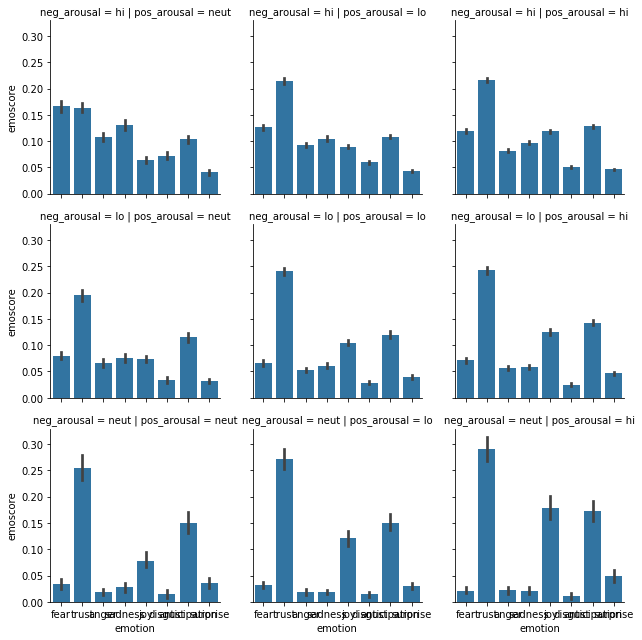

In [200]:
for corp_name in corp_to_analyze:
    
    g = sns.FacetGrid(to_plot_df, col='pos_arousal', row='neg_arousal',
                      col_order=['neut','lo','hi'], row_order=['hi','lo','neut'])
    g.map(sns.barplot, 'emotion', 'emoscore', order=EMOLEX_EMOS)
    
#     # Aesthetics & saving
#     for ax_ix,ax in enumerate(g.axes[0]):
#         if ax_ix == 0:
#             ax.set_ylabel('Emotion intensity score',fontsize=24)
#         ax.set_title(ax.title._text.split('= ')[-1],fontsize=22)
#         ax.set_xticklabels(ax.get_xticklabels(),rotation=90,fontsize=20)
#         ax.set_xlabel('')
#     plt.savefig('figs/emolex_dist_and_senti_dist_{}.png'.format(corp_name),
#                  dpi=150,bbox_inches="tight")

## People

In [41]:
def get_ents(utt,json_dir,verbose=False):
    json_obj = get_stanza_json(utt)
    if json_obj is not None:
        ents = [(x['text'],x['type']) for x in json_obj['ents']]
        return ents
    else:
        return []

In [281]:
# Extract people
for corp_name in ['matched_cc_cmv_subsample']:#corp_to_analyze:
    if corp_name in {'matched_cc_cmv_subsample','matched_cmv_subsample'}:
        all_corp_ents = []
        for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
            if utt.id[:2] != 't3':
                utt_ents = get_ents(utt,STANZA_DIR)
                all_corp_ents.extend(utt_ents)
                utt.meta['people'] = [e[0] for e in utt_ents if e[1]=='PERSON']

6349it [00:13, 465.89it/s]


First, examine most commonly mentioned NEs:

In [282]:
print(sorted(Counter([x for x in all_corp_ents if x[1] not in {'DATE','CARDINAL','ORDINAL','PERCENT'}]).items(), 
       key=lambda x: x[1], reverse=True)[:100])
del all_corp_ents

[(('US', 'GPE'), 738), (('Earth', 'LOC'), 642), (('China', 'GPE'), 602), (('Trump', 'PERSON'), 175), (('India', 'GPE'), 174), (('IPCC', 'ORG'), 160), (('American', 'NORP'), 155), (('America', 'GPE'), 145), (('Europe', 'LOC'), 139), (('Republicans', 'NORP'), 130), (('Canada', 'GPE'), 116), (('USA', 'GPE'), 108), (('Americans', 'NORP'), 95), (('NASA', 'ORG'), 92), (('California', 'GPE'), 89), (('Democrats', 'NORP'), 83), (('Russia', 'GPE'), 83), (('the United States', 'GPE'), 79), (('Africa', 'LOC'), 74), (('Chinese', 'NORP'), 73), (('U.S.', 'GPE'), 71), (('republicans', 'NORP'), 65), (('Australia', 'GPE'), 57), (('UK', 'GPE'), 57), (('earth', 'LOC'), 56), (('EPA', 'ORG'), 51), (('Republican', 'NORP'), 50), (('Al Gore', 'PERSON'), 48), (('Tesla', 'ORG'), 46), (('Venus', 'LOC'), 45), (('Paris', 'GPE'), 45), (('Obama', 'PERSON'), 44), (('Germany', 'GPE'), 42), (('EU', 'ORG'), 41), (('Florida', 'GPE'), 40), (('Bible', 'WORK_OF_ART'), 40), (('OP', 'ORG'), 40), (('France', 'GPE'), 39), (('GM'

Examine most commonly mentioned people:

In [355]:
counted_people = Counter([item for sublist in 
                         [utt.meta['people'] for utt in corp_to_analyze['matched_cc_cmv_subsample'].iter_utterances()
                         if utt.id[:2] != 't3' and utt.meta['is_awarded_delta']]
                         for item in sublist
                         ])
sorted(counted_people.items(),key=lambda x: x[1],reverse=True)[:100]

[('Trump', 10),
 ('Greta', 4),
 ('Joe', 3),
 ('Al Gore', 3),
 ('Broecker', 2),
 ('E. Calvo', 2),
 ('M.T. McCulloch', 2),
 ('J.F. Marshall', 2),
 ('M.K. Gagan', 2),
 ('J.M. Lough', 2),
 ('B.N. Opdyke', 2),
 ('Iris', 2),
 ('Lindzen', 2),
 ('Clinton', 2),
 ('Bill Nye', 2),
 ("Al Gore's", 2),
 ('Greta Thunberg', 2),
 ('Donald Trump', 2),
 ('Simon', 2),
 ('Joe Smuch', 1),
 ('Ruddiman', 1),
 ('S.E. Wijffels', 1),
 ('R.J. Matear', 1),
 ('Occam', 1),
 ('Spencer', 1),
 ('Hadley Cells', 1),
 ('W Bush', 1),
 ('Biden', 1),
 ('Matt Yglesias', 1),
 ('Linuxmoose5000', 1),
 ('Manchin', 1),
 ('Dunning-Kruger', 1),
 ('Brooks', 1),
 ('The Bill Gates', 1),
 ('Sandy', 1),
 ('Lenin', 1),
 ('Milankovitch', 1),
 ('Saharan Summers', 1),
 ('Robert Mugabe', 1),
 ('McCulloch', 1),
 ('Nick Bostrom', 1),
 ('Bostrom', 1),
 ('Erwin', 1),
 ('Utah Phillips', 1),
 ('BILL NYE', 1),
 ('Bruce Willis', 1),
 ('Cook', 1),
 ('Cooks', 1),
 ('Tucker Carlson', 1),
 ('Tucker', 1),
 ('Bill', 1),
 ('Jim Skea', 1),
 ('Mitch McConnell

Examine temporal trend:

756789it [00:04, 185943.28it/s]


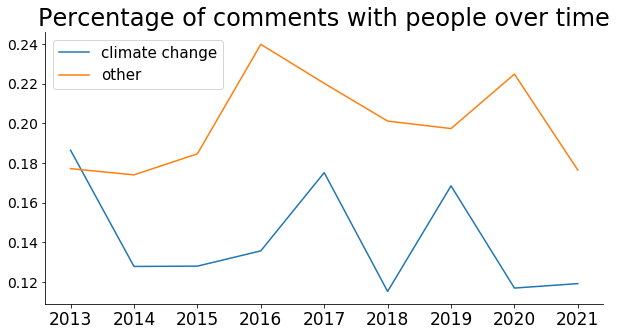

In [49]:
for corp_name in corp_to_analyze:
    counts_by_bin = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))

    for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
        if utt.timestamp and utt.id[:2] != 't3':
            year = datetime.utcfromtimestamp(utt.timestamp).year
            if utt.meta['is_cc_related']:
                if len(utt.meta['people'])>0:
                    counts_by_bin[year]['climate change']['has person'] += 1
                else:
                    counts_by_bin[year]['climate change']['no person'] += 1
            else:
                if len(utt.meta['people'])>0:
                    counts_by_bin[year]['other']['has person'] += 1
                else:
                    counts_by_bin[year]['other']['no person'] += 1

    years = list(range(2013,2022))
    topics = ['climate change','other']
    classes = ['has person','no person']
    to_plot_df = pd.DataFrame({
        'year':[item for sublist in 
                [[y]*len(topics)*len(classes) for y in years]
                for item in sublist],
        'topic':[item for sublist in 
                [[t]*len(classes) for t in topics]
                for item in sublist]*len(years),
        'class':classes*len(years)*len(topics),
        'count':[counts_by_bin[y][t][c] for y in years for t in topics for c in classes] 
    })

    per_year_topic_totals = to_plot_df.groupby(['year','topic']).sum()
    to_plot_df['percent'] = to_plot_df.apply(
        lambda x: x['count']/per_year_topic_totals.loc[x['year']]\
                            .loc[x['topic']]['count'],
        axis=1
    )

    plt.rcParams['figure.figsize'] = [10, 5]
    sns.lineplot(data=to_plot_df.loc[to_plot_df['class']=='has person'],
               x='year',y='percent',hue='topic',ci='sd')
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks(fontsize=17)
    plt.yticks(fontsize=14)
    plt.title('Percentage of comments with people over time',fontsize=24)
    plt.legend(title='',fontsize=15)
    sns.despine()
    plt.savefig('figs/pct_comments_with_people_over_time_{}.png'.format(corp_name),
                dpi=200,bbox_inches="tight")

Examine correlation with other comment properties:

In [50]:
for corp_name in corp_to_analyze:

    people_df = pd.DataFrame({
        'id':[utt.id
             for utt in corp_to_analyze[corp_name].iter_utterances()
             if utt.id[:2] != 't3'],
        'has_person':[len(utt.meta['people'])>0 
                      for utt in corp_to_analyze[corp_name].iter_utterances()
                     if utt.id[:2] != 't3'],
        'num_people':[len(utt.meta['people']) 
                      for utt in corp_to_analyze[corp_name].iter_utterances()
                     if utt.id[:2] != 't3'],
        'year':[datetime.utcfromtimestamp(utt.timestamp).year 
                for utt in corp_to_analyze[corp_name].iter_utterances()
               if utt.id[:2] != 't3'],
        'controversiality':[utt.meta['controversiality'] 
                            for utt in corp_to_analyze[corp_name].iter_utterances()
                           if utt.id[:2] != 't3'],
        'num_replies':[len(utt.meta['reply_ids'])
                       for utt in corp_to_analyze[corp_name].iter_utterances()
                      if utt.id[:2] != 't3'],
        'score':[utt.meta['score']
                 for utt in corp_to_analyze[corp_name].iter_utterances()
                if utt.id[:2] != 't3']
    })

    people_df.head()

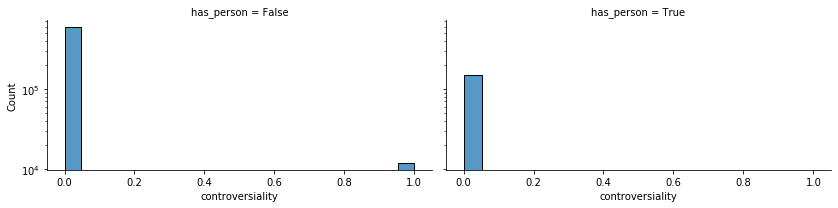

In [51]:
g = sns.FacetGrid(people_df, col='has_person', aspect=2)
g.map(sns.histplot, "controversiality")#, log_scale=True)
g.axes[0][0].set_yscale('log')
g.axes[0][1].set_yscale('log')

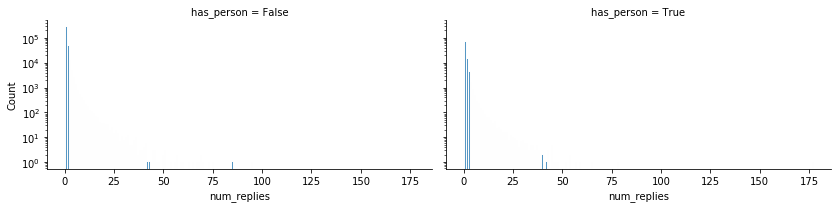

In [52]:
g = sns.FacetGrid(people_df, col='has_person', aspect=2)
g.map(sns.histplot, "num_replies")#, log_scale=True)
g.axes[0][0].set_yscale('log')
g.axes[0][1].set_yscale('log')

In [54]:
g = sns.FacetGrid(people_df, col='has_person', aspect=2)
g.map(sns.histplot, "score")#, log_scale=True)
g.axes[0][0].set_yscale('log')
g.axes[0][1].set_yscale('log')

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f475d53c510> (for post_execute):


KeyboardInterrupt: 

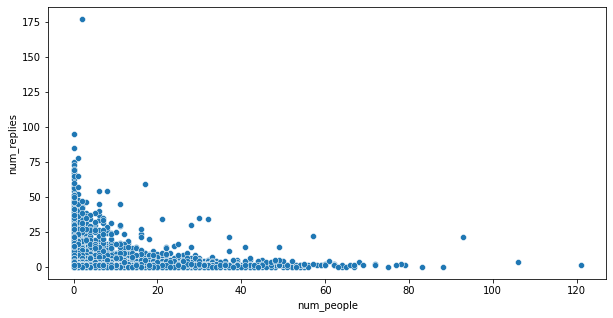

In [55]:
sns.scatterplot(data=people_df,x="num_people",y="num_replies")

In [173]:
#sns.scatterplot(data=people_df,x="num_people",y="controversiality")

In [174]:
#ax = sns.scatterplot(data=people_df,x="num_people",y="score")

### old--before stanza processing

In [21]:
NE_stance_dict = pd.read_pickle('/u/scr/yiweil/GWStance/4_analyses/NE_stance_dict.pkl')
NE_fuzzy_map = pd.read_pickle('/u/scr/yiweil/GWStance/4_analyses/named_entity_fuzzymatch_map.pkl')
people_set = set([re.sub('[^A-Za-z0-9]+', ' ', x) for x in NE_fuzzy_map.keys()])
print('Using set of {} people and variants of their names.'.format(len(people_set)))

PEOPLE = set([
    'greta thunberg',
    'al gore',
    'donald trump'
    'joe biden',
    ''
])

false_people = {'politics',
' s',' s ',
'drill',
'drilling',
'fox news',
'propublica',
'politico',
'uber',
'twitter',
'facebook',
'factbook',
'the fossil fuel industry',
'lyft',
'the justice department',
'grist',
'NOAA',
'forbes',
'vox',
'un',
'the un',
'CDC',
'FDA',
'NIH',
'nasa',
'greenpeace',
'the new york times',
'the denier',
'the green movement',
'a young daughter',
'new york times',
'the world health organization',
'exxonmobil',
'the anthropocene',
'the daily caller',
'the united nations',
'National Aeronautics and Space Administration',
'the coalition government',
'the new england journal of medicine',
' green energy company',
'the leader of the most powerful nation on earth',
'mother jones',
'anthropocene',
'the sierra club',
'u n ','the national institutes of health','the growth of renewable energy','exxonmobile',
'hurricane maria','the environmental protection agency','the scientific consensus on the issue',
'the union jack'}

people_set = people_set.difference(false_people)
print('Filtered down to set of {} people and variants of their names.'.format(len(people_set)))

Using set of 6485 people and variants of their names.
Filtered down to set of 6435 people and variants of their names.


In [78]:
import re
people_pat = re.compile(r'\b(' + (r'|'.join([kw.replace('*','\*') for kw in people_set])) + r')\b')
def contains_keyword(s,pat,keyword_set,verbose=False):
    #print(set(pat.findall(remove_special_chars(s))).intersection(keyword_set))
    res = set(pat.findall(s)).intersection(keyword_set)
    if verbose:
        return res
    return len(res) > 0

def has_person(utt,people_pat,people_set,verbose=False):
    clean_utt = re.sub('[^A-Za-z0-9]+', ' ', utt)
    return contains_keyword(utt,people_pat,people_set,verbose=verbose)

# for utt in tqdm(filtered_gen_reddit_corpus.iter_utterances()):
#     utt.meta['entities_in_text'] = has_person(utt.text,people_pat,people_set,verbose=True)
for utt in tqdm(filtered_cmv_subsample.iter_utterances()):
    utt.meta['entities_in_text'] = has_person(utt.text,people_pat,people_set,verbose=True)

509it [00:21, 24.01it/s]


KeyboardInterrupt: 

In [153]:
utts_with_people = [utt.id for utt in filtered_gen_reddit_corpus.iter_utterances()
                    if utt.meta['entities_in_text']]

In [154]:
people_found = [item for sublist in [filtered_gen_reddit_corpus.get_utterance(utt_id).meta['entities_in_text']
                for utt_id in utts_with_people] for item in sublist]
len(people_found)

527

In [155]:
counted_people_found = Counter(people_found)
len(counted_people_found)

26

In [156]:
counted_people_found

Counter({'politics ': 426,
         'ted cruz': 4,
         ' biden ': 2,
         ' jones ': 17,
         ' donald trump': 7,
         'President Trump': 28,
         'Mr Trump': 1,
         'elon musk': 13,
         'bill gates': 2,
         'jordan peterson': 1,
         'alex jones': 6,
         'john mccain': 2,
         'charles': 3,
         'donald trump': 1,
         'sean hannity': 1,
         'jeff bezos': 2,
         'bill clinton': 1,
         'harvey weinstein': 1,
         'aoc': 1,
         'bernie sanders': 1,
         ' bernie sanders ': 1,
         'boris johnson': 1,
         'george bush': 1,
         'joe biden': 1,
         'hillary clinton': 2,
         'david attenborough': 1})

In [157]:
false_people |= {
    'politics ',
}

In [158]:
for utt in tqdm(filtered_gen_reddit_corpus.iter_utterances()):
    utt.meta['cleaned_entities_in_text'] = set(utt.meta['entities_in_text']).difference(false_people)

270501it [00:01, 268570.24it/s]


In [181]:
utts_with_people = [utt.id for utt in filtered_gen_reddit_corpus.iter_utterances()
                    if utt.meta['cleaned_entities_in_text']]

In [183]:
len(utts_with_people)

101

In [184]:
people_found = [item for sublist in 
                [filtered_gen_reddit_corpus.get_utterance(utt_id).meta['cleaned_entities_in_text']
                for utt_id in utts_with_people] for item in sublist]
len(people_found)

101

In [185]:
Counter(people_found)

Counter({'ted cruz': 4,
         ' biden ': 2,
         ' jones ': 17,
         ' donald trump': 7,
         'President Trump': 28,
         'Mr Trump': 1,
         'elon musk': 13,
         'bill gates': 2,
         'jordan peterson': 1,
         'alex jones': 6,
         'john mccain': 2,
         'charles': 3,
         'donald trump': 1,
         'sean hannity': 1,
         'jeff bezos': 2,
         'bill clinton': 1,
         'harvey weinstein': 1,
         'aoc': 1,
         'bernie sanders': 1,
         ' bernie sanders ': 1,
         'boris johnson': 1,
         'george bush': 1,
         'joe biden': 1,
         'hillary clinton': 2,
         'david attenborough': 1})

## DeSMOG features

In [56]:
desmog_feats_dict = defaultdict(list)
for fname in glob.glob('/u/scr/yiweil/GWStance/4_analyses/lexicons/*.txt'):
    feats_cat = fname.split('/')[-1].split('.txt')[0]
    with open(fname,'r') as f:
        desmog_feats_dict[feats_cat].extend(f.read().splitlines())

In [105]:
desmog_feats_dict.keys()

dict_keys(['ANTI_WORDS', 'AFFIRM_WORDS', 'SCI_WORDS', 'VERBS_WORDS', 'DOUBT_WORDS', 'PRO_WORDS'])

## Scientific language

### Use Empath

In [226]:
from empath import Empath
lexicon = Empath()
SCIENCE_SEEDS = desmog_feats_dict['SCI_WORDS']#

In [225]:
', '.join(SCIENCE_SEEDS)

'scientific, math, climate_scientist, evidence, physicist, scholar, climatologist, economist, paleoclimatologist, establish, observe, speculate, report, explain, calculate, recommend, forecast, figure_out, determine, estimate, predict, publish'

In [224]:
# lexicon.create_category("science_nyt",SCIENCE_SEEDS,model="nytimes")
# lexicon.create_category("science_reddit",SCIENCE_SEEDS,model="reddit")
# lexicon.create_category("science_fic",SCIENCE_SEEDS,model="fiction")

empath_sci_feats = {}
for mod in ['nyt','reddit','fic']:
    with open(f'/juice/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/\
empath/data/user/science_{mod}.empath','r') as f:
        empath_sci_feats[mod] = f.read().split('\t')[1:]

In [284]:
for corp_name in ['matched_cc_cmv_subsample']:#corp_to_analyze:
    for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
        if utt.id[:2] != 't3':
            for empath_cat in ['science','science_nyt','science_reddit','science_fic']:
                utt.meta[empath_cat] = lexicon.analyze(utt.text, categories=[empath_cat])[empath_cat]#, normalize=False)

6349it [00:02, 2188.39it/s]


Examine temporal trend:

In [ ]:
# for corp_name in corp_to_analyze:
#     counts_by_bin = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))

#     for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
#         if utt.timestamp and utt.id[:2] != 't3':
#             year = datetime.utcfromtimestamp(utt.timestamp).year
#             for empath_cat in ['science','science_nyt','science_reddit','science_fic']:
#                 if utt.meta['is_cc_related']:
#                     counts_by_bin[year]['climate change'][empath_cat] += utt.meta[empath_cat]
#                 else:
#                     counts_by_bin[year]['other'][empath_cat] += utt.meta[empath_cat]

#     years = list(range(2013,2022))
#     topics = ['climate change','other']
#     classes = ['science','science_nyt','science_reddit','science_fic']
#     to_plot_df = pd.DataFrame({
#         'year':[item for sublist in 
#                 [[y]*len(topics)*len(classes) for y in years]
#                 for item in sublist],
#         'topic':[item for sublist in 
#                 [[t]*len(classes) for t in topics]
#                 for item in sublist]*len(years),
#         'class':classes*len(years)*len(topics),
#         'count':[counts_by_bin[y][t][c] for y in years for t in topics for c in classes] 
#     })

#     per_year_topic_totals = to_plot_df.groupby(['year','topic']).sum()
#     to_plot_df['norm'] = to_plot_df.apply(
#         lambda x: x['count']/per_year_topic_totals.loc[x['year']]\
#                             .loc[x['topic']]['count'],
#         axis=1
#     )
    
#     plt.rcParams['figure.figsize'] = [10, 5]
#     g = sns.FacetGrid(to_plot_df, col='topic', hue='class', aspect=1.5, sharey=False)
#     g.map(sns.lineplot, 'year', 'norm', ci=95)
#     g.add_legend()
#     for ix_ax,ax in enumerate(g.axes[0]):
#         ax.set_xlabel('')
#         ax.set_xticklabels(ax.get_xticklabels(),fontsize=14,rotation=90)
#         if ix_ax % 2 == 0:
#             ax.set_ylabel('Normed count of lexicon features',fontsize=13)
#             ax.set_title("Climate change",fontsize=15)
#         else:
#             ax.set_title("Other",fontsize=15)
#     sns.despine()
#     plt.savefig('figs/empath_sci_features_over_time_{}.png'.format(corp_name),
#                 dpi=200,bbox_inches="tight")

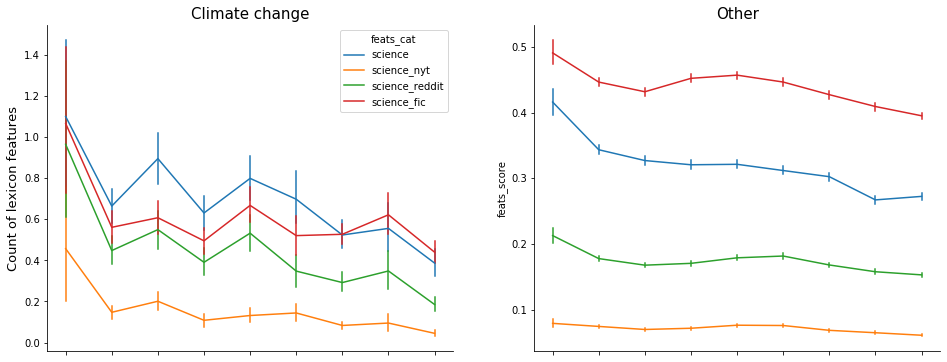

In [240]:
for corp_name in corp_to_analyze:
#     empath_cats = ['science','science_nyt','science_reddit','science_fic']
#     to_plot_df = pd.DataFrame({
#             'topic': [utt.meta['is_cc_related']
#                       for empath_cat in empath_cats
#                       for utt in corp_to_analyze[corp_name].iter_utterances()
#                       if utt.id[:2] != 't3'],
#             'year': [datetime.utcfromtimestamp(utt.timestamp).year
#                      for empath_cat in empath_cats
#                      for utt in corp_to_analyze[corp_name].iter_utterances()
#                      if utt.id[:2] != 't3'],
#             'feats_score': [utt.meta[empath_cat]
#                             for empath_cat in empath_cats
#                             for utt in corp_to_analyze[corp_name].iter_utterances()
#                             if utt.id[:2] != 't3'],
#             'feats_cat': [empath_cat
#                           for empath_cat in empath_cats
#                           for utt in corp_to_analyze[corp_name].iter_utterances()
#                           if utt.id[:2] != 't3'],

#         })

    fig, ax = plt.subplots(1,2,figsize=(16,6))
    for ix_, topic_bool in enumerate([True, False]):
        ax_ = ax[ix_]
        sns.lineplot(data=to_plot_df.loc[to_plot_df['topic']==topic_bool], 
                     hue='feats_cat', x='year', y='feats_score', ci=95,err_style='bars',
                     ax=ax_)
        if ix_ % 2 == 0:
            ax_.set_ylabel('Count of lexicon features',fontsize=13)
            ax_.set_title("Climate change",fontsize=15)
        else:
            ax_.set_title("Other",fontsize=15)
            ax_.get_legend().remove()
        ax_.set_xlabel('')
        ax_.set_xticklabels(ax_.get_xticklabels(),fontsize=14,rotation=90)
    sns.despine()
    plt.savefig('figs/empath_sci_features_over_time_with_error_bars_{}.png'.format(corp_name),
                dpi=200,bbox_inches="tight")

# Comments receiving deltas vs. not

## Add +/-delta; num. deltas to meta

Maintain list of comments awarded deltas by:

iterating through all comment utterances

if: speaker.isin(known_mods) AND comment begins with a CUE_START
    
    save: id of mod comment, 
    comment awarding the delta (mod comment's reply_to parent),
    comment awarded the delta (comment awarding the delta's reply_to)

In [75]:
# CUE_STARTS = {'Confirmed: 1 delta awarded to /u/',
#              'Confirmed - 1 delta awarded to /u/',
#              'The moderators have confirmed, ei'}

# with open(os.path.join(DISK_IO_DIR,'deltalog.tsv'),'w') as f:
#     f.write('{}\t{}\t{}\n'.format('logging_utt_id','awarding_utt_id',
#                                   'awarded_utt_id'))
#     for utterance in tqdm(corpus.iter_utterances()):
#         if utterance.speaker.id in known_cmv_mods\
#         and (utterance.text.startswith('Confirmed: 1 delta awarded to /u/')\
#              or utterance.text.startswith('Confirmed - 1 delta awarded to /u/')\
#              or utterance.text.startswith('The moderators have confirmed, ei')):
#             logging_comment_id = utterance.id
#             awarding_comment_id = utterance.reply_to
#             awarded_comment_id = corpus.get_utterance(awarding_comment_id)\
#                                         .reply_to
#             f.write('{}\t{}\t{}\n'.format(
#                 logging_comment_id,awarding_comment_id,
#                     awarded_comment_id))

deltalog = pd.read_csv(os.path.join('/u/scr/yiweil/Green-American-Lexicon/1_data_collection/reddit',
                                    'deltalog.tsv'),
                      sep='\t',header=0)
delta_awarded_utt_ids = set(deltalog['awarded_utt_id'].values)
delta_counts = deltalog['awarded_utt_id'].value_counts()
utt_id2num_deltas = {id_: delta_counts[id_] for id_ in delta_counts.index.values}

# Update meta to include whether an utterance was awarded a delta or not
def is_awarded_delta(utterance_id):
    return utterance_id in delta_awarded_utt_ids

def num_deltas(utterance_id):
    if utterance_id in delta_awarded_utt_ids:
        return utt_id2num_deltas[utterance_id]
    else:
        return 0

for corp_name in corp_to_analyze:
    if corp_name in {'full_cmv', 'matched_cmv_subsample', 'matched_cc_cmv_subsample'}:
        for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
            utt.meta['is_awarded_delta'] = is_awarded_delta(utt.id)
            utt.meta['num_deltas'] = num_deltas(utt.id)

2896720it [00:38, 75282.51it/s]
756789it [00:12, 62111.99it/s]


Examine comments getting the most deltas:

In [58]:
delta_counts

t1_d498qau    36
t1_h4hrvgr    28
t1_ehuop0f    15
t1_cg7nbsu    14
t1_c9xf9b1    13
              ..
t1_h0735d6     1
t1_gm1gfmm     1
t1_dozxucl     1
t1_eh7bzti     1
t1_ctsigef     1
Name: awarded_utt_id, Length: 33702, dtype: int64

In [ ]:
# # examples
# pd.DataFrame({'text':[corp_to_analyze['matched_cmv_subsample'].get_utterance(utt_id).text
#           for utt_id in delta_counts.index.values[:10]],
#              'num_deltas':[delta_counts[utt_id] for utt_id in delta_counts.index.values[:10]]})

Within cc-related discussions:

In [65]:
cc_ids = set(corp_to_analyze['matched_cc_cmv_subsample'].get_utterance_ids())
print(len(cc_ids))
delta_counts.loc[delta_counts.index.isin(cc_ids)]

6349


t1_dl1zf88    2
t1_dh1bhuq    2
t1_f3xknsc    2
t1_efr2kcr    1
t1_dhd1ud8    1
             ..
t1_ha2hgif    1
t1_h8x5n7z    1
t1_e7gts5n    1
t1_h3fx0yw    1
t1_d8vwrpw    1
Name: awarded_utt_id, Length: 290, dtype: int64

In [ ]:
# pd.DataFrame({'text':[corp_to_analyze['matched_cmv_subsample'].get_utterance(utt_id).text
#           for utt_id in delta_counts.loc[delta_counts.index.isin(cc_ids)].index.values[:10]],
#              'num_deltas':[delta_counts[utt_id] 
#                            for utt_id in delta_counts.loc[delta_counts.index.isin(cc_ids)].index.values[:10]]})

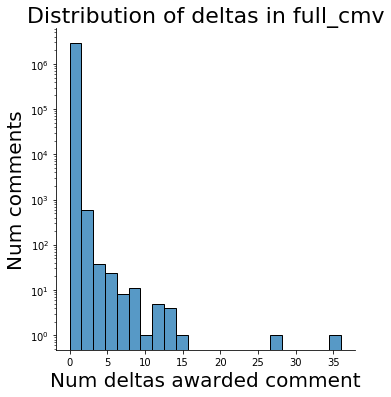

In [20]:
for corp_name in corp_to_analyze:
    if corp_name in {'full_cmv', 'matched_cmv_subsample', 'matched_cc_cmv_subsample'}:
        sns.displot([utt.meta['num_deltas'] for utt in corp_to_analyze[corp_name].iter_utterances()],
                   log_scale=(False,True))
        #plt.set_yscale
        plt.title(f'Distribution of deltas in {corp_name}',fontsize=22)
        plt.xlabel("Num deltas awarded comment",fontsize=20)
        plt.ylabel("Num comments",fontsize=20)
        plt.savefig(f'figs/dist_num_deltas_{corp_name}.png',dpi=150,bbox_inches="tight")

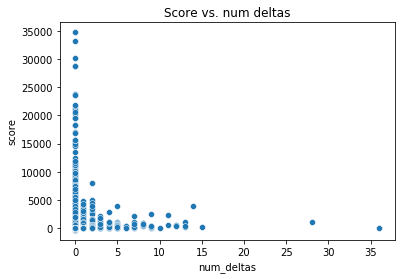

In [21]:
for corp_name in corp_to_analyze:
    if corp_name in {'full_cmv', 'matched_cmv_subsample', 'matched_cc_cmv_subsample'}:
        to_plot_df = pd.DataFrame({
            'num_deltas': [utt.meta['num_deltas'] for utt in corp_to_analyze[corp_name].iter_utterances()],
            'score': [utt.meta['score'] for utt in corp_to_analyze[corp_name].iter_utterances()],
            #'num_people':[len(utt.meta['people']) for utt in corp_to_analyze[corp_name].iter_utterances()],
#             'senti_arousal_cat':[utt.meta['senti_arousal_cat']
#                                  if utt.meta['senti_arousal_cat']
#                                 else None
#                                 for utt in corp_to_analyze[corp_name].iter_utterances()],
        })
#         for i,val in enumerate(['pos','neg']):
#             to_plot_df['{}_arousal'.format(val)] = to_plot_df['senti_arousal_cat'].apply(
#                 lambda x: x.split('_{}'.format(val))[0].split('_')[-1]
#                 if type(x) == str else None
#             )
#             if i%2 == 1:
#                 categories=['hi','lo','neut']
#             else:
#                 categories=['neut','lo','hi']
#             to_plot_df['{}_arousal'.format(val)] = pd.Categorical(
#                                                       to_plot_df['{}_arousal'.format(val)],
#                                                       categories=categories,
#                                                       ordered=True)
        sns.scatterplot(data=to_plot_df,x='num_deltas',y='score')
        plt.title("Score vs. num deltas")

In [ ]:
# g = sns.FacetGrid(to_plot_df, aspect=1.5, col='senti_arousal_cat')
# g.map(sns.histplot, 'num_deltas', log_scale=(False,True))
# plt.title("Num deltas vs. arousal")

2896720it [00:15, 190677.91it/s]


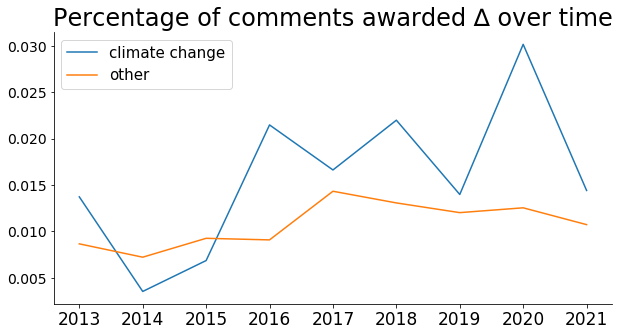

In [29]:
# Temporal trend
for corp_name in corp_to_analyze:
    if corp_name in {'full_cmv', 'matched_cmv_subsample', 'matched_cc_cmv_subsample'}:

        counts_by_bin = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))

        for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
            if utt.timestamp:
                year = datetime.utcfromtimestamp(utt.timestamp).year
                if utt.meta['is_cc_related']:
                    if utt.meta['is_awarded_delta']:
                        counts_by_bin[year]['climate change']['awarded delta'] += 1
                    else:
                        counts_by_bin[year]['climate change']['not awarded delta'] += 1
                else:
                    if utt.meta['is_awarded_delta']:
                        counts_by_bin[year]['other']['awarded delta'] += 1
                    else:
                        counts_by_bin[year]['other']['not awarded delta'] += 1
                        
        years = list(range(2013,2022))
        topics = ['climate change','other']
        classes = ['awarded delta','not awarded delta']
        to_plot_df = pd.DataFrame({
            'year':[item for sublist in 
                    [[y]*len(topics)*len(classes) for y in years]
                    for item in sublist],
            'topic':[item for sublist in 
                    [[t]*len(classes) for t in topics]
                    for item in sublist]*len(years),
            'class':classes*len(years)*len(topics),
            'count':[counts_by_bin[y][t][c] for y in years for t in topics for c in classes] 
        })
        
        per_year_topic_totals = to_plot_df.groupby(['year','topic']).sum()
        to_plot_df['norm'] = to_plot_df.apply(
            lambda x: x['count']/per_year_topic_totals.loc[x['year']]\
                                .loc[x['topic']]['count'],
            axis=1
        )

        plt.rcParams['figure.figsize'] = [10, 5]
        sns.lineplot(data=to_plot_df.loc[to_plot_df['class']=='awarded delta'],
                   x='year',y='norm',hue='topic',ci='sd',err_style='bars')
        plt.xlabel('')
        plt.ylabel('')
        plt.xticks(fontsize=17)
        plt.yticks(fontsize=14)
        plt.title('Percentage of comments awarded ∆ over time',fontsize=24)
        plt.legend(title='',fontsize=15)
        sns.despine()
        plt.savefig('figs/pct_comments_awarded_delta_over_time_{}.png'.format(corp_name),
                    dpi=200,bbox_inches="tight")

Examples of comments awarding deltas, which explain why user was persuaded:

In [289]:
comments_awarding_deltas_climate_threads = [
    utt_id for utt_id in deltalog['awarding_utt_id'].values
    if corpus.get_utterance(utt_id).meta['is_cc_related']
]
print(len(comments_awarding_deltas_climate_threads))

pd.DataFrame({
    'id':comments_awarding_deltas_climate_threads,
    'text':[corpus.get_utterance(utt_id).text
           for utt_id in comments_awarding_deltas_climate_threads]
})

319


id  \
0    t1_ef9tzs5   
1    t1_h8xaroo   
2    t1_ejjs8tf   
3    t1_fhqpeoe   
4    t1_hb50dh3   
..          ...   
314  t1_ds5kees   
315  t1_dh56ffl   
316  t1_dcsvdvw   
317  t1_et321b6   
318  t1_dab19de   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                text  
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                ∆ Yeah that's honestly a solid point it would be nice if the government could just handle it.  So another solution would bne if we could just stop being so over hyped about the issue in general.\n\nOnly issue is that I think we are in way too deep for that to work.  It is at the forefront of public policy right now.  Plus the changes that liberals are proposing would cost trillions of dollars and have huge impact on peoples lives....which leads to yellow vests.    
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          [deleted]  
2    Your point about diminishing returns on greenhouse gas emissions (because of common infrastructure) is a good one. Indeed, I had been imagining that Western population growth leads to emissions growth in a linear fashion. So I guess I'll give you a !delta for that.\n\nHowever, I still maintain my main view that having children isn't a good solution to climate change, on account of the fact that scientific engagement in western countries just isn't high enough. Most people are not involved in energy innovation and research, which means they're producing carbon emissions without contributing to the betterment of these technologies. Maybe if my country (USA) funded its schools better and made more of a conscious drive to shift the labor force towards energy research, then I'd feel differently about this.\n\nAlso, I think that the concept of diminishing returns could apply to energy innovation as well.  
3                                                                                                           

## Which features matter in changing people's minds?

List of features:
* engagement-related features
    * people/messengers
    * +/- arousal (based on SentiStrength)
    * EmoLex
* OG CMV paper features
    * non-textual features
        * entry time
        * len of back-and-forth
        * number of participants
    * textual features
        * interplay-related features
        * word category-based features
        * word score-based features
        * entire argument features
        * markdown formatting features
* DeSMOG features
    
    
NB: OG CMV paper uses different set-up to test importance of features by finding unsuccessful argument with highest Jaccard similarity to successful argument comment and training classifier to make binary prediction as to which one was successful. Intuition: control for content.

### Compute LOR values

In [154]:
#lor_per_corp = defaultdict(dict)

First get counts:

In [82]:
UPOS = False
XPOS = False
DEPPARSE = False
HEADS = False

sample1_set = set([utt.id for utt in corp_to_analyze['matched_cmv_subsample'].iter_utterances()
                  if utt.meta['is_awarded_delta']])
print(f"Found {len(sample1_set)} ids in sample 1.")

counts_bare = get_counts_for_lor(corp_to_analyze['matched_cmv_subsample'],
                         sample1_set,
                         [],
                         'matched_cmv_subsample_deltas_vs_no_deltas_gen_reddit_switchboard_prior',
                         cache=False,
                         background_only=False,
                         skip_background=True,
                         min_df=5,
                         upos=UPOS,
                         xpos=XPOS,
                         depparse=DEPPARSE,
                         heads=HEADS)

Found 31659 ids in sample 1.
Creating count matrix for +/- samples with ngram range (1, 2), min_df = 5, lowercasing = True, upos = False, xpos = False, depparse = False, and heads = False...


209854it [1:33:53, 37.25it/s]


FileNotFoundError: [Errno 2] No such file or directory: '/u/scr/yiweil/Green-American-Lexicon/2_data_exploration/combined_stanza_output_with_ner_embed_removed/t1_e6xwo70.json'

In [347]:
counts_bare.keys()

dict_keys([])

In [352]:
for corp_name in ['matched_cmv_subsample']:#corp_to_analyze:
#     unweighted_lor_upos = do_weighted_lor(counts_upos['counts1'], counts_upos['counts2'], 
#                                          counts_upos['prior'], 
#                                          prior_weight=1, 
#                                          counts1_weight=1, 
#                                          counts2_weight=1, 
#                                          verbose=False)
#     lor_per_corp[corp_name]['unweighted_upos'] = unweighted_lor_upos
    weighted_lor_bare = do_weighted_lor(counts_bare['corpus1'], counts_bare['corpus2'], 
                                         counts_bare['prior'], 
                                         prior_weight=2, 
                                         counts1_weight=1, 
                                         counts2_weight=20, 
                                         verbose=False)
    lor_per_corp[corp_name]['weighted_bare'] = weighted_lor_bare
#     weighted_lor_upos = do_weighted_lor(counts_upos['counts1'], counts_upos['counts2'], 
#                                          counts_upos['prior'], 
#                                          prior_weight=100, 
#                                          counts1_weight=1, 
#                                          counts2_weight=15, 
#                                          verbose=False)
#     lor_per_corp[corp_name]['weighted_upos'] = weighted_lor_upos
    
#     unweighted_lor_no_pos = do_weighted_lor(counts_no_pos['counts1'], counts_no_pos['counts2'], 
#                                           counts_no_pos['prior'], 
#                                           prior_weight=1, 
#                                           counts1_weight=1, 
#                                           counts2_weight=1, 
#                                           verbose=False)
#     lor_per_corp[corp_name]['unweighted_no_pos'] = unweighted_lor_no_pos
#     weighted_lor_no_pos = do_weighted_lor(counts_no_pos['counts1'], counts_no_pos['counts2'], 
#                                           counts_no_pos['prior'], 
#                                           prior_weight=100, 
#                                           counts1_weight=1, 
#                                           counts2_weight=15, 
#                                           verbose=False)
#     lor_per_corp[corp_name]['weighted_no_pos'] = weighted_lor_no_pos

Size of class1: 11162442
Size of class2: 11203709
Size of prior: 128626746


In [339]:
# CC only, weights = 1:20; 100(prior)
sig_vals = {w: lor_per_corp['matched_cc_cmv_subsample']['weighted_bare'][w] 
 for w in lor_per_corp['matched_cc_cmv_subsample']['weighted_bare']
if abs(lor_per_corp['matched_cc_cmv_subsample']['weighted_bare'][w]) > 1.9}
sorted(sig_vals.items(),key=lambda x:x[1],reverse=True)

[('co2', 3.907997870455982),
 ('climate', 2.698645632476566),
 ('dioxide', 2.696234720776932),
 ('carbon', 2.6543360872875432),
 ('carbon dioxide', 2.5743965754221665),
 ('ocean', 2.4684929270502853),
 ('www skepticalscience', 2.350813054036504),
 ('the 97', 2.34743070583246),
 ('skepticalscience', 2.332886118808238),
 ('skepticalscience com', 2.332886118808238),
 ('greenhouse', 2.206393589553862),
 ('natural cycle', 2.14937329401101),
 ('atmosphere be', 2.1228267072377336),
 ('warming', 2.096533121688926),
 ('of co2', 2.0879686651026836),
 ('methane', 2.072434538211863),
 ('climate change', 2.056957751801267),
 ('biodiversity', 2.0151180531207618)]

In [341]:
', '.join([x[0] for x in sorted(sig_vals.items(),key=lambda x:x[1],reverse=True)])

'co2, climate, dioxide, carbon, carbon dioxide, ocean, www skepticalscience, the 97, skepticalscience, skepticalscience com, greenhouse, natural cycle, atmosphere be, warming, of co2, methane, climate change, biodiversity'

In [353]:
# all CMV, weights = 1:15; 2(prior)
sig_vals = {w: lor_per_corp['matched_cmv_subsample']['weighted_bare'][w] 
 for w in lor_per_corp['matched_cmv_subsample']['weighted_bare']
if abs(lor_per_corp['matched_cmv_subsample']['weighted_bare'][w]) > 1.9}
sorted(sig_vals.items(),key=lambda x:x[1],reverse=True)

[('the', 11.65223593438836),
 ('and', 9.044503936958723),
 ('of', 8.830251953672748),
 ('in', 8.495489394793362),
 ('be', 6.935466565549153),
 ('to', 6.672344854048106),
 ('org', 6.378605205762511),
 ('this', 5.698767242889603),
 ('they', 5.060941526720041),
 ('on', 4.823586586174394),
 ('that', 4.790308555141541),
 ('but', 4.757179591663222),
 ('with', 4.624515535407693),
 ('for', 4.603754234044307),
 ('delta', 4.458204454307972),
 ('of the', 4.309174770514293),
 ('https en', 4.285298831864885),
 ('org wiki', 4.241611609072515),
 ('en', 4.2236784848163),
 ('it', 4.180457274827762),
 ('wikipedia', 4.119898932602194),
 ('wikipedia org', 4.108473012634816),
 ('en wikipedia', 4.096150259645583),
 ('at', 4.072908946144148),
 ('in the', 4.04918598931869),
 ('as', 3.9444962675971302),
 ('pdf', 3.8483769056064707),
 ('from', 3.767372007755723),
 ('often', 3.7574842418604413),
 ('might', 3.6145568063771374),
 ('more', 3.566763120142677),
 ('good', 3.5611504463673147),
 ('he', 3.489783708538045

In [208]:
'research' in all_empath_sci_feats

True

In [81]:
# weights = 1:20
sig_vals = {w: lor_per_corp['matched_cc_cmv_subsample']['weighted_wo_pos'][w] 
 for w in lor_per_corp['matched_cc_cmv_subsample']['weighted_wo_pos']
if abs(lor_per_corp['matched_cc_cmv_subsample']['weighted_wo_pos'][w]) > 1.9}
sorted(sig_vals.items(),key=lambda x:x[1],reverse=True)

[('the', 4.4302531538826235),
 ('co2', 4.016102779647343),
 ('a', 3.6958391316434254),
 ('%', 3.27900082888966),
 ('poor', 3.0976039497792205),
 ('experiment', 3.0424920188000733),
 ('dioxide', 3.0424920188000733),
 ('ocean', 2.954950657988805),
 ('carbon', 2.8240499604875784),
 ('CCP', 2.753984186194391),
 ('be', 2.6021516116289285),
 ('cycle', 2.5479712046109273),
 ('per', 2.5382071565705706),
 ('gallon', 2.448384646847179),
 ('Science', 2.448384646847179),
 ('greenhouse', 2.41632292750537),
 ('97', 2.413320700127313),
 ('action', 2.401585299286658),
 ('rich', 2.3418134481657575),
 ('ecosystem', 2.334966622594344),
 ('biodiversity', 2.325489454781162),
 ('release', 2.266239008606097),
 ('seaweed', 2.2661594089949384),
 ('methane', 2.2517828462681706),
 ('organic', 2.2405143977054625),
 ('Chinese', 2.2405143977054625),
 ('Climate', 2.221307313261586),
 ('atmosphere', 2.191767559255129),
 ('battery', 2.176345301888634),
 ('effect', 2.153029738413637),
 ('water', 2.1413696008766516),
 (

In [147]:
# cc-only; weights = 1:15; with switchboard + gen reddit background
sig_vals = {w: lor_per_corp['matched_cc_cmv_subsample']['weighted_wo_pos'][w] 
 for w in lor_per_corp['matched_cc_cmv_subsample']['weighted_wo_pos']
if abs(lor_per_corp['matched_cc_cmv_subsample']['weighted_wo_pos'][w]) > 1.96}
sorted(sig_vals.items(),key=lambda x:x[1],reverse=True)

[('co2', 3.073409887010761),
 ('poor', 3.0468640464438366),
 ('experiment', 2.935999024612736),
 ('dioxide', 2.935999024612736),
 ('CCP', 2.8259325333936167),
 ('Science', 2.5652632762584426),
 ('ocean', 2.417681387726944),
 ('gallon', 2.3718752019230416),
 ('seaweed', 2.362943692821538),
 ('per', 2.354143934908629),
 ('rich', 2.251348124565579),
 ('preservation', 2.2345503013288663),
 ('chemistry', 2.2325408051593065),
 ('biodiversity', 2.2325408051593065),
 ('cycle', 2.228912483832722),
 ('%', 2.203216550745488),
 ('97', 2.1494354909751343),
 ('release', 2.1341811718403463),
 ('battery', 2.112940911364332),
 ('al.', 2.0945069435538954),
 ('ecosystem', 2.072538167736246),
 ('methane', 2.021694522720207),
 ('butcher', 1.9727312617433763),
 ('spend', -1.9854550035112353),
 ('problem', -2.1041447334295675),
 ('say', -2.165822551593976),
 ('have', -2.1837199073610107),
 ('civilization', -2.186938705088744),
 ('economist', -2.2009175638399103),
 ('drought', -2.303192177434896),
 ('you', -2

In [96]:
# cc-only; weights = 1:15; no background (just 2 samples summed)
sig_vals = {w: lor_per_corp['matched_cc_cmv_subsample']['weighted_wo_pos'][w] 
 for w in lor_per_corp['matched_cc_cmv_subsample']['weighted_wo_pos']
if abs(lor_per_corp['matched_cc_cmv_subsample']['weighted_wo_pos'][w]) > 1.9}
sorted(sig_vals.items(),key=lambda x:x[1],reverse=True)

[('poor', 3.713671364499459),
 ('co2', 3.2295807306411852),
 ('experiment', 3.203951655197919),
 ('dioxide', 2.9911401258015),
 ('per', 2.8989588291733894),
 ('CCP', 2.844079322574466),
 ('rich', 2.7421704393263613),
 ('Science', 2.5946945876398217),
 ('ocean', 2.5735458269633043),
 ('release', 2.566973670172775),
 ('battery', 2.4794890558012255),
 ('gallon', 2.404942741828649),
 ('cycle', 2.401765556567715),
 ('seaweed', 2.387298764123448),
 ('%', 2.3487778703293536),
 ('chemistry', 2.3386072864477616),
 ('biodiversity', 2.265351694926317),
 ('preservation', 2.2587407880686805),
 ('97', 2.19121246662543),
 ('local', 2.172246272776472),
 ('ecosystem', 2.132717534315285),
 ('action', 2.125024904123274),
 ('al.', 2.118505571502948),
 ('unit', 2.11660533465535),
 ('methane', 2.0680575117728566),
 ('20', 1.9951863705248571),
 ('butcher', 1.99025136273504),
 ('greenhouse', 1.9743014656083901),
 ('organic', 1.9622396003718359),
 ('Chinese', 1.9622396003718359),
 ('fertilizer', 1.957498656869

In [ ]:
# # all CMV; weights = 1:15; with switchboard + gen reddit background
# sig_vals = {w: lor_per_corp['matched_cmv_subsample']['weighted_wo_pos'][w] 
#  for w in lor_per_corp['matched_cmv_subsample']['weighted_wo_pos']
# if abs(lor_per_corp['matched_cmv_subsample']['weighted_wo_pos'][w]) > 1.96}
# sorted(sig_vals.items(),key=lambda x:x[1],reverse=True)

In [145]:
# # weight = 1:10
# sig_vals = {w: lor_per_corp['matched_cc_cmv_subsample']['weighted_wo_pos'][w] 
#  for w in lor_per_corp['matched_cc_cmv_subsample']['weighted_wo_pos']
# if abs(lor_per_corp['matched_cc_cmv_subsample']['weighted_wo_pos'][w]) > 1.96}
# sorted(sig_vals.items(),key=lambda x:x[1],reverse=True)

In [146]:
# # weight = 1:5
# sig_vals = {w: lor_per_corp['matched_cc_cmv_subsample']['weighted_wo_pos'][w] 
#  for w in lor_per_corp['matched_cc_cmv_subsample']['weighted_wo_pos']
# if abs(lor_per_corp['matched_cc_cmv_subsample']['weighted_wo_pos'][w]) > 1.9}
# sorted(sig_vals.items(),key=lambda x:x[1],reverse=True)

### Test RQs

##### Draw random sample from -delta comments for more even sample sizes for LOR (NO LONGER NEEDED w/ WEIGHTED LOR)

In [175]:
# cc_ids = [utt.id for utt in filtered_cmv_subsample.iter_utterances()
#                          if utt.meta['is_cc_related']]
# non_delta_ids_to_keep = [utt.id for utt in filtered_cmv_subsample.iter_utterances()
#                          if not utt.meta['is_awarded_delta']
#                         and utt.meta['is_cc_related']]
# delta_ids_to_keep = set(cc_ids).difference(set(non_delta_ids_to_keep))
# print('Found {} comments w/ deltas.'.format(len(delta_ids_to_keep)))

# random_sample_size = len(delta_ids_to_keep)
# print("Drawing random sample of equal size of {} from {} non-delta comments total for LOR balance.".format(
#     random_sample_size,len(non_delta_ids_to_keep)))

# random_non_delta_ids_for_lor = list(np.random.choice(non_delta_ids_to_keep,size=random_sample_size,replace=False))
# random_ids_for_lor = set(list(delta_ids_to_keep) + list(random_non_delta_ids_for_lor))
# print("Final size of delta-balanced sample of climate-related and non-climate comments:",len(random_ids_for_lor))

In [176]:
# random_sample = filtered_cmv_subsample.filter_utterances_by(lambda utt: utt.id in random_ids_for_lor) 
# # balanced for +/- delta
# random_sample.print_summary_stats()

In [177]:
# cc_random_sample = filtered_cmv_subsample.filter_utterances_by(lambda utt: utt.id in random_ids_for_lor) 
# # balanced for +/- delta
# cc_random_sample.print_summary_stats()

##### RQ1: Is there a messenger effect for changing people's minds?

--> Are comments with deltas more likely to have people/named entities 
compared to comments not receiving deltas?

--> Do people/named entities tend to have large, positive LOR values?

--> Calculate LOR values for all people/named entities and look at their distributions--tend to skew positive?

In [ ]:
# # Plot distribution over +/- person for comments +/- deltas

# for corp_name in corp_to_analyze:
#     to_plot_df = pd.DataFrame({
#         'is_awarded_delta': [utt.meta['is_awarded_delta']
#                              for utt in corp_to_analyze[corp_name].iter_utterances()
#                             if utt.id[:2] != 't3'],
#         'num_deltas': [utt.meta['num_deltas']
#                              for utt in corp_to_analyze[corp_name].iter_utterances()
#                       if utt.id[:2] != 't3'],
#         'has_person': [len(utt.meta['people']) > 0
#                        for utt in corp_to_analyze[corp_name].iter_utterances()
#                       if utt.id[:2] != 't3'],
#         'num_people': [len(utt.meta['people'])
#                        for utt in corp_to_analyze[corp_name].iter_utterances()
#                       if utt.id[:2] != 't3']

#     })

#     g = sns.FacetGrid(to_plot_df, col="is_awarded_delta", sharey=False, aspect=1.5)
#     g.map(sns.histplot, "num_people")
#     g.axes[0][0].set_yscale('log')
#     g.axes[0][1].set_yscale('log')
#     plt.savefig(f'figs/people_counts_deltas_vs_no_deltas_{corp_name}.png',dpi=150,bbox_inches="tight")
    
#     g = sns.FacetGrid(to_plot_df, col="is_awarded_delta", sharey=False, aspect=1.5)
#     g.map(sns.histplot, "has_person")
#     g.axes[0][0].set_yscale('log')
#     g.axes[0][1].set_yscale('log')
#     plt.savefig(f'figs/people_boolean_deltas_vs_no_deltas_{corp_name}.png',dpi=150,bbox_inches="tight")
#     plt.show()
    
#     fig, ax = plt.subplots()
#     fig.set_size_inches(4, 7)
#     sns.barplot(data=to_plot_df, x='is_awarded_delta',y="num_people", ax=ax)
#     ax.set_xlabel('')
#     ax.set_xticklabels(['-delta','+delta'],fontsize=18)
#     ax.set_ylabel('Number of people in comment',fontsize=18)
#     sns.despine()
#     plt.savefig(f'figs/people_deltas_vs_no_deltas_barplot_{corp_name}.png',dpi=150,bbox_inches='tight')
#     plt.show()

In [286]:
stats.ttest_ind(to_plot_df.loc[to_plot_df['is_awarded_delta']]['num_people'].values,
                to_plot_df.loc[~to_plot_df['is_awarded_delta']]['num_people'].values)

Ttest_indResult(statistic=1.9118281701798976, pvalue=0.05594321688115575)

In [210]:
# Check if people show up in sig. LOR
{w: lor_per_corp['matched_cmv_subsample']['weighted_bare'][w] 
for w in counted_people.keys()
if w in lor_per_corp['matched_cmv_subsample']['weighted_bare']
and abs(lor_per_corp['matched_cmv_subsample']['weighted_bare'][w]) > 1.9}

{'anakin': 1.9306656970520502,
 'harry': 2.442573572315126,
 'jesus': 2.8013219047876907,
 'phil': 2.158466487794158,
 'john': 2.1921700706132103,
 'steve': 2.0803680343541684,
 'trayvon': -1.9575906607049192,
 'kanye': 2.1267502062667853,
 'dale': 2.673781660435547,
 '4chan': 3.2597054143249267,
 'steven': 3.8705827514950935,
 'zimmerman': -2.447521790753426,
 'fox': 1.9767793468978048,
 'wayne': 1.9621376238674135,
 'alito': 2.0890688543229308,
 'sherlock': 2.9155502282310977,
 'mrna': 3.6249980626315232,
 'simon': 2.1706929062820626,
 'jane': 2.3909312706241526}

In [287]:
# Check if people show up in sig. LOR
{w: lor_per_corp['matched_cc_cmv_subsample']['weighted_bare'][w] 
for w in counted_people.keys()
if w in lor_per_corp['matched_cc_cmv_subsample']['weighted_bare']
and abs(lor_per_corp['matched_cc_cmv_subsample']['weighted_bare'][w]) > 1.9}

{}

###### RQSci: Does science help sway opinions?

In [ ]:
# # Plot distribution over #sci_words for comments +/- deltas

# for corp_name in corp_to_analyze:
#     to_plot_df = pd.DataFrame({
#         'is_awarded_delta': [utt.meta['is_awarded_delta']
#                              for utt in corp_to_analyze[corp_name].iter_utterances()
#                             if utt.id[:2] != 't3'],
#         'num_deltas': [utt.meta['num_deltas']
#                              for utt in corp_to_analyze[corp_name].iter_utterances()
#                       if utt.id[:2] != 't3'],
#         'science': [utt.meta['science']
#                        for utt in corp_to_analyze[corp_name].iter_utterances()
#                        if utt.id[:2] != 't3'],
#         'science_nyt': [utt.meta['science_nyt']
#                        for utt in corp_to_analyze[corp_name].iter_utterances()
#                        if utt.id[:2] != 't3'],
#         'science_reddit': [utt.meta['science_reddit']
#                        for utt in corp_to_analyze[corp_name].iter_utterances()
#                           if utt.id[:2] != 't3'],
#         'science_fic': [utt.meta['science_fic']
#                        for utt in corp_to_analyze[corp_name].iter_utterances()
#                        if utt.id[:2] != 't3'],

#     })
#     for col in ['num_deltas','science','science_nyt','science_reddit','science_fic']:
#         to_plot_df[f'log_{col}'] = to_plot_df[col].apply(lambda x: math.log(x+1))

# #     fig, axes = plt.subplots(4,2,figsize=(8,15))
# #     row_ix = 0
# #     for delta_ix,delta_bool in enumerate([False,True]):
# #         for cat_ix,empath_cat in enumerate(['science','science_nyt','science_reddit','science_fic']):
# #             ax_ = axes[cat_ix][delta_ix]
# #             sns.histplot(to_plot_df.loc[(to_plot_df['is_awarded_delta']==delta_bool)],
# #                             x=empath_cat,ax=ax_)
# #             ax_.set_xlabel(f"Count of {empath_cat} features",fontsize=13)
# #             ax_.set_yscale('log')
# #             if delta_ix % 2 == 0:
# #                 ax_.set_ylabel("#Comments",fontsize=15)
# #                 if cat_ix == 0:
# #                     ax_.set_title('not awarded delta',fontsize=18)
# #             else:
# #                 ax_.set_ylabel("")
# #                 if cat_ix == 0:
# #                     ax_.set_title('awarded delta',fontsize=18)
# #             sns.despine()
# #     plt.savefig(f'figs/dists_empath_sci_feats_deltas_vs_no_deltas_{corp_name}.png',dpi=150,bbox_inches="tight")

#     fig, axes = plt.subplots(1,4,figsize=(10,4),sharey=True)
#     for cat_ix,empath_cat in enumerate(['science','science_nyt','science_reddit','science_fic']):
#         ax_ = axes[cat_ix]
#         sns.barplot(data=to_plot_df,x='is_awarded_delta',y=empath_cat,ax=ax_,ci=95)
#         ax_.set_xlabel('')
#         ax_.set_xticklabels(['-delta','+delta'],fontsize=14)
#         ax_.set_ylim([0,1.3])
#         ax_.set_ylabel('')
#         ax_.set_title(f'{empath_cat}',fontsize=14)
#         sns.despine()
#     plt.savefig(f'figs/barplots_empath_sci_feats_deltas_vs_no_deltas_{corp_name}.png',dpi=150,bbox_inches='tight')

In [293]:
stats.ttest_ind(to_plot_df.loc[to_plot_df['is_awarded_delta']]['science'].values,
                to_plot_df.loc[~to_plot_df['is_awarded_delta']]['science'].values)

Ttest_indResult(statistic=3.685231098569228, pvalue=0.00023039937215591438)

In [294]:
stats.ttest_ind(to_plot_df.loc[to_plot_df['is_awarded_delta']]['science_nyt'].values,
                to_plot_df.loc[~to_plot_df['is_awarded_delta']]['science_nyt'].values)

Ttest_indResult(statistic=2.0158037843727756, pvalue=0.04386255800801137)

In [295]:
stats.ttest_ind(to_plot_df.loc[to_plot_df['is_awarded_delta']]['science_reddit'].values,
                to_plot_df.loc[~to_plot_df['is_awarded_delta']]['science_reddit'].values)

Ttest_indResult(statistic=1.0015507354642577, pvalue=0.3165988057867682)

In [296]:
stats.ttest_ind(to_plot_df.loc[to_plot_df['is_awarded_delta']]['science_fic'].values,
                to_plot_df.loc[~to_plot_df['is_awarded_delta']]['science_fic'].values)

Ttest_indResult(statistic=3.009314222824129, pvalue=0.002628665963912681)

In [264]:
# Check if sci_feats show up in sig. LOR
all_empath_sci_feats = set([item for sublist in empath_sci_feats.values() for item in sublist])

sorted({w: lor_per_corp['matched_cmv_subsample']['weighted_bare'][w] 
for w in all_empath_sci_feats
if w in lor_per_corp['matched_cmv_subsample']['weighted_bare']
and abs(lor_per_corp['matched_cmv_subsample']['weighted_bare'][w]) > 1.9}.items(),key=lambda x:x[1],reverse=True)

[('research', 4.309916014662114),
 ('study', 3.889331733568624),
 ('improve', 3.3018885017899806),
 ('critical', 3.037568272902809),
 ('development', 2.9749460027468566),
 ('benefit', 2.6117792121143064),
 ('researcher', 2.343351001221101),
 ('establish', 2.296586711057056),
 ('philosophy', 2.2809980895352164),
 ('accomplish', 2.2344748490095547),
 ('modify', 2.176347762098813),
 ('access', 2.039409590772334),
 ('function', 2.0304489756280772),
 ('limit', 1.9948744906612708),
 ('scientist', 1.9920246207603145),
 ('evaluate', 1.9752297722013117),
 ('present', 1.9054237394453248),
 ('review', -3.3841281454538312),
 ('subject', -7.295347094902295),
 ('appeal', -18.647944328848926)]

In [297]:
sorted({w: lor_per_corp['matched_cc_cmv_subsample']['weighted_bare'][w] 
for w in all_empath_sci_feats
if w in lor_per_corp['matched_cc_cmv_subsample']['weighted_bare']
and abs(lor_per_corp['matched_cc_cmv_subsample']['weighted_bare'][w]) > 1.9}.items(),key=lambda x:x[1],reverse=True)

[]

In [300]:
to_plot_df.loc[to_plot_df['lor']<-3]

Empty DataFrame
Columns: [word, lor]
Index: []

outliers:         word        lor
47    review  -3.384128
53   subject  -7.295347
171   appeal -18.647944


/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.


outliers: Empty DataFrame
Columns: [word, lor]
Index: []


/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.


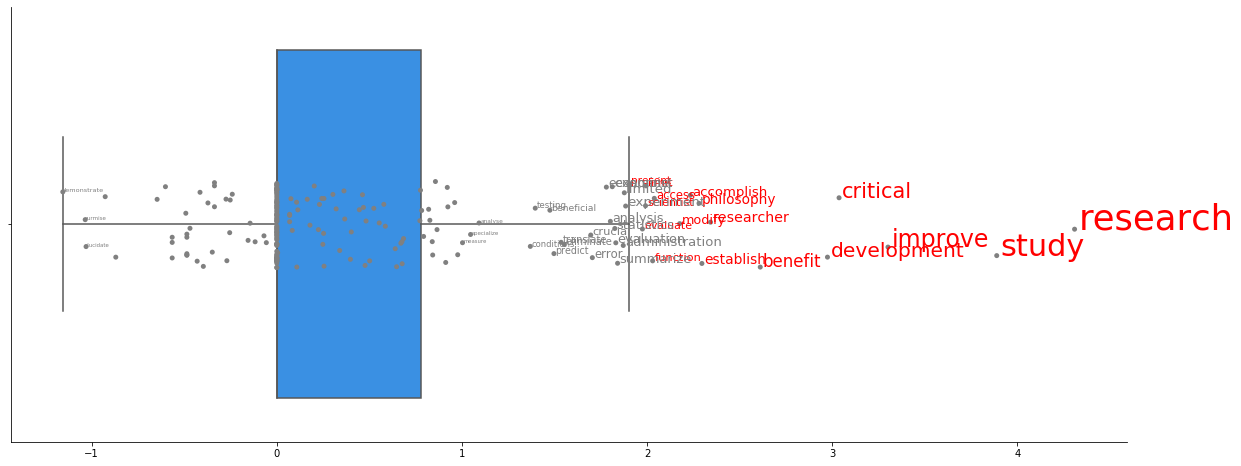

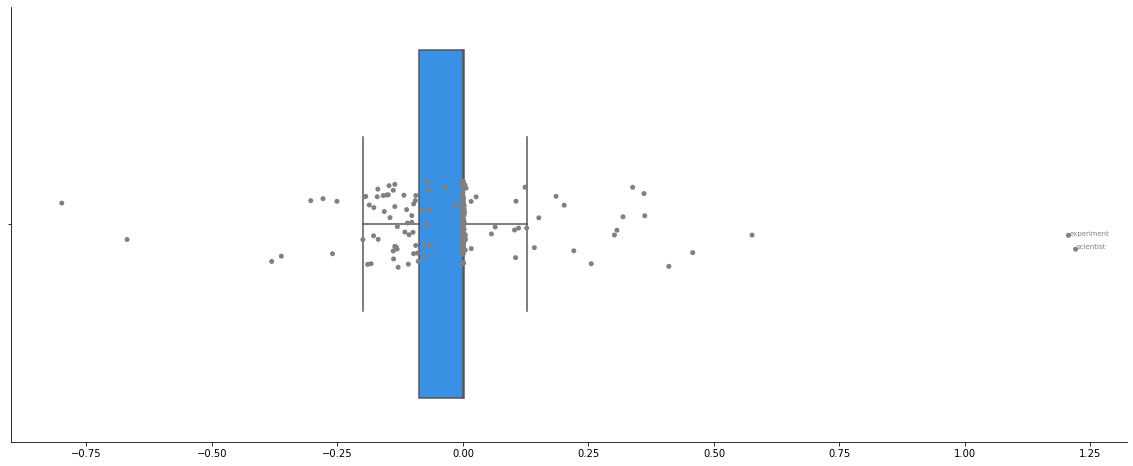

In [342]:
for corp_name in corp_to_analyze:
    to_plot_df = pd.DataFrame({
        'word': [w for w in all_empath_sci_feats],
        'lor': [lor_per_corp[corp_name]['weighted_bare'][w]
                   for w in all_empath_sci_feats]
    })
    
    print('outliers:',to_plot_df.loc[to_plot_df['lor']<-3])
    
    to_plot_df = to_plot_df.loc[to_plot_df['lor']>-3].copy()

    fig, ax = plt.subplots(figsize=(20,8))
    sns.boxplot(data=to_plot_df, x='lor', ax=ax, color='dodgerblue',showfliers=False)
    sns.stripplot(data=to_plot_df, x='lor', ax=ax, jitter=True,dodge=True,color='gray')
    xs,ys = np.array(ax.collections[0].get_offsets()).T
    for i in range(len(to_plot_df)):
        if abs(to_plot_df['lor'].values[i]) > 1.9:
            ax.annotate(to_plot_df['word'].values[i],
                    xy=(xs[i],ys[i]),textcoords='offset points',color='red',
                        fontsize=abs(to_plot_df['lor'].values[i]*2.5)**1.5)
        elif abs(to_plot_df['lor'].values[i]) > 1:
            ax.annotate(to_plot_df['word'].values[i],
                    xy=(xs[i],ys[i]),textcoords='offset points',color='gray',
                        fontsize=abs(to_plot_df['lor'].values[i]*3)**1.5)
        else:
            pass
    sns.despine()
    ax.set_xlabel('')
    plt.savefig(f'figs/dist_lor_empath_sci_feats_{corp_name}.png',dpi=150,bbox_inches="tight")

/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


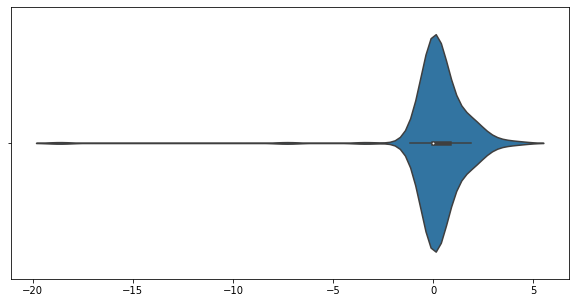

In [241]:
sns.violinplot([lor_per_corp['matched_cmv_subsample']['weighted_bare'][w]
               for w in all_empath_sci_feats])

##### RQ2: Do high +/- arousal words change people's minds?

--> Are comments with deltas more likely to be high arousal?

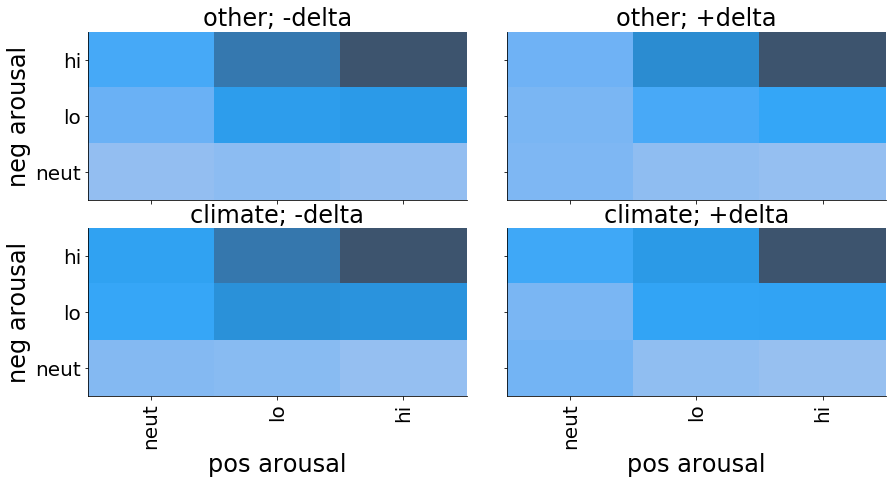

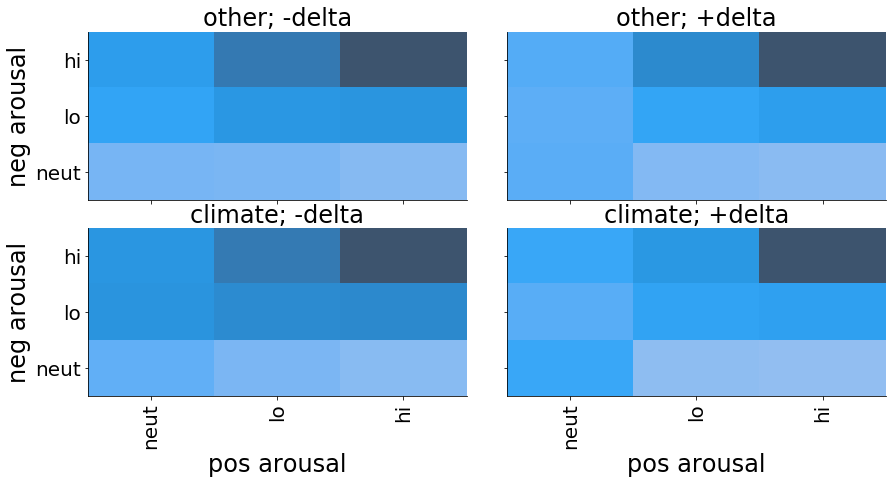

In [113]:
# Fig 4: Distribution of SentiStrength arousal categories for comments
for corp_name in corp_to_analyze:
    if 'cmv' in corp_name:
        # prep data to plot
        to_plot_df = pd.DataFrame({
            'is_awarded_delta': [utt.meta['is_awarded_delta']
                                for utt in corp_to_analyze[corp_name].iter_utterances()
                                if utt.meta['senti_all_arousal_cat']],
            'senti_all_arousal_cat': [utt.meta['senti_all_arousal_cat']
                                for utt in corp_to_analyze[corp_name].iter_utterances()
                                 if utt.meta['senti_all_arousal_cat']],
            'senti_adxs_only_arousal_cat': [utt.meta['senti_adxs_only_arousal_cat']
                                for utt in corp_to_analyze[corp_name].iter_utterances()
                                 if utt.meta['senti_all_arousal_cat']],
            'is_cc_related': [utt.meta['is_cc_related']
                                for utt in corp_to_analyze[corp_name].iter_utterances()
                             if utt.meta['senti_all_arousal_cat']]})
        
        SENTI_CATS = to_plot_df['senti_all_arousal_cat'].value_counts().index
        for senti_model in ['all','adxs_only']:
            to_plot_df[f'senti_{senti_model}_arousal_cat'] = \
            pd.Categorical(to_plot_df[f'senti_{senti_model}_arousal_cat'],
                           categories=SENTI_CATS,
                           ordered=True)
        
            # further prepping: isolate +/- SS components
            for i,val in enumerate(['pos','neg']):
                to_plot_df[f'{senti_model}_{val}_arousal'] = \
                to_plot_df[f'senti_{senti_model}_arousal_cat'].apply(
                    lambda x: x.split('_{}'.format(val))[0].split('_')[-1]
                )
                if i%2 == 1:
                    categories=['hi','lo','neut']
                else:
                    categories=['neut','lo','hi']
                to_plot_df[f'{senti_model}_{val}_arousal'] = \
                pd.Categorical(to_plot_df[f'{senti_model}_{val}_arousal'],
                               categories=categories,
                               ordered=True)

            # plotting
            g = sns.FacetGrid(to_plot_df, col="is_awarded_delta", row="is_cc_related", 
                              sharey=False, aspect=2)
            g.map(sns.histplot, f"{senti_model}_pos_arousal", f"{senti_model}_neg_arousal")
            #g.map(sns.histplot, "senti_arousal_cat")

            # aesthetics
            for ax_ix,ax in enumerate(g.axes.ravel()):
                title = ax.get_title()
                is_cc_related = title.split(' |')[0].split('= ')[-1]
                is_awarded_delta = title.split('| ')[-1].split('= ')[-1]
                if is_cc_related == 'True':
                    pretty_title = 'climate; '
                else:
                    pretty_title = 'other; '
                if is_awarded_delta == 'True':
                    pretty_title += '+delta'
                else:
                    pretty_title += '-delta'
                ax.set_title(pretty_title, fontsize=24)
                ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)
                if ax_ix % 2 == 0:
                    ax.set_yticklabels(ax.get_yticklabels(), fontsize=20)
                    ax.set_ylabel("neg arousal",fontsize=24)
                else:
                    ax.set_yticklabels('')
                if ax_ix >= 2:
                    ax.set_xlabel("pos arousal",fontsize=24)

            # saving
            plt.savefig(f'figs/senti_arousal_dist_deltas_vs_no_deltas_{corp_name}_{senti_model}.png',
                       dpi=150,bbox_inches="tight")

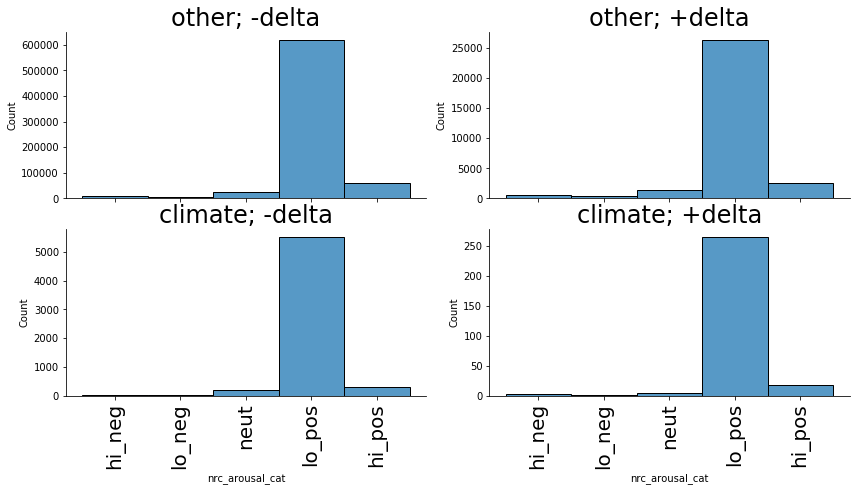

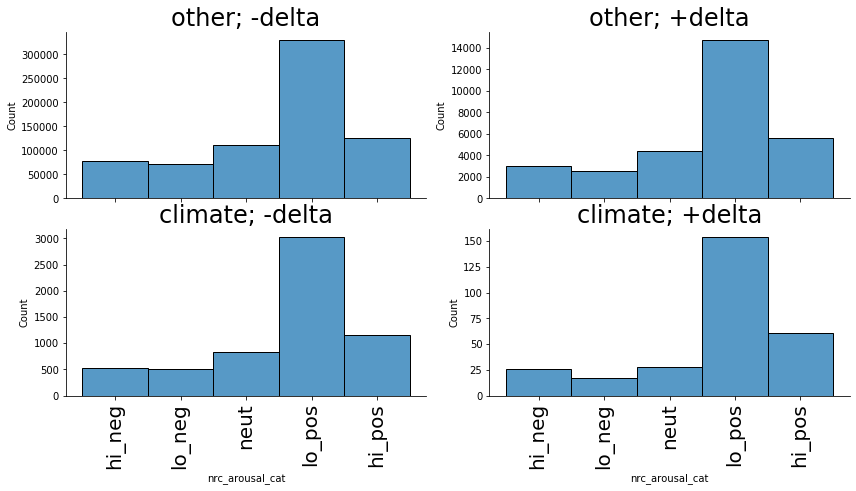

In [116]:
# Fig 5: Distribution of NRC VAD arousal categories for comments
for corp_name in corp_to_analyze:
    if 'cmv' in corp_name:
        for model_name in ['all','adxs_only']:
        
            # prep data to plot
            to_plot_df = pd.DataFrame({
                'is_awarded_delta': [utt.meta['is_awarded_delta']
                                     for utt in corp_to_analyze[corp_name].iter_utterances()
                                     if f'nrc_{model_name}_arousal_cat' in utt.meta 
                                     and utt.meta[f'nrc_{model_name}_arousal_cat']],
                'nrc_arousal_cat': [utt.meta[f'nrc_{model_name}_arousal_cat']
                                    for utt in corp_to_analyze[corp_name].iter_utterances()
                                    if f'nrc_{model_name}_arousal_cat' in utt.meta 
                                    and utt.meta[f'nrc_{model_name}_arousal_cat']],
                'is_cc_related': [utt.meta['is_cc_related']
                                  for utt in corp_to_analyze[corp_name].iter_utterances()
                                  if f'nrc_{model_name}_arousal_cat' in utt.meta 
                                  and utt.meta[f'nrc_{model_name}_arousal_cat']]})
            to_plot_df['nrc_arousal_cat'] = \
            pd.Categorical(to_plot_df['nrc_arousal_cat'],
            categories=['hi_neg','lo_neg','neut','lo_pos','hi_pos'],
            ordered=True)

            # plotting
            g = sns.FacetGrid(to_plot_df, col="is_awarded_delta", row="is_cc_related", 
                              sharey=False, aspect=2)
            g.map(sns.histplot, "nrc_arousal_cat")

            # aesthetics
            for ax in g.axes.ravel():
                title = ax.get_title()
                is_cc_related = title.split(' |')[0].split('= ')[-1]
                is_awarded_delta = title.split('| ')[-1].split('= ')[-1]
                if is_cc_related == 'True':
                    pretty_title = 'climate; '
                else:
                    pretty_title = 'other; '
                if is_awarded_delta == 'True':
                    pretty_title += '+delta'
                else:
                    pretty_title += '-delta'
                ax.set_title(pretty_title, fontsize=24)
                ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)

            # saving
            plt.savefig(f'figs/nrc_arousal_dist_deltas_vs_no_deltas_{corp_name}_{model_name}.png',
                       dpi=150,bbox_inches="tight")

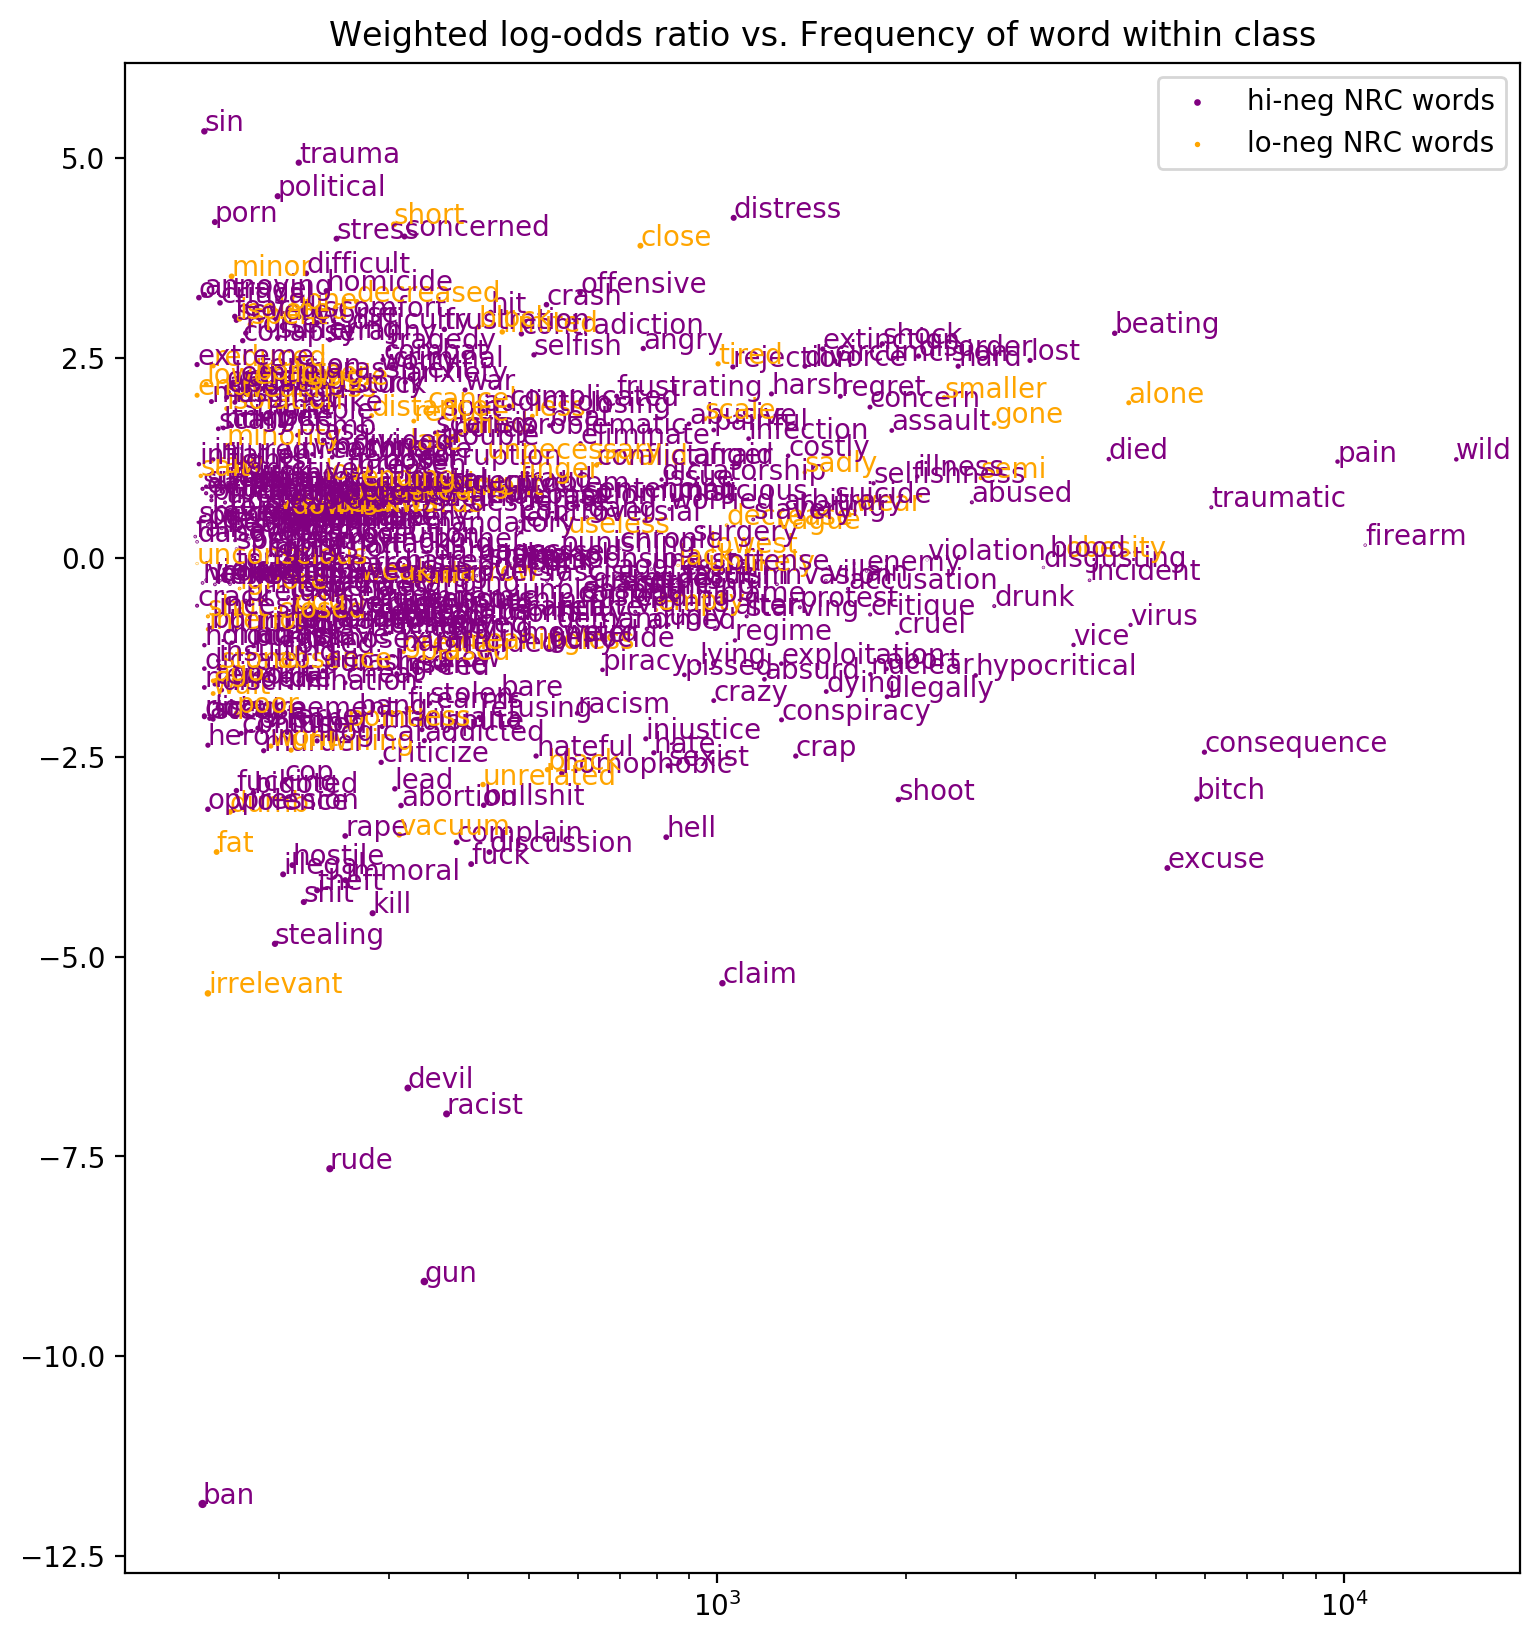

In [32]:
# no annotations of words or non-of-interest words--too crowded
fw_all_topics_no_bots.plot_fighting_words_fancy(class1_name='hi-neg NRC words', 
                                                class2_name='lo-neg NRC words', 
                                 config={'threshold': 1.96, 'annot_method': 'custom'},
                                word_set1=NRC_words_per_cat['hi_neg'],
                                word_set2=NRC_words_per_cat['lo_neg'],
                                verbose=True)

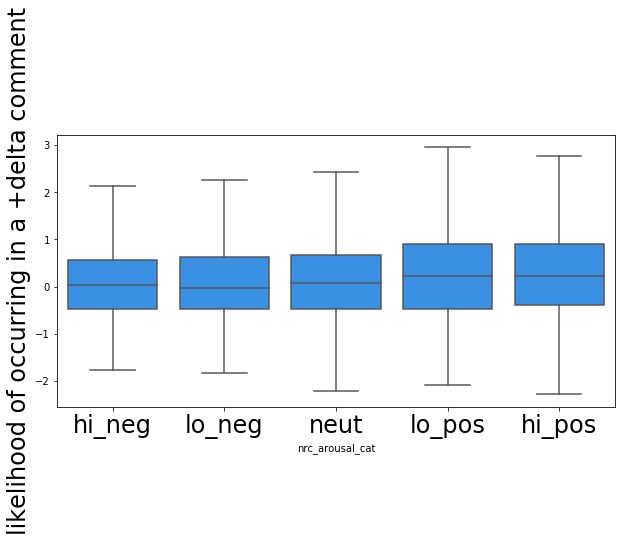

In [211]:
for corp_name in corp_to_analyze:
    #for model_name in ['all','adxs_only']:
    to_plot_df = pd.DataFrame({
        'z-score': [lor_per_corp[corp_name]['weighted_bare'][w]
                    for w in lor_per_corp[corp_name]['weighted_bare']],
        'nrc_arousal_cat': [word2NRC_cat[w]
                            if w in word2NRC_cat else None
                            for w in lor_per_corp[corp_name]['weighted_bare']]
    })
    
    sns.boxplot(data=to_plot_df,
            x='nrc_arousal_cat',y='z-score',
            order=['hi_neg','lo_neg','neut','lo_pos','hi_pos'],
            showfliers=False,color='dodgerblue')
    plt.ylabel("likelihood of occurring in a +delta comment",fontsize=24)
    plt.xticks(fontsize=24)
    plt.savefig(f'figs/lor_per_nrc_arousal_cat_{corp_name}.png',
                dpi=150,bbox_inches="tight")

In [76]:
# Check LOR values for words of derived NRC arousal cats
#df_all_topics_no_bots.loc[df_all_topics_no_bots.index.isin(NRC_words_per_cat['hi_neg'])][::-1]

In [ ]:
#df_cc_no_bots.loc[df_cc_no_bots.index.isin(NRC_words_per_cat['hi_neg'])][::-1]

In [ ]:
#df_all_topics_no_bots.loc[df_all_topics_no_bots.index.isin(NRC_words_per_cat['lo_neg'])][::-1]

In [ ]:
#df_cc_no_bots.loc[df_cc_no_bots.index.isin(NRC_words_per_cat['lo_neg'])][::-1]

In [ ]:
#df_all_topics_no_bots.loc[df_all_topics_no_bots.index.isin(NRC_words_per_cat['hi_pos'])][::-1]

In [ ]:
#df_cc_no_bots.loc[df_cc_no_bots.index.isin(NRC_words_per_cat['hi_pos'])][::-1]

In [ ]:
#df_all_topics_no_bots.loc[df_all_topics_no_bots.index.isin(NRC_words_per_cat['lo_pos'])][::-2]

In [ ]:
#df_cc_no_bots.loc[df_cc_no_bots.index.isin(NRC_words_per_cat['lo_pos'])][::-1]

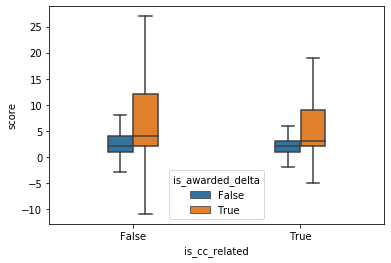

In [51]:
# Is score of a comment related to whether or not it gets a delta?
to_plot_df = pd.DataFrame({
    'is_awarded_delta': [utt.meta['is_awarded_delta']
                        for utt in filtered_cmv_subsample.iter_utterances()],
    'score': [utt.meta['score']
                        for utt in filtered_cmv_subsample.iter_utterances()],
    'is_cc_related': [utt.meta['is_cc_related']
                        for utt in filtered_cmv_subsample.iter_utterances()]
})

sns.boxplot(data=to_plot_df, x='is_cc_related', y='score', showfliers=False, width=0.3,
           hue='is_awarded_delta')

##### RQ3: Do emotions matter for deltas?

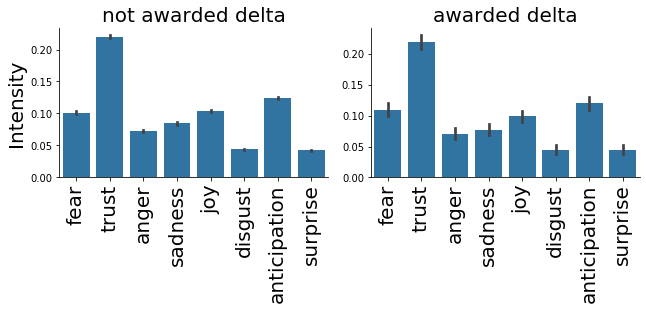

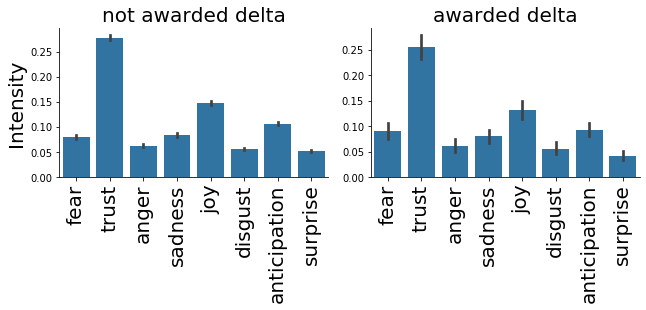

In [142]:
for corp_name in corp_to_analyze:

    years = list(range(2013,2022))
    topics = ['climate change','other']
    emotions = EMOLEX_EMOS
    for model_name in ['all','adxs_only']:
        df_year, df_topic, df_emo, df_emoscore = [], [], [], []
        df_id, df_contro, df_replies, df_score = [], [], [], []
        df_nrc_arousal, df_pos_arousal, df_neg_arousal = [], [], []
        df_delta = []
        for utt in corp_to_analyze[corp_name].iter_utterances():
            if utt.timestamp and utt.id[:2] != 't3':
                year = datetime.utcfromtimestamp(utt.timestamp).year
                topic = 'climate change' if utt.meta['is_cc_related'] else 'other'
                for key in utt.meta.keys():
                    if key.startswith(f'emolex_{model_name}'):
                        emo = key.split('_')[-1]
                        score = utt.meta[f'emolex_{model_name}_{emo}']
                        df_year.append(year)
                        df_topic.append(topic)
                        df_emo.append(emo)
                        df_emoscore.append(score)
                        df_id.append(utt.id)
                        df_contro.append(utt.meta['controversiality'])
                        df_replies.append(len(utt.meta['reply_ids']))
                        df_score.append(utt.meta['score'])
                        df_nrc_arousal.append(utt.meta[f'nrc_{model_name}_arousal_cat'])
                        senti_cat = utt.meta[f'senti_{model_name}_arousal_cat']
                        df_pos_arousal.append(senti_cat.split('_pos')[0].split('_')[-1])
                        df_neg_arousal.append(senti_cat.split('_neg')[0].split('_')[-1])
                        df_delta.append(utt.meta['is_awarded_delta'])
        to_plot_df = pd.DataFrame({
            'year':df_year,
            'topic':df_topic,
            'emotion':df_emo,
            'emoscore':df_emoscore,
            'id':df_id,
            'contro':df_contro,
            'num_replies':df_replies,
            'score':df_score,
            'nrc_arousal':df_nrc_arousal,
            'pos_arousal':df_pos_arousal,
            'neg_arousal':df_neg_arousal,
            'is_awarded_delta':df_delta
        })

#         g = sns.FacetGrid(to_plot_df, col="is_awarded_delta", row="emotion", sharey=False, aspect=1.5)
#         g.map(sns.histplot, "emoscore")
        
        g = sns.FacetGrid(to_plot_df, col="is_awarded_delta", sharey=False, aspect=1.5)
        g.map(sns.barplot, "emotion", "emoscore", order=EMOLEX_EMOS)
        for ax_ix,ax in enumerate(g.axes[0]):
            ax.set_xticklabels(ax.get_xticklabels(),rotation=90,fontsize=20)
            ax.set_xlabel("")
            if ax_ix == 0:
                ax.set_ylabel("Intensity",fontsize=20)
            ax.set_title("not "[:4*(not (ax.get_title().split(' = ')[-1] == 'True'))] \
                         + "awarded delta",fontsize=20)
        plt.savefig(f'figs/emo_dist_deltas_v_no_deltas_{corp_name}_{model_name}.png',
                    dpi=150,bbox_inches="tight")

# Manual inspection

## If +delta vs. -delta comments use science words differently

See if science words occur in comments w/o deltas: if they do, then compare those to +delta comments w/ science words. Repeat for words w/ high -LOR values. 

In [42]:
PRIOR_WEIGHT = 8
COUNTS1_WEIGHT = 1
COUNTS2_WEIGHT = 7

top_sig_lors = {}
for corp_name in ['matched_cmv_subsample']:#corp_to_analyze:
    sample1_ids = set([utt.id for utt in corp_to_analyze[corp_name].iter_utterances()
                       if utt.meta['is_awarded_delta']])
    save_prefix = f'{corp_name}_deltas_vs_no_deltas_gen_reddit_switchboard_prior'
    counts = get_counts_for_lor(corp_to_analyze[corp_name], sample1_ids, [], save_prefix, 
                           stanza_dir='/u/scr/yiweil/Green-American-Lexicon/2_data_exploration/combined_stanza_output_with_ner_embed_removed',
                           verbose=False, cache=True, background_only=False, skip_background=True,
                           ngram_range=(1,2), min_df=5, do_lowercase=True, 
                           upos=False, xpos=False, depparse=False, heads=False)
    print(f'Found counts of the following corpora cached: {counts.keys()}')
    lor = do_weighted_lor(counts['corpus1'], counts['corpus2'], counts['prior'], 
                    prior_weight=PRIOR_WEIGHT, counts1_weight=COUNTS1_WEIGHT, counts2_weight=COUNTS2_WEIGHT, 
                    verbose=False)
    sig_lor = {w: lor[w] for w in lor if abs(lor[w]) >= 1.96}
    sorted_sig_lor = sorted(sig_lor.items(), key=lambda x:x[1], reverse=True)
    top_sig_lors[corp_name] = sorted_sig_lor

Loading counters from cache...
Found counts of the following corpora cached: dict_keys(['corpus1', 'corpus2', 'prior'])
Size of class1: 9198132
Size of class2: 7294553
Size of prior: 10051607


In [55]:
top_sig_lors[corp_name][::-1]

[('do you', -6.268344784729463),
 ('uh', -5.6510110165416165),
 ('be you', -5.381561075481621),
 ('changemyview', -4.833028399258454),
 ('com changemyview', -4.763977521462772),
 ('pay', -4.626903092446833),
 ('ftf', -4.543724757660426),
 ('you submission', -4.474264056810522),
 ('submission have', -4.3788489230338365),
 ('gt', -4.0920297063448015),
 ('gun', -3.8324955817824806),
 ('the moderator', -3.7113902317284615),
 ('2fr 2fchangemyview', -3.6718339397559046),
 ('2fchangemyview subject', -3.6718339397559046),
 ('2fchangemyview', -3.6718339397559046),
 ('by click', -3.6440476584298818),
 ('changemyview wiki', -3.5678541695410337),
 ('to 2fr', -3.540879737796981),
 ('moderator by', -3.5261686896017888),
 ('click this', -3.5261686896017888),
 ('2fr', -3.5169587330849907),
 ('yeah', -3.5123067206764595),
 ('huh', -3.413813202736959),
 ('wiki modstandards', -3.4042652919796557),
 ('modstandards', -3.4042652919796557),
 ('message the', -3.3346962716217248),
 ('com message', -3.322497185

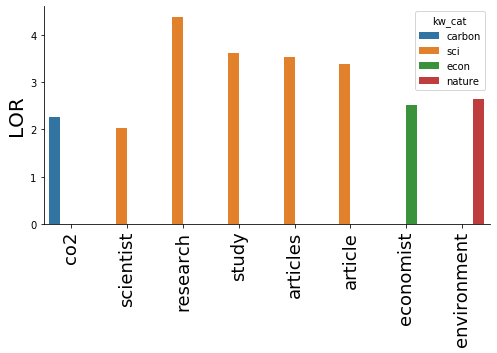

In [44]:
science_keywords = {
    'carbon': ['co2','carbon','dioxide','carbon dioxide','greenhouse','methane'],
    'sci': ['experiment','science','97','scientist','chemistry','ipcc','research','study','articles',
           'article'],
    'econ': ['economist','rich','poor','free market'],
    'nature': ['ocean','cycle','biodiversity','ecosystem','atmosphere','release','extinction','climate',
              'environment']
}

keyword2cat = {kw: key for key in science_keywords for kw in science_keywords[key]}

for corp_name in ['matched_cmv_subsample']:#corp_to_analyze:
    lor_dict = dict(zip([item[0] for item in top_sig_lors[corp_name]],
                        [item[1] for item in top_sig_lors[corp_name]]))
    to_plot_df = pd.DataFrame({
        'kw': [item for sublist in science_keywords.values() for item in sublist if item in lor_dict]
    })
    to_plot_df['kw_cat'] = [keyword2cat[kw] for kw in to_plot_df['kw'].values]
    to_plot_df['lor'] = [lor_dict[kw] for kw in to_plot_df['kw'].values]
    
    fig,ax = plt.subplots(figsize=(8,4))
    sns.barplot(data=to_plot_df,x='kw',y='lor',hue='kw_cat',ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90,fontsize=18)
    ax.set_ylabel("LOR",fontsize=20)
    ax.set_xlabel('')
    sns.despine()

In [45]:
def retrieve_utts_for_inspection(corp,keyword_set):
    return [utt for utt in corp.iter_utterances()
            if contains_keyword(utt.text,keyword_set)]

In [46]:
utts_per_kw = defaultdict(dict)

for kw_cat in science_keywords:
    utts_ = retrieve_utts_for_inspection(corp_to_analyze['matched_cmv_subsample'],science_keywords[kw_cat])
    delta_utts = [u for u in utts_ if u.meta['is_awarded_delta']]
    no_delta_utts = [u for u in utts_ if not u.meta['is_awarded_delta']]
    utts_per_kw[kw_cat]['+delta'] = delta_utts
    utts_per_kw[kw_cat]['-delta'] = no_delta_utts
    
for kw_cat in utts_per_kw:
    print(f"Found {len(utts_per_kw[kw_cat]['+delta'])+len(utts_per_kw[kw_cat]['-delta'])} utterances containing a {kw_cat.upper()} word.")
    print(f"\tNum +delta: {len(utts_per_kw[kw_cat]['+delta'])},\
    Num -delta: {len(utts_per_kw[kw_cat]['-delta'])}")

Found 876 utterances containing a CARBON word.
	Num +delta: 151,    Num -delta: 725
Found 16728 utterances containing a SCI word.
	Num +delta: 2859,    Num -delta: 13869
Found 10157 utterances containing a ECON word.
	Num +delta: 1411,    Num -delta: 8746
Found 8899 utterances containing a NATURE word.
	Num +delta: 1492,    Num -delta: 7407


Look at headwords for science keywords in + vs. -delta comments.

In [47]:
def get_headwords_of_words(utt,stanza_dir,keyword_set):
    json_obj = get_stanza_json(utt,stanza_dir=stanza_dir)
    headwords = []
    if json_obj is not None:
        for ix_sent,sent in enumerate(json_obj['parse']):
            for ix_x,x in enumerate(sent):
                if x['lemma'].lower() in keyword_set:
                    if int(x['head']) > int(x['id']):
                        headwords.append(f"{x['lemma']}_{x['deprel']} {json_obj['parse'][ix_sent][int(x['head']-1)]['lemma']}")
                    else:
                        headwords.append(f"{json_obj['parse'][ix_sent][int(x['head']-1)]['lemma']} {x['lemma']}_{x['deprel']}")
    return headwords

In [51]:
pos_delta_sci_kw_df = pd.DataFrame({'id':[u.id for u in utts_per_kw['sci']['+delta']],
             'text':[u.text.strip() for u in utts_per_kw['sci']['+delta']],
             'kw_heads':[get_headwords_of_words(u,STANZA_DIR,science_keywords['sci']) 
                         for u in utts_per_kw['sci']['+delta']]})
neg_delta_sci_kw_df = pd.DataFrame({'id':[u.id for u in utts_per_kw['sci']['-delta']],
             'text':[u.text.strip() for u in utts_per_kw['sci']['-delta']],
             'kw_heads':[get_headwords_of_words(u,STANZA_DIR,science_keywords['sci']) 
                         for u in utts_per_kw['sci']['-delta']]})

In [50]:
counted_pos_delta_sci_kw_heads = Counter([item for sublist in pos_delta_df['kw_heads'].values for item in sublist])
sorted_pos_delta_sci_kw_heads = sorted(counted_pos_delta_sci_kw_heads.items(), key=lambda x: x[1], reverse=True)
sorted_pos_delta_sci_kw_heads[:50]

[('do research_obj', 130),
 ('. study_root', 96),
 ('here article_nsubj', 55),
 ('study_nsubj find', 48),
 ('read article_obj', 46),
 ('be study_nsubj', 46),
 ('study_nsubj show', 46),
 ('science_compound fiction', 42),
 ('research_nsubj show', 36),
 ('. science_root', 31),
 ('. research_root', 31),
 ('lot research_nmod', 28),
 ('. scientist_root', 25),
 ('] study_root', 23),
 ('be research_nsubj', 22),
 ('find article_obj', 19),
 ('be article_nsubj', 19),
 ('. experiment_root', 19),
 ('math science_conj', 19),
 ('. article_root', 18),
 ('science_nsubj have', 18),
 ('research_nsubj suggest', 18),
 ('do study_obj', 17),
 ('field study_nmod', 16),
 ('write article_obj', 16),
 ('research_compound paper', 15),
 ('] article_root', 15),
 ('97_nummod %', 15),
 ('read study_obj', 15),
 ('see study_obj', 15),
 ('see article_obj', 15),
 ('use science_obj', 15),
 ('do experiment_obj', 14),
 (': article_root', 13),
 ('here study_nsubj', 13),
 ('look study_obl', 13),
 ('conduct research_obj', 12),


In [53]:
counted_neg_delta_sci_kw_heads = Counter([item for sublist in neg_delta_sci_kw_df['kw_heads'].values 
                                          for item in sublist])
sorted_neg_delta_sci_kw_heads = sorted(counted_neg_delta_sci_kw_heads.items(), key=lambda x: x[1], reverse=True)
sorted_neg_delta_sci_kw_heads[:50]

[('do research_obj', 670),
 ('. study_root', 397),
 ('read article_obj', 272),
 ('be study_nsubj', 244),
 ('study_nsubj find', 198),
 ('study_nsubj show', 184),
 ('. science_root', 180),
 ('here article_nsubj', 166),
 ('science_compound fiction', 148),
 ('research_nsubj show', 121),
 ('be research_nsubj', 121),
 ('math science_conj', 116),
 ('field study_nmod', 109),
 ('lot research_nmod', 109),
 ('. experiment_root', 96),
 ('. research_root', 91),
 ('. article_root', 88),
 ('do experiment_obj', 83),
 ('be article_nsubj', 82),
 ('do study_obj', 80),
 ('. scientist_root', 78),
 ('article_nsubj say', 75),
 ('find article_obj', 71),
 ('here study_nsubj', 69),
 ('] study_root', 67),
 ('write article_obj', 65),
 ('have study_obj', 64),
 ('science_nsubj say', 64),
 ('see article_obj', 62),
 ('science_nsubj have', 62),
 ('find study_obj', 62),
 ('do science_obj', 61),
 ('base science_obl', 61),
 ('] article_root', 60),
 ('science_nsubj work', 58),
 ('science_compound class', 56),
 ('research_

## LOR replies by OP awarding vs. not awarding deltas

In [64]:
Counter([utt.id[:2] for utt in corp_to_analyze['full_cmv'].iter_utterances()])

Counter({'t1': 158732, 't3': 44420})

In [78]:
def written_by_OP(utt,corp):
    return utt.speaker.id == corp.get_utterance(utt.conversation_id).speaker.id

def is_awarding_delta(utt):
    return utt.id in delta_awarding_utt_ids

OP_replies = [(utt,is_awarding_delta(utt)) for utt in corp_to_analyze['full_cmv'].iter_utterances()
              if written_by_OP(utt,corp_to_analyze['full_cmv']) and utt.id[:2] == 't1']
OP_reply_bins = {
    '+delta': set([reply.id for (reply,is_awarding) in OP_replies if is_awarding]),
    '-delta': set([reply.id for (reply,is_awarding) in OP_replies if not is_awarding])}

In [73]:
len(delta_awarding_utt_ids)

34796

In [74]:
len(OP_replies)

537094

In [79]:
for key in OP_reply_bins:
    print(key,len(OP_reply_bins[key]))

+delta 23916
-delta 513178


In [80]:
list(OP_reply_bins['+delta'])[:5]

['t1_etcmcng', 't1_gfkkyay', 't1_e5t7p05', 't1_ep5hp34', 't1_cg6fxjl']

In [83]:
from convokit import FightingWords
fw = FightingWords(ngram_range=(1,2))
fw.fit(corp_to_analyze['full_cmv'], class1_func=lambda utt: utt.id in OP_reply_bins['+delta'], 
                                    class2_func=lambda utt: utt.id in OP_reply_bins['-delta'])

Initializing default CountVectorizer with ngram_range (1, 2)... Done.
class1_func returned 23916 valid corpus components. class2_func returned 513178 valid corpus components.
Vocab size is 15000
Comparing language...
ngram zscores computed.


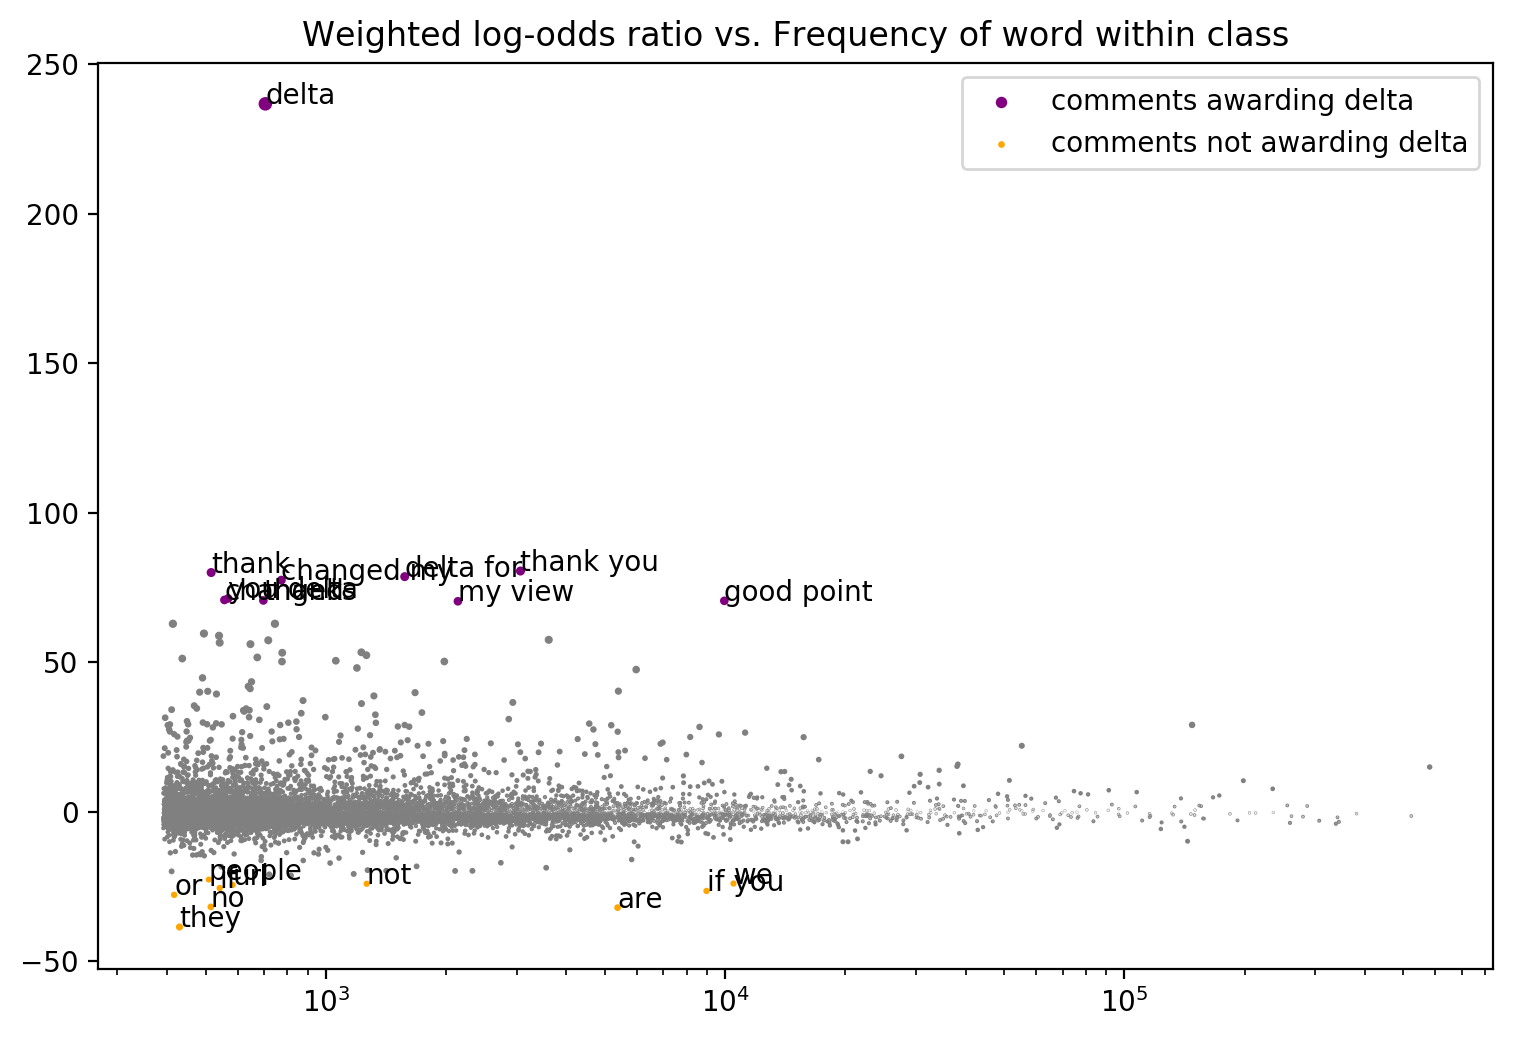

In [84]:
df = fw.summarize(corp_to_analyze['full_cmv'], plot=True, 
                  class1_name='comments awarding delta', class2_name='comments not awarding delta')

In [86]:
df.loc[df['z-score'].apply(lambda x: abs(x) > 1.97)]

z-score                        class
ngram                                                         
they                   -38.640114  comments not awarding delta
are                    -32.157305  comments not awarding delta
no                     -31.915936  comments not awarding delta
or                     -27.877045  comments not awarding delta
if you                 -26.575127  comments not awarding delta
if                     -25.597124  comments not awarding delta
url                    -24.567260  comments not awarding delta
not                    -24.178327  comments not awarding delta
we                     -24.098947  comments not awarding delta
people                 -22.753071  comments not awarding delta
you can                -21.417042  comments not awarding delta
why                    -21.042663  comments not awarding delta
women                  -20.883499  comments not awarding delta
do you                 -20.022507  comments not awarding delta
who                    -19.871367  comments not awarding delta
saying                 -19.846612  comments not awarding delta
he                     -19.821160  comments not awarding delta
don                    -19.613518  comments not awarding delta
men                    -18.815482  comments not awarding delta
them                   -18.462261  comments not awarding delta
their                  -18.350717  comments not awarding delta
then                   -17.233617  comments not awarding delta
what                   -17.149157  comments not awarding delta
all                    -16.390254  comments not awarding delta
you don                -16.365813  comments not awarding delta
any                    -16.064166  comments not awarding delta
want                   -15.589614  comments not awarding delta
are you                -15.490559  comments not awarding delta
they are               -15.105077  comments not awarding delta
talking about          -14.813607  comments not awarding delta
is not                 -14.578381  comments not awarding delta
doesn                  -14.543808  comments not awarding delta
by                     -14.437861  comments not awarding delta
talking                -14.247200  comments not awarding delta
mean                   -14.204857  comments not awarding delta
woman                  -14.196533  comments not awarding delta
sex                    -13.829883  comments not awarding delta
nothing                -13.829358  comments not awarding delta
black                  -13.773629  comments not awarding delta
every                  -13.737215  comments not awarding delta
you want               -13.666393  comments not awarding delta
cur                    -13.567691  comments not awarding delta
you think              -13.442810  comments not awarding delta
is that                -13.401541  comments not awarding delta
anything               -13.021146  comments not awarding delta
person                 -12.974755  comments not awarding delta
literally              -12.826634  comments not awarding delta
do                     -12.776471  comments not awarding delta
pay                    -12.623777  comments not awarding delta
can you                -12.362229  comments not awarding delta
money                  -12.096628  comments not awarding delta
she                    -12.009538  comments not awarding delta
tell                   -11.974285  comments not awarding delta
man                    -11.852295  comments not awarding delta
same                   -11.744609  comments not awarding delta
saying that            -11.734730  comments not awarding delta
because they           -11.663063  comments not awarding delta
government             -11.580568  comments not awarding delta
country                -11.323775  comments not awarding delta
let                    -11.278661  comments not awarding delta
us                     -11.235835  comments not awarding delta
white                  -11.086632  comments not awarding 

In [ ]:
# sample1_ids = [x.id for x in OP_reply_bins['+delta']]
# priors = []
# save_prefix = 'full_cmv_OP_awarding_vs_not_matched_cmv_prior'
# get_counts_for_lor(corpus, sample1_ids, priors, save_prefix, 
#                        stanza_dir='/u/scr/yiweil/Green-American-Lexicon/2_data_exploration/combined_stanza_output_with_ner_embed_removed',
#                        verbose=False, cache=False, background_only=False, skip_background=True,
#                        ngram_range=(1,2), min_df=5, do_lowercase=True, 
#                        upos=False, xpos=False, depparse=True, heads=False):

# User-level analysis

In [51]:
import praw
from praw.models import Submission
from prawcore.exceptions import Forbidden,NotFound

reddit = praw.Reddit(client_id='ACEORGSlEeJyQhPyNRAUiA',
                     client_secret='xGN33fztXu_4jiOek_RHUtMGhHXAcQ',
                     user_agent='me',
                    password='redditC0bintr@sena',
                    username='Western-Wishbone573')
print(reddit.user.me())

Western-Wishbone573


Use user-level info as proxy for stance of OP?

In [89]:
convo_speaker_ids = [convo.speaker.id for convo in corp_to_analyze['full_cmv'].iter_utterances()
                    if convo.id[:2]=='t3']
len(convo_speaker_ids),len(set(convo_speaker_ids))

(26221, 15913)

In [107]:
list(convo_speaker_ids)[:2]

['RoyalWait', 'EconomistAnonymous']

In [103]:
#user_comments = {}
for speaker_id in tqdm(convo_speaker_ids):
    if type(speaker_id) == str and speaker_id not in user_comments:
        try:
            user = reddit.redditor(speaker_id)
            user_comments[speaker_id] = [x.id for x in user.comments.new(limit=None)] 
        except (Forbidden, NotFound) as e:
            pass
        
# dump cache
pickle.dump(user_comments,open('full_cmv_comments_per_speaker.pkl','wb'))

 24%|██▍       | 6277/26221 [10:10:10<52:33:48,  9.49s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 26221/26221 [34:02:49<00:00,  4.67s/it]   


In [102]:
speaker_id

'renaissanceman975'

In [98]:
user_comments['RoyalWait'][0].id

'hjmuk17'

In [106]:
# update meta
#user_comments = pickle.load(open('full_cmv_comments_per_speaker.pkl','rb'))

for speaker_id in tqdm(convo_speaker_ids):
    if speaker_id in user_comments:
        corp_to_analyze['full_cmv'].get_speaker(speaker_id).add_meta('comments', user_comments[speaker_id])
    else:
        corp_to_analyze['full_cmv'].get_speaker(speaker_id).add_meta('comments', [])

100%|██████████| 26221/26221 [00:00<00:00, 56977.22it/s]


In [65]:
user_comment_subs = [x.subreddit.display_name for x in user_comments]
sorted(Counter(user_comment_subs).items(),key=lambda x:x[1],reverse=True)

[('AmItheAsshole', 397),
 ('PokemonGoRaids', 87),
 ('QueerVexillology', 45),
 ('actuallesbians', 44),
 ('changemyview', 41),
 ('HolUp', 30),
 ('Sat', 28),
 ('ApplyingToCollege', 18),
 ('redditrequest', 16),
 ('lgbt', 14),
 ('beachcombing', 14),
 ('seaglass', 11),
 ('tifu', 9),
 ('AskLesbians', 8),
 ('MrBeast', 7),
 ('Lumity', 7),
 ('GoForGold', 7),
 ('LofiGirl', 7),
 ('BanGDream', 7),
 ('TheOwlHouse', 6),
 ('ZombielandSaga', 6),
 ('relationship_advice', 6),
 ('dating_advice', 5),
 ('LittleWitchAcademia', 5),
 ('amiugly', 5),
 ('ChiknNuggit', 4),
 ('highschool', 4),
 ('APStudents', 4),
 ('MonarchButterfly', 4),
 ('guineapigs', 4),
 ('SapphoAndHerFriend', 3),
 ('apphysics', 3),
 ('clevercomebacks', 3),
 ('relationships', 3),
 ('TIHI', 2),
 ('DDLC', 2),
 ('LGBTBooks', 2),
 ('MadeMeSmile', 2),
 ('SuddenlyGay', 2),
 ('TwoXChromosomes', 2),
 ('WLW', 2),
 ('APStatistics', 2),
 ('Butterflies', 2),
 ('copypasta', 2),
 ('pettyrevenge', 2),
 ('comingout', 2),
 ('bisexual', 2),
 ('animememes', 1),

In [67]:
user_friends = [friend.display_name for friend in user.friends(limit=None)]

AttributeError: 'Redditor' object has no attribute 'friends'

# Topic analysis

## Why do "doom people" think we're doomed?